In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import torch.optim as optim

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, normalized_mutual_info_score
from unidip.dip import diptst
from tqdm import tqdm
import time
import datetime

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Will use {device}')

Will use cuda


#### Define Encoder and Decoder

In [4]:
class Encoder(nn.Module):
    def __init__(self, d, m=5):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(d, 500),
                                     nn.ReLU(),
                                     nn.Linear(500, 500),
                                     nn.ReLU(),
                                     nn.Linear(500, 2000),
                                     nn.ReLU(),
                                     nn.Linear(2000, m),)
    def forward(self, inputs):
        outputs = self.encoder(inputs)
        return outputs
    
class Decoder(nn.Module):
    def __init__(self, d, m=5):
        super(Decoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(m, 2000),
                                     nn.ReLU(),
                                     nn.Linear(2000, 500),
                                     nn.ReLU(),
                                     nn.Linear(500, 500),
                                     nn.ReLU(),
                                     nn.Linear(500, d),
                                     nn.Sigmoid())
    def forward(self, inputs):
        outputs = self.encoder(inputs)
        return outputs

#### Define Loss

In [5]:
class Lrec(nn.Module):
    def __init__(self):
        super(Lrec, self).__init__()
        
    def forward(self, output, targets):
        return torch.mean(torch.sum(torch.square(output-targets), dim=-1))
    
class Lclu(nn.Module):
    def __init__(self):
        super(Lclu, self).__init__()
        
    def forward(self, encoded_inputs, encoded_centres, Dc, P):
        k = Dc.shape[0]
        mean = torch.sum(Dc)/(k**2-k)
        std = torch.sqrt(torch.sum(torch.square(Dc-mean))/(k**2-k))
        return ((1+std)/mean)*torch.mean(torch.sum(P*torch.sum(torch.square(torch.unsqueeze(encoded_inputs, 1)-encoded_centres),-1),-1))

#### Define pre-train function

In [6]:
def Pre_train_AE(dataset, epochs=100, lr=0.001, batch_size=256):
    N_feature = np.prod(dataset.data.shape[1:])
    data = dataset.data.view(-1, N_feature).to(device)
    enc = Encoder(N_feature).to(device)
    dec = Decoder(N_feature).to(device)
    optimizer1 = torch.optim.Adam(enc.parameters(), lr=lr)
    optimizer2 = torch.optim.Adam(dec.parameters(), lr=lr)
    Lrec_function = Lrec().to(device)
    
    for epoch in range(epochs):
        total_loss = 0
        random_perm = np.random.permutation(len(dataset))
        mini_batch_index = 0
        while True:
            indices = random_perm[mini_batch_index:mini_batch_index + batch_size]
            inputs = data[indices]
            
            enc.zero_grad() #清空前一次的gradient
            dec.zero_grad() #清空前一次的gradient
            
            encoded = enc(inputs)
            decoded = dec(encoded)
            loss = Lrec_function(decoded, inputs)
            loss.backward()
            
            optimizer1.step()
            optimizer2.step()
            total_loss += loss
            
            mini_batch_index += batch_size
            if mini_batch_index >= len(dataset):
                break
        total_loss /= len(dataset)
        
        print(f'[{epoch+1}/{epochs}] Loss: {total_loss}')
    return enc, dec

#### Define DipDECK

In [7]:
class DipDECK:
    def __init__(self, dataset, enc, dec, k_init=15, P_threshold=0.9, epochs=50, batch_size = 256):
        self.BATCHSIZE = batch_size
        self.N_DATA, self.N_FEATURE = len(dataset), np.prod(dataset.data.shape[1:])
        self.data = dataset.data.type(torch.float32).view(-1,self.N_FEATURE)
        self.P_threshold = P_threshold
        self.k = k_init
        self.enc = enc
        self.dec = dec
        print('******************** Apply K-means ********************')
        with torch.no_grad():
            Km_model = KMeans(self.k)
            Km_model.fit(enc(self.data.to(device)).cpu())
        self.kmCentres = torch.tensor(Km_model.cluster_centers_, dtype=torch.float32)
        self.labels = torch.tensor(Km_model.labels_, dtype=torch.int64)
        print('********** finding closest points to kmCentres **********')
        self.centres = self.find_centres1()
        # print('******************** building DipMatrix ********************')
        self.DipMatrix = self.build_DipMatrix()
        print('******************** Batch optimizing ********************')
        self.Batch_optimize(epochs)
        
    def Batch_optimize(self, epochs, lr=0.0001):
        optimizer1 = torch.optim.Adam(self.enc.parameters(), lr=lr)
        optimizer2 = torch.optim.Adam(self.dec.parameters(), lr=lr)
        Lrec_function = Lrec().to(device)
        Lclu_function = Lclu().to(device)
        
        i = 0
        while i<epochs:
            print(f'********** epoch {i+1} of {epochs} **********')
            random_perm = np.random.permutation(self.N_DATA)
            mini_batch_index = 0
            j = 0
            while True:
                indices = random_perm[mini_batch_index:mini_batch_index + self.BATCHSIZE]
                if i!=0:
                    self.update_labels(indices)
                inputs = self.data[indices].to(device)
                encoded_centres = self.enc(self.centres.to(device))
                r = torch.sum(torch.square(encoded_centres), axis=1)
                Dc = torch.sqrt((r+encoded_centres@encoded_centres.T).T+r)
                specific_PMetrix = self.nDipMatrix[torch.unsqueeze(self.labels[indices],0)[0]].to(device)
                
                self.enc.zero_grad()
                self.dec.zero_grad()
                
                encoded = self.enc(inputs)
                decoded = self.dec(encoded)
                L1 = Lrec_function(decoded, inputs)
                L2 = Lclu_function(encoded, encoded_centres, Dc, specific_PMetrix)
                L = L1 + L2
                L.backward()
                
                optimizer1.step()
                optimizer2.step()
                print(f'[{j+1}/{self.N_DATA//self.BATCHSIZE+1 if self.N_DATA%self.BATCHSIZE else self.N_DATA//self.BATCHSIZE}] batch loss:{L/self.BATCHSIZE} (Lrec:{L1/self.BATCHSIZE}, Lclu:{L2/self.BATCHSIZE})')
                
                mini_batch_index += self.BATCHSIZE
                if mini_batch_index >= self.N_DATA:
                    break
                j += 1
                    
            self.update_labels(range(self.k))
            self.centres = self.find_centres2()
            self.DipMatrix = self.build_DipMatrix()
            i += 1
            with torch.no_grad():
                while torch.max(self.DipMatrix-torch.eye(self.k))>=self.P_threshold:
                    self.k -= 1
                    print(f'********** merging (remain {self.k} cluster) **********')
                    argmax = torch.argmax(self.DipMatrix-torch.eye(self.k+1))
                    Ci, Cj = argmax//self.DipMatrix.shape[1], argmax%self.DipMatrix.shape[1]
                    Ci, Cj = (Ci, Cj) if Ci<=Cj else (Cj, Ci)
                    self.labels[self.labels==Cj] = Ci
                    self.labels[self.labels>Cj] = self.labels[self.labels>Cj]-1
                    new_centre = self.find_merged_centre(Ci, Cj)
                    self.centres[Ci] = new_centre
                    self.centres = torch.concat([self.centres[:Cj,:], self.centres[Cj+1:,:]], 0)
                    self.DipMatrix = self.update_DipMatrix(Ci, Cj)
                    i = 0
            
    @torch.no_grad()
    def find_centres1(self):
        encoded_data = self.enc(self.data.to(device))
        dist = torch.sum(torch.square(encoded_data-torch.unsqueeze(self.kmCentres.to(device), 1)),-1)
        return self.data[torch.argmin(dist, -1)]
    
    @torch.no_grad()
    def find_centres2(self):
        encoded_data = self.enc(self.data.to(device))
        centres = torch.zeros(self.k, self.data.shape[1]).to(device)
        for i in range(self.k):
            centre_ = torch.mean(encoded_data[self.labels==i], axis=0)
            dist = torch.sum(torch.square(encoded_data-centre_), axis=-1)
            centres[i] = self.data[torch.argmin(dist)]
        return centres
    
    @torch.no_grad()
    def find_merged_centre(self, Ci, Cj):
        data_CiCj = self.data[torch.logical_or(self.labels==Ci,self.labels==Cj)].to(device)
        encoded_data_CiCj = self.enc(data_CiCj)
        encoded_centres = self.enc(self.centres.to(device))
        centre_Ci, centre_Cj = encoded_centres[Ci], encoded_centres[Cj]
        N_Ci, N_Cj = torch.sum(self.labels==Ci), torch.sum(self.labels==Cj)
        weighted_centre = (N_Ci*centre_Ci+N_Cj*centre_Cj)/(N_Ci+N_Cj)
        dist = torch.sum(torch.square(encoded_data_CiCj-weighted_centre), axis=-1)
        return data_CiCj[torch.argmin(dist)].cpu()
    
    @torch.no_grad()
    def build_DipMatrix(self):
        print(f'******************** building DipMatrix ********************')
        encoded_data = self.enc(self.data.to(device)).cpu()
        encoded_centres = self.enc(self.centres.to(device)).cpu()
        dip_matrix = torch.eye(self.k, dtype=torch.float32)
        with tqdm(total=self.k*(self.k-1)//2) as pbar:
            for i in range(self.k):
                for j in range(i+1,self.k):
                    points = encoded_data[torch.logical_or(self.labels==i,self.labels==j)]
                    C_1d = torch.sum(points*(encoded_centres[i]-encoded_centres[j]), dim=-1)
#                     C_1d_hist, _ = torch.histogram(C_1d, bins=int(len(C_1d)/3))
                    P1 = diptst(C_1d.numpy(), is_hist=False)[1]
                    N_Ci, N_Cj = torch.sum(self.labels==i), torch.sum(self.labels==j)
                    (Ci, Cj, N_Ci, N_Cj) = (i, j, N_Ci, N_Cj) if N_Ci<=N_Cj else (j, i, N_Cj, N_Ci)
                    if N_Cj>2*N_Ci and N_Ci!=0:
                        points_Cj = encoded_data[self.labels==Cj]
                        dist2Ci = torch.sum(torch.square(points_Cj-encoded_centres[Ci]), dim=-1)
                        partition_points_Cj = points_Cj[dist2Ci<=np.max(np.partition(dist2Ci,2*N_Ci)[:2*N_Ci])]
                        points = torch.concat([encoded_data[self.labels==Ci], partition_points_Cj])
                        C_1d = torch.sum(points*(encoded_centres[i]-encoded_centres[j]), axis=-1)
#                         C_1d_hist, _ = torch.histogram(C_1d, bins=int(len(C_1d)/3))
                        P2 = diptst(C_1d.numpy(), is_hist=False)[1]
                        dip_matrix[i,j] = dip_matrix[j,i] = min(P1, P2)
                    else:
                        dip_matrix[i,j] = dip_matrix[j,i] = P1
                    pbar.update(1)
        self.nDipMatrix = self.Matrix2affine(dip_matrix)
        return dip_matrix
    
    @torch.no_grad()
    def update_DipMatrix(self, idx, jdx):
        print(f'******************** updating DipMatrix ********************')
        encoded_data = self.enc(self.data.to(device)).cpu()
        encoded_centres = self.enc(self.centres.to(device)).cpu()
        dip_matrix = torch.concat([self.DipMatrix[:,:jdx], self.DipMatrix[:,jdx+1:]], 1)
        dip_matrix = torch.concat([dip_matrix[:jdx,:], dip_matrix[jdx+1:,:]], 0)
        with tqdm(total=self.k-1) as pbar:
            for j in range(self.k):
                if j==idx:
                    continue
                points = encoded_data[torch.logical_or(self.labels==idx,self.labels==j)]
                C_1d = torch.sum(points*(encoded_centres[idx]-encoded_centres[j]), axis=-1)
#                 C_1d_hist, _ = torch.histogram(C_1d, bins=int(len(C_1d)/3))
                P1 = diptst(C_1d.numpy(), is_hist=False)[1]
                N_Ci, N_Cj = torch.sum(self.labels==idx), torch.sum(self.labels==j)
                (Ci, Cj, N_Ci, N_Cj) = (idx, j, N_Ci, N_Cj) if N_Ci<=N_Cj else (j, idx, N_Cj, N_Ci)
                if N_Cj>2*N_Ci and N_Ci!=0:
                    points_Cj = encoded_data[self.labels==Cj]
                    dist2Ci = torch.sum(torch.square(points_Cj-encoded_centres[Ci]), axis=-1)
                    partition_points_Cj = points_Cj[dist2Ci<=np.max(np.partition(dist2Ci,2*N_Ci)[:2*N_Ci])]
                    points = torch.concat([encoded_data[self.labels==Ci], partition_points_Cj])
                    C_1d = torch.sum(points*(encoded_centres[idx]-encoded_centres[j]), axis=-1)
#                     C_1d_hist, _ = torch.histogram(C_1d, bins=int(len(C_1d)/3))
                    P2 = diptst(C_1d.numpy(), is_hist=False)[1]
                    dip_matrix[idx,j] = dip_matrix[j,idx] = min(P1, P2)
                else:
                    dip_matrix[idx,j] = dip_matrix[j,idx] = P1
                pbar.update(1)
        self.nDipMatrix = self.Matrix2affine(dip_matrix)
        print(dip_matrix)
        return dip_matrix
    
    def Matrix2affine(self, matrix):
        return (matrix/matrix.sum(1)).T
    
    @torch.no_grad()
    def update_labels(self, indices):
        encoded_data = self.enc(self.data.to(device))
        encoded_centres = self.enc(self.centres.to(device))
        D = torch.sum(torch.square(encoded_data-torch.unsqueeze(encoded_centres, 1)),-1)
        new_labels = torch.argmin(D, axis=0).type(torch.int64).cpu()
        self.labels[indices] = new_labels[indices]

#### Test

In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

import matplotlib.pyplot as plt

In [9]:
train_data = datasets.MNIST('./dataset',
                            train=True,
                            download=False,
                            transform=transforms.ToTensor())
train_data.data = train_data.data/255

In [10]:
start = time.time()
enc, dec = Pre_train_AE(train_data, epochs=100, lr=0.001)
end = time.time()
print(f'\n預訓練耗時{str(datetime.timedelta(seconds=end-start))}')

[1/100] Loss: 0.1845223754644394
[2/100] Loss: 0.10197082161903381
[3/100] Loss: 0.08456844091415405
[4/100] Loss: 0.07912873476743698
[5/100] Loss: 0.07554053515195847
[6/100] Loss: 0.07305704802274704
[7/100] Loss: 0.07088807970285416
[8/100] Loss: 0.06931415945291519
[9/100] Loss: 0.06765890121459961
[10/100] Loss: 0.06659907102584839
[11/100] Loss: 0.06546071171760559
[12/100] Loss: 0.06447380781173706
[13/100] Loss: 0.06363598257303238
[14/100] Loss: 0.06291957944631577
[15/100] Loss: 0.06222496181726456
[16/100] Loss: 0.06158175691962242
[17/100] Loss: 0.06093890964984894
[18/100] Loss: 0.060539498925209045
[19/100] Loss: 0.06011363863945007
[20/100] Loss: 0.05964535474777222
[21/100] Loss: 0.05918838828802109
[22/100] Loss: 0.05873720720410347
[23/100] Loss: 0.05845167115330696
[24/100] Loss: 0.058135684579610825
[25/100] Loss: 0.05786357447504997
[26/100] Loss: 0.057416513562202454
[27/100] Loss: 0.057144567370414734
[28/100] Loss: 0.056789811700582504
[29/100] Loss: 0.05658674

In [11]:
start = time.time()
Model = DipDECK(train_data, enc.to(device), dec.to(device), k_init=35, epochs=50)
end = time.time()
print(f'共分了{Model.k}群，耗時{str(datetime.timedelta(seconds=end-start))}')

******************** Apply K-means ********************
********** finding closest points to kmCentres **********
******************** building DipMatrix ********************


100%|████████████████████████████████████████████████████████████████████████████████| 595/595 [38:12<00:00,  3.85s/it]


******************** Batch optimizing ********************
********** epoch 1 of 50 **********
[1/235] batch loss:0.05754665285348892 (Lrec:0.048087023198604584, Lclu:0.009459628723561764)
[2/235] batch loss:0.05080952122807503 (Lrec:0.042758408933877945, Lclu:0.008051113225519657)
[3/235] batch loss:0.05765949934720993 (Lrec:0.04892560839653015, Lclu:0.00873388908803463)
[4/235] batch loss:0.051964640617370605 (Lrec:0.04408753290772438, Lclu:0.007877105847001076)
[5/235] batch loss:0.05730801820755005 (Lrec:0.049427855759859085, Lclu:0.007880164310336113)
[6/235] batch loss:0.055010996758937836 (Lrec:0.047176145017147064, Lclu:0.007834850810468197)
[7/235] batch loss:0.054071951657533646 (Lrec:0.046501561999320984, Lclu:0.007570389658212662)
[8/235] batch loss:0.0550517812371254 (Lrec:0.047417640686035156, Lclu:0.0076341405510902405)
[9/235] batch loss:0.052507203072309494 (Lrec:0.045030154287815094, Lclu:0.0074770487844944)
[10/235] batch loss:0.05479549616575241 (Lrec:0.047292865812

[100/235] batch loss:0.05339404568076134 (Lrec:0.04852951318025589, Lclu:0.004864532966166735)
[101/235] batch loss:0.04902566224336624 (Lrec:0.04428314045071602, Lclu:0.0047425199300050735)
[102/235] batch loss:0.04918220639228821 (Lrec:0.043919846415519714, Lclu:0.005262359045445919)
[103/235] batch loss:0.051639072597026825 (Lrec:0.0466366708278656, Lclu:0.00500240083783865)
[104/235] batch loss:0.048072636127471924 (Lrec:0.04353637620806694, Lclu:0.004536258522421122)
[105/235] batch loss:0.055122338235378265 (Lrec:0.04976786673069, Lclu:0.005354470107704401)
[106/235] batch loss:0.05199137330055237 (Lrec:0.04685334488749504, Lclu:0.005138029810041189)
[107/235] batch loss:0.051459550857543945 (Lrec:0.04690743237733841, Lclu:0.004552119877189398)
[108/235] batch loss:0.05398804694414139 (Lrec:0.04876365885138512, Lclu:0.005224388558417559)
[109/235] batch loss:0.051175277680158615 (Lrec:0.046496279537677765, Lclu:0.0046789986081421375)
[110/235] batch loss:0.05172981694340706 (Lrec

[199/235] batch loss:0.05105677619576454 (Lrec:0.04625512659549713, Lclu:0.004801650997251272)
[200/235] batch loss:0.05110868439078331 (Lrec:0.046156905591487885, Lclu:0.004951779264956713)
[201/235] batch loss:0.05261397361755371 (Lrec:0.04835258796811104, Lclu:0.00426138611510396)
[202/235] batch loss:0.05127197876572609 (Lrec:0.04666173830628395, Lclu:0.004610239993780851)
[203/235] batch loss:0.04745817556977272 (Lrec:0.04325059428811073, Lclu:0.004207580350339413)
[204/235] batch loss:0.049936335533857346 (Lrec:0.04534873366355896, Lclu:0.004587601404637098)
[205/235] batch loss:0.049804944545030594 (Lrec:0.045062825083732605, Lclu:0.004742118529975414)
[206/235] batch loss:0.052374616265296936 (Lrec:0.04758701100945473, Lclu:0.004787606652826071)
[207/235] batch loss:0.04777592420578003 (Lrec:0.04297675937414169, Lclu:0.0047991652972996235)
[208/235] batch loss:0.05131873860955238 (Lrec:0.04693180322647095, Lclu:0.0043869344517588615)
[209/235] batch loss:0.05173112079501152 (Lr

100%|████████████████████████████████████████████████████████████████████████████████| 595/595 [38:03<00:00,  3.84s/it]
C:\Users\hello\AppData\Local\Temp/ipykernel_13160/2137155212.py:73: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  Ci, Cj = argmax//self.DipMatrix.shape[1], argmax%self.DipMatrix.shape[1]


********** merging (remain 34 cluster) **********
******************** updating DipMatrix ********************


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [03:56<00:00,  7.16s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04,  ..., 9.9900e-04, 9.9900e-04,
         9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04,  ..., 9.9900e-04, 9.9900e-04,
         9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00,  ..., 9.9900e-04, 9.9900e-04,
         9.9900e-04],
        ...,
        [9.9900e-04, 9.9900e-04, 9.9900e-04,  ..., 1.0000e+00, 9.9900e-04,
         9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04,  ..., 9.9900e-04, 1.0000e+00,
         9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04,  ..., 9.9900e-04, 9.9900e-04,
         1.0000e+00]])
********** merging (remain 33 cluster) **********
******************** updating DipMatrix ********************


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [04:40<00:00,  8.77s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04,  ..., 9.9900e-04, 9.9900e-04,
         9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04,  ..., 9.9900e-04, 9.9900e-04,
         9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00,  ..., 9.9900e-04, 9.9900e-04,
         9.9900e-04],
        ...,
        [9.9900e-04, 9.9900e-04, 9.9900e-04,  ..., 1.0000e+00, 9.9900e-04,
         9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04,  ..., 9.9900e-04, 1.0000e+00,
         9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04,  ..., 9.9900e-04, 9.9900e-04,
         1.0000e+00]])
********** merging (remain 32 cluster) **********
******************** updating DipMatrix ********************


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [04:41<00:00,  9.07s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04,  ..., 9.9900e-04, 9.9900e-04,
         9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04,  ..., 9.9900e-04, 9.9900e-04,
         9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00,  ..., 9.9900e-04, 9.9900e-04,
         9.9900e-04],
        ...,
        [9.9900e-04, 9.9900e-04, 9.9900e-04,  ..., 1.0000e+00, 9.9900e-04,
         9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04,  ..., 9.9900e-04, 1.0000e+00,
         9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04,  ..., 9.9900e-04, 9.9900e-04,
         1.0000e+00]])
********** merging (remain 31 cluster) **********
******************** updating DipMatrix ********************


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [02:10<00:00,  4.35s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 8.7612e-01, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [04:04<00:00,  8.44s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 8.7612e-01, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.990

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [04:14<00:00,  9.09s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 8.7612e-01, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.850

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [02:18<00:00,  5.14s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 8.7612e-01, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.8501e-01, 9.9900e-04, 9.9900e-04, 9.990

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [02:32<00:00,  5.85s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 8.7612e-01, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.8501e-01, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:46<00:00,  9.06s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 8.7612e-01, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.8501e-01, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.7502e-01, 9.9900e-

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [05:54<00:00, 14.77s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 8.7612e-01, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-01, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9800e-01, 9.9900e-04, 1.0000e+00, 3.8961e-02,
         9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.8501e-01, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.7502e-01, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [06:03<00:00, 15.81s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 8.7612e-01, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9101e-01, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 2.9970e-03, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.8501e-01, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.7502e-01, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.99

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [05:57<00:00, 16.25s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 8.7612e-01, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.8801e-01, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-03, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.8501e-01, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.7502e-01, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.99

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [02:03<00:00,  5.89s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 8.7612e-01, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 1.1988e-02, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.8501e-01, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.7502e-01, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04,
         9.9900e

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:34<00:00,  4.74s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 8.7612e-01, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 1.1988e-02, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.8501e-01, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 3.4466e-01,
         9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [01:51<00:00,  5.88s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.8901e-01, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 1.1988e-02, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.8501e-01, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 3.4466e-01,
         9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
       

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:23<00:00,  7.95s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9101e-01, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         1.1988e-02, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.8501e-01,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 3.4466e-01, 9.9900e-04,
         9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 6.1938e-01,
         9.9900e-04, 9.9900e-04, 9.9900e-04

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [03:00<00:00, 10.62s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9101e-01, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         1.1988e-02, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.8501e-01,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 3.4466e-01, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 6.1938e-01,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 4.8551e-01, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [02:10<00:00,  8.19s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9101e-01, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         1.1988e-02, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.8501e-01,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 3.4466e-01, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 6.1938e-01,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 4.8551e-01, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:32<00:00, 10.19s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.1988e-02,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.8501e-01, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 3.4466e-01, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 6.1938e-01, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 4.8551e-01, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:39<00:00,  7.13s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.1988e-02,
         9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.8501e-01, 9.9900e-04,
         9.9900e-04, 3.4466e-01, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 6.1938e-01, 9.9900e-04,
         9.9900e-04, 4.8551e-01, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
      

 62%|███████████████████████████████████████████████████                                | 8/13 [01:27<00:46,  9.38s/it]C:\Users\hello\anaconda3\lib\site-packages\unidip\dip.py:27: RuntimeWarning: divide by zero encountered in true_divide
  slopes = (work_cdf[1:] - work_cdf[0]) / distances
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:12<00:00, 10.19s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.1988e-02,
         9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.8501e-01, 9.9900e-04,
         3.4466e-01, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 6.1938e-01, 9.9900e-04,
         4.8551e-01, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04],
        [9.9900e-04,

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:37<00:00,  8.10s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.1988e-02, 9.9900e-04,
         9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.8202e-01, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00,
         9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.8202e-01, 1.0000e+00, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 4.8551e-01,
         9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00,

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:28<00:00,  8.07s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.1988e-02, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.3207e-01, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.3207e-01, 1.0000e+00, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:48<00:00, 10.90s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 1.1988e-02, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         1.00

[75/235] batch loss:0.05055037513375282 (Lrec:0.04610694199800491, Lclu:0.0044434331357479095)
[76/235] batch loss:0.0525004006922245 (Lrec:0.04725777357816696, Lclu:0.005242627579718828)
[77/235] batch loss:0.050816554576158524 (Lrec:0.04570964723825455, Lclu:0.005106907803565264)
[78/235] batch loss:0.05210401117801666 (Lrec:0.047030337154865265, Lclu:0.005073674023151398)
[79/235] batch loss:0.05320879444479942 (Lrec:0.04886864498257637, Lclu:0.004340148996561766)
[80/235] batch loss:0.0515548437833786 (Lrec:0.046927206218242645, Lclu:0.004627639427781105)
[81/235] batch loss:0.048312172293663025 (Lrec:0.04358348995447159, Lclu:0.0047286818735301495)
[82/235] batch loss:0.05179385468363762 (Lrec:0.047133918851614, Lclu:0.004659935832023621)
[83/235] batch loss:0.050803303718566895 (Lrec:0.04634600132703781, Lclu:0.004457302391529083)
[84/235] batch loss:0.05124383792281151 (Lrec:0.04615671560168266, Lclu:0.0050871227867901325)
[85/235] batch loss:0.0514034740626812 (Lrec:0.046717993

[181/235] batch loss:0.049244172871112823 (Lrec:0.044571444392204285, Lclu:0.004672727547585964)
[182/235] batch loss:0.048927485942840576 (Lrec:0.044087160378694534, Lclu:0.00484032416716218)
[183/235] batch loss:0.050461478531360626 (Lrec:0.045755401253700256, Lclu:0.004706075880676508)
[184/235] batch loss:0.05039040744304657 (Lrec:0.04582504555583, Lclu:0.004565361887216568)
[185/235] batch loss:0.053325407207012177 (Lrec:0.0487397164106369, Lclu:0.004585691262036562)
[186/235] batch loss:0.047770604491233826 (Lrec:0.04349077120423317, Lclu:0.0042798323556780815)
[187/235] batch loss:0.049161531031131744 (Lrec:0.04440801963210106, Lclu:0.00475351233035326)
[188/235] batch loss:0.05105764418840408 (Lrec:0.04679016023874283, Lclu:0.004267485346645117)
[189/235] batch loss:0.04826783761382103 (Lrec:0.04404505714774132, Lclu:0.004222781863063574)
[190/235] batch loss:0.05135493353009224 (Lrec:0.047157153487205505, Lclu:0.004197780508548021)
[191/235] batch loss:0.049835506826639175 (Lr

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [10:08<00:00, 11.05s/it]


********** merging (remain 10 cluster) **********
******************** updating DipMatrix ********************


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:53<00:00, 25.90s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00,
         9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900

[80/235] batch loss:0.051504820585250854 (Lrec:0.04708848148584366, Lclu:0.004416337702423334)
[81/235] batch loss:0.05029347538948059 (Lrec:0.0457744225859642, Lclu:0.004519052803516388)
[82/235] batch loss:0.049836065620183945 (Lrec:0.045369431376457214, Lclu:0.00446663424372673)
[83/235] batch loss:0.050793152302503586 (Lrec:0.04635630175471306, Lclu:0.004436849150806665)
[84/235] batch loss:0.05084710568189621 (Lrec:0.046254027634859085, Lclu:0.004593077581375837)
[85/235] batch loss:0.05221687629818916 (Lrec:0.048037901520729065, Lclu:0.00417897617444396)
[86/235] batch loss:0.05618194118142128 (Lrec:0.05083242058753967, Lclu:0.005349521525204182)
[87/235] batch loss:0.0491272434592247 (Lrec:0.044833097606897354, Lclu:0.004294143989682198)
[88/235] batch loss:0.05082188546657562 (Lrec:0.04607626050710678, Lclu:0.004745626822113991)
[89/235] batch loss:0.05106069892644882 (Lrec:0.04669953137636185, Lclu:0.004361166153103113)
[90/235] batch loss:0.04747813567519188 (Lrec:0.043446101

[166/235] batch loss:0.05080227926373482 (Lrec:0.04605665057897568, Lclu:0.004745628219097853)
[167/235] batch loss:0.04819963127374649 (Lrec:0.043810632079839706, Lclu:0.004389000125229359)
[168/235] batch loss:0.05002397671341896 (Lrec:0.04604916274547577, Lclu:0.003974814433604479)
[169/235] batch loss:0.050633423030376434 (Lrec:0.04634898155927658, Lclu:0.004284442402422428)
[170/235] batch loss:0.05280779302120209 (Lrec:0.04833538457751274, Lclu:0.004472407512366772)
[171/235] batch loss:0.05213054269552231 (Lrec:0.04749492555856705, Lclu:0.004635616671293974)
[172/235] batch loss:0.05094011873006821 (Lrec:0.04635026305913925, Lclu:0.004589857067912817)
[173/235] batch loss:0.051088422536849976 (Lrec:0.0468013621866703, Lclu:0.004287061281502247)
[174/235] batch loss:0.04978318512439728 (Lrec:0.04538147151470184, Lclu:0.004401714541018009)
[175/235] batch loss:0.05041218176484108 (Lrec:0.04620380327105522, Lclu:0.004208379425108433)
[176/235] batch loss:0.051029037684202194 (Lrec:

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [08:44<00:00, 11.65s/it]


********** epoch 2 of 50 **********
[1/235] batch loss:0.048190511763095856 (Lrec:0.04391586780548096, Lclu:0.004274643957614899)
[2/235] batch loss:0.05063582584261894 (Lrec:0.04649510979652405, Lclu:0.004140716046094894)
[3/235] batch loss:0.05288776382803917 (Lrec:0.04863245040178299, Lclu:0.00425531342625618)
[4/235] batch loss:0.0496424101293087 (Lrec:0.04565317928791046, Lclu:0.003989230841398239)
[5/235] batch loss:0.05323399230837822 (Lrec:0.04826631024479866, Lclu:0.004967682063579559)
[6/235] batch loss:0.051957424730062485 (Lrec:0.04715001955628395, Lclu:0.004807404708117247)
[7/235] batch loss:0.04715397208929062 (Lrec:0.043012432754039764, Lclu:0.00414153840392828)
[8/235] batch loss:0.04796127602458 (Lrec:0.043826766312122345, Lclu:0.004134508315473795)
[9/235] batch loss:0.049139607697725296 (Lrec:0.04480094835162163, Lclu:0.004338660277426243)
[10/235] batch loss:0.050293248146772385 (Lrec:0.04544585570693016, Lclu:0.004847393371164799)
[11/235] batch loss:0.04882011562

[90/235] batch loss:0.04764067754149437 (Lrec:0.0438307486474514, Lclu:0.0038099291268736124)
[91/235] batch loss:0.04834643006324768 (Lrec:0.043876729905605316, Lclu:0.004469698760658503)
[92/235] batch loss:0.05126621946692467 (Lrec:0.04729048162698746, Lclu:0.003975736442953348)
[93/235] batch loss:0.046635840088129044 (Lrec:0.04243804141879082, Lclu:0.004197798669338226)
[94/235] batch loss:0.051532816141843796 (Lrec:0.047282874584198, Lclu:0.004249942488968372)
[95/235] batch loss:0.04927203059196472 (Lrec:0.045731738209724426, Lclu:0.0035402935463935137)
[96/235] batch loss:0.050387874245643616 (Lrec:0.04617272689938545, Lclu:0.004215146880596876)
[97/235] batch loss:0.046669717878103256 (Lrec:0.0429469496011734, Lclu:0.003722769906744361)
[98/235] batch loss:0.04822105914354324 (Lrec:0.0442504957318306, Lclu:0.003970562480390072)
[99/235] batch loss:0.04947768524289131 (Lrec:0.04556046426296234, Lclu:0.00391722097992897)
[100/235] batch loss:0.0497499518096447 (Lrec:0.0460796132

[178/235] batch loss:0.04811808094382286 (Lrec:0.044438377022743225, Lclu:0.0036797039210796356)
[179/235] batch loss:0.049285776913166046 (Lrec:0.045531295239925385, Lclu:0.00375448283739388)
[180/235] batch loss:0.04973343014717102 (Lrec:0.0457877516746521, Lclu:0.003945678006857634)
[181/235] batch loss:0.05138647183775902 (Lrec:0.047703664749860764, Lclu:0.0036828077863901854)
[182/235] batch loss:0.05026954412460327 (Lrec:0.046159110963344574, Lclu:0.004110434092581272)
[183/235] batch loss:0.04697431996464729 (Lrec:0.043368853628635406, Lclu:0.003605467267334461)
[184/235] batch loss:0.051475849002599716 (Lrec:0.04706704616546631, Lclu:0.004408801440149546)
[185/235] batch loss:0.051092036068439484 (Lrec:0.04723633453249931, Lclu:0.0038557027000933886)
[186/235] batch loss:0.049331165850162506 (Lrec:0.04500377178192139, Lclu:0.004327393136918545)
[187/235] batch loss:0.048435598611831665 (Lrec:0.044301025569438934, Lclu:0.004134572576731443)
[188/235] batch loss:0.049124706536531

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [08:37<00:00, 11.50s/it]


********** epoch 3 of 50 **********
[1/235] batch loss:0.04997653514146805 (Lrec:0.04568210989236832, Lclu:0.0042944252490997314)
[2/235] batch loss:0.05050697177648544 (Lrec:0.045884691178798676, Lclu:0.004622281063348055)
[3/235] batch loss:0.048253949731588364 (Lrec:0.043761152774095535, Lclu:0.004492797888815403)
[4/235] batch loss:0.05042713135480881 (Lrec:0.046288859099149704, Lclu:0.004138270393013954)
[5/235] batch loss:0.04942236840724945 (Lrec:0.045213162899017334, Lclu:0.004209205973893404)
[6/235] batch loss:0.04876062273979187 (Lrec:0.044623829424381256, Lclu:0.004136791452765465)
[7/235] batch loss:0.04978032410144806 (Lrec:0.045415010303258896, Lclu:0.004365315195173025)
[8/235] batch loss:0.04842647910118103 (Lrec:0.04429314285516739, Lclu:0.004133336246013641)
[9/235] batch loss:0.05294397473335266 (Lrec:0.048277661204338074, Lclu:0.004666313529014587)
[10/235] batch loss:0.050118450075387955 (Lrec:0.04617740958929062, Lclu:0.003941040486097336)
[11/235] batch loss:0.0

[90/235] batch loss:0.05079067498445511 (Lrec:0.0467650443315506, Lclu:0.004025632049888372)
[91/235] batch loss:0.04731497913599014 (Lrec:0.04335528612136841, Lclu:0.003959691617637873)
[92/235] batch loss:0.048555269837379456 (Lrec:0.04470756649971008, Lclu:0.0038477014750242233)
[93/235] batch loss:0.051980867981910706 (Lrec:0.04798315465450287, Lclu:0.003997711464762688)
[94/235] batch loss:0.05480760335922241 (Lrec:0.0502331480383873, Lclu:0.004574453458189964)
[95/235] batch loss:0.04896543547511101 (Lrec:0.044717252254486084, Lclu:0.004248182289302349)
[96/235] batch loss:0.04821997508406639 (Lrec:0.04470609128475189, Lclu:0.0035138854291290045)
[97/235] batch loss:0.04705170542001724 (Lrec:0.043224215507507324, Lclu:0.0038274903781712055)
[98/235] batch loss:0.04948129877448082 (Lrec:0.04575539007782936, Lclu:0.0037259086966514587)
[99/235] batch loss:0.049478769302368164 (Lrec:0.04558560252189636, Lclu:0.00389316794462502)
[100/235] batch loss:0.049748796969652176 (Lrec:0.0459

[177/235] batch loss:0.047788750380277634 (Lrec:0.04410452023148537, Lclu:0.0036842285189777613)
[178/235] batch loss:0.04740912467241287 (Lrec:0.043762482702732086, Lclu:0.003646642668172717)
[179/235] batch loss:0.04950423166155815 (Lrec:0.04562253877520561, Lclu:0.0038816933520138264)
[180/235] batch loss:0.04839678108692169 (Lrec:0.04478074237704277, Lclu:0.0036160373128950596)
[181/235] batch loss:0.047533683478832245 (Lrec:0.04362140968441963, Lclu:0.0039122742600739)
[182/235] batch loss:0.04944528639316559 (Lrec:0.04555989429354668, Lclu:0.003885390469804406)
[183/235] batch loss:0.05223248526453972 (Lrec:0.04808516800403595, Lclu:0.004147315863519907)
[184/235] batch loss:0.05379372462630272 (Lrec:0.04941433668136597, Lclu:0.00437938841059804)
[185/235] batch loss:0.04761122167110443 (Lrec:0.04399295896291733, Lclu:0.0036182620096951723)
[186/235] batch loss:0.05035616084933281 (Lrec:0.04653886705636978, Lclu:0.003817293792963028)
[187/235] batch loss:0.05142129212617874 (Lrec

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [08:42<00:00, 11.61s/it]


********** epoch 4 of 50 **********
[1/235] batch loss:0.05044066905975342 (Lrec:0.04579588398337364, Lclu:0.004644784145057201)
[2/235] batch loss:0.04861662536859512 (Lrec:0.044580016285181046, Lclu:0.0040366086177527905)
[3/235] batch loss:0.047848232090473175 (Lrec:0.04402698576450348, Lclu:0.0038212451618164778)
[4/235] batch loss:0.04930202290415764 (Lrec:0.04508284106850624, Lclu:0.004219182766973972)
[5/235] batch loss:0.049991197884082794 (Lrec:0.04596342891454697, Lclu:0.004027770832180977)
[6/235] batch loss:0.049076616764068604 (Lrec:0.045312173664569855, Lclu:0.0037644444964826107)
[7/235] batch loss:0.04779376462101936 (Lrec:0.04380743205547333, Lclu:0.003986333031207323)
[8/235] batch loss:0.04902583360671997 (Lrec:0.044876329600811005, Lclu:0.004149505868554115)
[9/235] batch loss:0.04766576737165451 (Lrec:0.0434526726603508, Lclu:0.004213094711303711)
[10/235] batch loss:0.04827374964952469 (Lrec:0.04449442774057388, Lclu:0.0037793205119669437)
[11/235] batch loss:0.04

[90/235] batch loss:0.048064928501844406 (Lrec:0.04409952461719513, Lclu:0.003965404815971851)
[91/235] batch loss:0.04991863667964935 (Lrec:0.045830149203538895, Lclu:0.004088488407433033)
[92/235] batch loss:0.050199300050735474 (Lrec:0.046308159828186035, Lclu:0.003891141153872013)
[93/235] batch loss:0.049045268446207047 (Lrec:0.04537249729037285, Lclu:0.0036727709230035543)
[94/235] batch loss:0.047440409660339355 (Lrec:0.04380317032337189, Lclu:0.0036372384056448936)
[95/235] batch loss:0.04957118630409241 (Lrec:0.04615484178066254, Lclu:0.003416344989091158)
[96/235] batch loss:0.04993380606174469 (Lrec:0.04593823105096817, Lclu:0.0039955745451152325)
[97/235] batch loss:0.051456600427627563 (Lrec:0.04747407138347626, Lclu:0.0039825281128287315)
[98/235] batch loss:0.04989467188715935 (Lrec:0.046003855764865875, Lclu:0.0038908165879547596)
[99/235] batch loss:0.050125375390052795 (Lrec:0.046628229320049286, Lclu:0.0034971474669873714)
[100/235] batch loss:0.04931355267763138 (Lr

[177/235] batch loss:0.046394914388656616 (Lrec:0.0430392324924469, Lclu:0.0033556821290403605)
[178/235] batch loss:0.048432283103466034 (Lrec:0.04478558152914047, Lclu:0.0036467015743255615)
[179/235] batch loss:0.048304397612810135 (Lrec:0.044625505805015564, Lclu:0.003678890410810709)
[180/235] batch loss:0.051111094653606415 (Lrec:0.047325000166893005, Lclu:0.003786093322560191)
[181/235] batch loss:0.04866068437695503 (Lrec:0.04512917622923851, Lclu:0.0035315072163939476)
[182/235] batch loss:0.04708249121904373 (Lrec:0.043483417481184006, Lclu:0.003599073039367795)
[183/235] batch loss:0.04897712916135788 (Lrec:0.04484254866838455, Lclu:0.004134581424295902)
[184/235] batch loss:0.04897680878639221 (Lrec:0.04548114910721779, Lclu:0.0034956596791744232)
[185/235] batch loss:0.047010742127895355 (Lrec:0.043108247220516205, Lclu:0.003902495140209794)
[186/235] batch loss:0.04941263422369957 (Lrec:0.04582716524600983, Lclu:0.003585467580705881)
[187/235] batch loss:0.049647074192762

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [09:00<00:00, 12.01s/it]


********** epoch 5 of 50 **********
[1/235] batch loss:0.04784839600324631 (Lrec:0.044181905686855316, Lclu:0.0036664889194071293)
[2/235] batch loss:0.05060010403394699 (Lrec:0.04661963880062103, Lclu:0.003980463836342096)
[3/235] batch loss:0.052185676991939545 (Lrec:0.047794777899980545, Lclu:0.004390898160636425)
[4/235] batch loss:0.04812454432249069 (Lrec:0.04396148398518562, Lclu:0.004163062199950218)
[5/235] batch loss:0.04666572064161301 (Lrec:0.04298851639032364, Lclu:0.0036772058811038733)
[6/235] batch loss:0.05069749057292938 (Lrec:0.04711940139532089, Lclu:0.003578090574592352)
[7/235] batch loss:0.04803597554564476 (Lrec:0.04444779455661774, Lclu:0.0035881823860108852)
[8/235] batch loss:0.04983925446867943 (Lrec:0.0459354966878891, Lclu:0.003903757082298398)
[9/235] batch loss:0.049139898270368576 (Lrec:0.045830272138118744, Lclu:0.003309625666588545)
[10/235] batch loss:0.047653455287218094 (Lrec:0.04434638470411301, Lclu:0.0033070712815970182)
[11/235] batch loss:0.04

[88/235] batch loss:0.051329221576452255 (Lrec:0.047270096838474274, Lclu:0.004059125669300556)
[89/235] batch loss:0.04644158482551575 (Lrec:0.04314960539340973, Lclu:0.0032919805962592363)
[90/235] batch loss:0.04997348040342331 (Lrec:0.04660448059439659, Lclu:0.00336900120601058)
[91/235] batch loss:0.04842415452003479 (Lrec:0.04507484287023544, Lclu:0.0033493132796138525)
[92/235] batch loss:0.048222485929727554 (Lrec:0.04512777179479599, Lclu:0.0030947127379477024)
[93/235] batch loss:0.049937810748815536 (Lrec:0.04599350318312645, Lclu:0.003944307565689087)
[94/235] batch loss:0.05075317248702049 (Lrec:0.047490693628787994, Lclu:0.003262479789555073)
[95/235] batch loss:0.047511402517557144 (Lrec:0.044239193201065063, Lclu:0.0032722081523388624)
[96/235] batch loss:0.05159645527601242 (Lrec:0.0482037290930748, Lclu:0.0033927278127521276)
[97/235] batch loss:0.04825885221362114 (Lrec:0.044921889901161194, Lclu:0.0033369625452905893)
[98/235] batch loss:0.05121137201786041 (Lrec:0.

[176/235] batch loss:0.04767391085624695 (Lrec:0.04433199763298035, Lclu:0.0033419127576053143)
[177/235] batch loss:0.04720444232225418 (Lrec:0.044027652591466904, Lclu:0.0031767894979566336)
[178/235] batch loss:0.048488836735486984 (Lrec:0.045024432241916656, Lclu:0.0034644047264009714)
[179/235] batch loss:0.048440732061862946 (Lrec:0.04505869746208191, Lclu:0.003382032969966531)
[180/235] batch loss:0.051579393446445465 (Lrec:0.0480375811457634, Lclu:0.0035418132320046425)
[181/235] batch loss:0.04624687507748604 (Lrec:0.04298607259988785, Lclu:0.0032608024775981903)
[182/235] batch loss:0.05259007215499878 (Lrec:0.04901215806603432, Lclu:0.0035779159516096115)
[183/235] batch loss:0.04788081720471382 (Lrec:0.04444406181573868, Lclu:0.0034367551561444998)
[184/235] batch loss:0.05041861534118652 (Lrec:0.04725487902760506, Lclu:0.0031637349165976048)
[185/235] batch loss:0.049920208752155304 (Lrec:0.046332359313964844, Lclu:0.00358784943819046)
[186/235] batch loss:0.04718192294239

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [07:51<00:00, 10.47s/it]


********** epoch 6 of 50 **********
[1/235] batch loss:0.05135153606534004 (Lrec:0.04725270718336105, Lclu:0.004098830278962851)
[2/235] batch loss:0.04827097803354263 (Lrec:0.04443196952342987, Lclu:0.003839007578790188)
[3/235] batch loss:0.04611922428011894 (Lrec:0.041862159967422485, Lclu:0.004257065709680319)
[4/235] batch loss:0.04650036618113518 (Lrec:0.04285568743944168, Lclu:0.0036446801386773586)
[5/235] batch loss:0.053216222673654556 (Lrec:0.04855000227689743, Lclu:0.004666220396757126)
[6/235] batch loss:0.046369217336177826 (Lrec:0.04224236309528351, Lclu:0.00412685377523303)
[7/235] batch loss:0.0476195402443409 (Lrec:0.0436483770608902, Lclu:0.003971163183450699)
[8/235] batch loss:0.05163988471031189 (Lrec:0.047902338206768036, Lclu:0.0037375479005277157)
[9/235] batch loss:0.04930100217461586 (Lrec:0.04533763602375984, Lclu:0.003963367082178593)
[10/235] batch loss:0.049401190131902695 (Lrec:0.04521168768405914, Lclu:0.004189503379166126)
[11/235] batch loss:0.0472013

[91/235] batch loss:0.048947062343358994 (Lrec:0.04570560157299042, Lclu:0.003241461468860507)
[92/235] batch loss:0.04655623808503151 (Lrec:0.04303814470767975, Lclu:0.0035180943086743355)
[93/235] batch loss:0.048806220293045044 (Lrec:0.045516014099121094, Lclu:0.003290207125246525)
[94/235] batch loss:0.0498141311109066 (Lrec:0.04614967852830887, Lclu:0.0036644511856138706)
[95/235] batch loss:0.04935481771826744 (Lrec:0.046035781502723694, Lclu:0.003319036215543747)
[96/235] batch loss:0.04928426444530487 (Lrec:0.045835934579372406, Lclu:0.0034483287017792463)
[97/235] batch loss:0.04832615330815315 (Lrec:0.04498623311519623, Lclu:0.0033399206586182117)
[98/235] batch loss:0.04706508293747902 (Lrec:0.04355769604444504, Lclu:0.003507388522848487)
[99/235] batch loss:0.04424212872982025 (Lrec:0.040895700454711914, Lclu:0.0033464296720921993)
[100/235] batch loss:0.04922144114971161 (Lrec:0.04562399536371231, Lclu:0.0035974460188299417)
[101/235] batch loss:0.047720953822135925 (Lrec:

[177/235] batch loss:0.04618411883711815 (Lrec:0.0425623320043087, Lclu:0.0036217861343175173)
[178/235] batch loss:0.05048312991857529 (Lrec:0.04717596620321274, Lclu:0.003307162318378687)
[179/235] batch loss:0.04736247658729553 (Lrec:0.04384353756904602, Lclu:0.003518940880894661)
[180/235] batch loss:0.050025295466184616 (Lrec:0.046806700527668, Lclu:0.003218594007194042)
[181/235] batch loss:0.04792005568742752 (Lrec:0.044617850333452225, Lclu:0.0033022044226527214)
[182/235] batch loss:0.04912891983985901 (Lrec:0.045356106013059616, Lclu:0.0037728145252913237)
[183/235] batch loss:0.04779152572154999 (Lrec:0.04436860606074333, Lclu:0.0034229184966534376)
[184/235] batch loss:0.047371868044137955 (Lrec:0.044102877378463745, Lclu:0.003268991829827428)
[185/235] batch loss:0.05028899759054184 (Lrec:0.0464097335934639, Lclu:0.0038792621344327927)
[186/235] batch loss:0.04873483628034592 (Lrec:0.045433882623910904, Lclu:0.0033009517937898636)
[187/235] batch loss:0.046879321336746216 

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [07:02<00:00,  9.39s/it]


********** merging (remain 9 cluster) **********
******************** updating DipMatrix ********************


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:35<00:00, 26.98s/it]


tensor([[1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00, 9.9900e-04,
         9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 1.0000e+00,
         9.9900e-04, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         1.0000e+00, 9.9900e-04, 9.9900e-04],
        [9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04, 9.9900e-04,
         9.9900e-04, 1.0000e+0

[85/235] batch loss:0.049900736659765244 (Lrec:0.046496983617544174, Lclu:0.0034037537407130003)
[86/235] batch loss:0.0497901514172554 (Lrec:0.04638875648379326, Lclu:0.0034013951662927866)
[87/235] batch loss:0.05027787387371063 (Lrec:0.0465499609708786, Lclu:0.0037279126700013876)
[88/235] batch loss:0.047721121460199356 (Lrec:0.04430457949638367, Lclu:0.003416543360799551)
[89/235] batch loss:0.05068381875753403 (Lrec:0.04702864959836006, Lclu:0.00365516752935946)
[90/235] batch loss:0.047733478248119354 (Lrec:0.04441143572330475, Lclu:0.003322043688967824)
[91/235] batch loss:0.05060761794447899 (Lrec:0.04713280871510506, Lclu:0.0034748075995594263)
[92/235] batch loss:0.04944465309381485 (Lrec:0.04609443247318268, Lclu:0.003350219689309597)
[93/235] batch loss:0.0488540343940258 (Lrec:0.04527001082897186, Lclu:0.0035840230993926525)
[94/235] batch loss:0.05031315237283707 (Lrec:0.04683399945497513, Lclu:0.003479153849184513)
[95/235] batch loss:0.047384101897478104 (Lrec:0.044184

[189/235] batch loss:0.05016752704977989 (Lrec:0.04700975865125656, Lclu:0.003157768165692687)
[190/235] batch loss:0.04731467366218567 (Lrec:0.04400673881173134, Lclu:0.0033079362474381924)
[191/235] batch loss:0.04829836264252663 (Lrec:0.044813476502895355, Lclu:0.003484887769445777)
[192/235] batch loss:0.04773569107055664 (Lrec:0.044540464878082275, Lclu:0.0031952273566275835)
[193/235] batch loss:0.04780168458819389 (Lrec:0.044514238834381104, Lclu:0.0032874448224902153)
[194/235] batch loss:0.04643160104751587 (Lrec:0.0432191863656044, Lclu:0.003212413750588894)
[195/235] batch loss:0.04706529155373573 (Lrec:0.04376190900802612, Lclu:0.0033033827785402536)
[196/235] batch loss:0.04836306720972061 (Lrec:0.045009881258010864, Lclu:0.0033531845547258854)
[197/235] batch loss:0.04883610084652901 (Lrec:0.04520450904965401, Lclu:0.003631593193858862)
[198/235] batch loss:0.04738331213593483 (Lrec:0.04397234320640564, Lclu:0.0034109679982066154)
[199/235] batch loss:0.04957304149866104 

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:16<00:00, 12.12s/it]


********** epoch 2 of 50 **********
[1/235] batch loss:0.04950748756527901 (Lrec:0.04625207930803299, Lclu:0.0032554096542298794)
[2/235] batch loss:0.047967929393053055 (Lrec:0.04434841126203537, Lclu:0.003619519295170903)
[3/235] batch loss:0.04798436164855957 (Lrec:0.044617652893066406, Lclu:0.0033667106181383133)
[4/235] batch loss:0.048839014023542404 (Lrec:0.04561590775847435, Lclu:0.003223106497898698)
[5/235] batch loss:0.04807564988732338 (Lrec:0.04462941735982895, Lclu:0.0034462311305105686)
[6/235] batch loss:0.04850233718752861 (Lrec:0.04521980509161949, Lclu:0.0032825316302478313)
[7/235] batch loss:0.04706792160868645 (Lrec:0.04394012689590454, Lclu:0.0031277944799512625)
[8/235] batch loss:0.05096089094877243 (Lrec:0.047383587807416916, Lclu:0.0035773024428635836)
[9/235] batch loss:0.049013517796993256 (Lrec:0.045832302421331406, Lclu:0.0031812135130167007)
[10/235] batch loss:0.05001547187566757 (Lrec:0.04661383107304573, Lclu:0.0034016405697911978)
[11/235] batch loss

[87/235] batch loss:0.045487772673368454 (Lrec:0.04216218739748001, Lclu:0.003325586672872305)
[88/235] batch loss:0.049313195049762726 (Lrec:0.046315547078847885, Lclu:0.0029976482037454844)
[89/235] batch loss:0.05239318683743477 (Lrec:0.04920477047562599, Lclu:0.0031884179916232824)
[90/235] batch loss:0.04714629426598549 (Lrec:0.04377376288175583, Lclu:0.0033725318498909473)
[91/235] batch loss:0.0461597815155983 (Lrec:0.042981378734111786, Lclu:0.0031784039456397295)
[92/235] batch loss:0.04948015511035919 (Lrec:0.0460137277841568, Lclu:0.00346642779186368)
[93/235] batch loss:0.04748649150133133 (Lrec:0.04463951289653778, Lclu:0.0028469800017774105)
[94/235] batch loss:0.04987843334674835 (Lrec:0.0468207485973835, Lclu:0.0030576835852116346)
[95/235] batch loss:0.0492057241499424 (Lrec:0.04603513330221176, Lclu:0.003170592011883855)
[96/235] batch loss:0.04831330105662346 (Lrec:0.045042574405670166, Lclu:0.00327072711661458)
[97/235] batch loss:0.04513818770647049 (Lrec:0.0423942

[173/235] batch loss:0.04674692451953888 (Lrec:0.0434483103454113, Lclu:0.003298613242805004)
[174/235] batch loss:0.04851126670837402 (Lrec:0.04583066329360008, Lclu:0.0026806038804352283)
[175/235] batch loss:0.05175440013408661 (Lrec:0.048446644097566605, Lclu:0.0033077560365200043)
[176/235] batch loss:0.04950395226478577 (Lrec:0.04639910161495209, Lclu:0.003104849485680461)
[177/235] batch loss:0.04857384413480759 (Lrec:0.04553741216659546, Lclu:0.0030364301055669785)
[178/235] batch loss:0.048188067972660065 (Lrec:0.04462725296616554, Lclu:0.0035608133766800165)
[179/235] batch loss:0.053136952221393585 (Lrec:0.049767084419727325, Lclu:0.003369867103174329)
[180/235] batch loss:0.04839213937520981 (Lrec:0.045236241072416306, Lclu:0.0031558971386402845)
[181/235] batch loss:0.049123406410217285 (Lrec:0.04574336111545563, Lclu:0.0033800445962697268)
[182/235] batch loss:0.0457402765750885 (Lrec:0.04286586493253708, Lclu:0.002874410478398204)
[183/235] batch loss:0.04910639673471451

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.91s/it]


********** epoch 3 of 50 **********
[1/235] batch loss:0.044843584299087524 (Lrec:0.041247546672821045, Lclu:0.003596035996451974)
[2/235] batch loss:0.049158208072185516 (Lrec:0.04597647115588188, Lclu:0.003181735286489129)
[3/235] batch loss:0.04784683883190155 (Lrec:0.0442313589155674, Lclu:0.003615479450672865)
[4/235] batch loss:0.04857523739337921 (Lrec:0.045250166207551956, Lclu:0.003325069323182106)
[5/235] batch loss:0.04623914137482643 (Lrec:0.043073996901512146, Lclu:0.0031651430763304234)
[6/235] batch loss:0.04600786417722702 (Lrec:0.04291100054979324, Lclu:0.0030968645587563515)
[7/235] batch loss:0.04663617163896561 (Lrec:0.04346746578812599, Lclu:0.0031687049195170403)
[8/235] batch loss:0.04704480990767479 (Lrec:0.04375988245010376, Lclu:0.003284927923232317)
[9/235] batch loss:0.04816281050443649 (Lrec:0.044786237180233, Lclu:0.0033765730913728476)
[10/235] batch loss:0.052182745188474655 (Lrec:0.04875568300485611, Lclu:0.0034270610194653273)
[11/235] batch loss:0.047

[91/235] batch loss:0.048980679363012314 (Lrec:0.04549148306250572, Lclu:0.003489196067675948)
[92/235] batch loss:0.04809825122356415 (Lrec:0.044980864971876144, Lclu:0.0031173857860267162)
[93/235] batch loss:0.04834190011024475 (Lrec:0.045433592051267624, Lclu:0.0029083082918077707)
[94/235] batch loss:0.04920409619808197 (Lrec:0.045994386076927185, Lclu:0.0032097112853080034)
[95/235] batch loss:0.048883579671382904 (Lrec:0.04519760608673096, Lclu:0.0036859745159745216)
[96/235] batch loss:0.04933563619852066 (Lrec:0.04658975452184677, Lclu:0.0027458802796900272)
[97/235] batch loss:0.0455157496035099 (Lrec:0.0426790714263916, Lclu:0.0028366779442876577)
[98/235] batch loss:0.04856215417385101 (Lrec:0.045722488313913345, Lclu:0.0028396646957844496)
[99/235] batch loss:0.05087066441774368 (Lrec:0.04785800352692604, Lclu:0.0030126606579869986)
[100/235] batch loss:0.04742536321282387 (Lrec:0.04426572099328041, Lclu:0.003159642219543457)
[101/235] batch loss:0.04827667027711868 (Lrec:

[177/235] batch loss:0.048181649297475815 (Lrec:0.04505414515733719, Lclu:0.003127502975985408)
[178/235] batch loss:0.046835627406835556 (Lrec:0.04414878040552139, Lclu:0.002686847932636738)
[179/235] batch loss:0.05166821926832199 (Lrec:0.04843508452177048, Lclu:0.0032331363763660192)
[180/235] batch loss:0.04715127870440483 (Lrec:0.04437940567731857, Lclu:0.002771871630102396)
[181/235] batch loss:0.0460270494222641 (Lrec:0.042959630489349365, Lclu:0.0030674170702695847)
[182/235] batch loss:0.04808742552995682 (Lrec:0.04532749950885773, Lclu:0.002759924391284585)
[183/235] batch loss:0.04661236330866814 (Lrec:0.04354749619960785, Lclu:0.0030648682732135057)
[184/235] batch loss:0.046868517994880676 (Lrec:0.043880969285964966, Lclu:0.0029875487089157104)
[185/235] batch loss:0.05129140242934227 (Lrec:0.047993190586566925, Lclu:0.003298210445791483)
[186/235] batch loss:0.0524345301091671 (Lrec:0.04909258335828781, Lclu:0.0033419481478631496)
[187/235] batch loss:0.047533243894577026

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.90s/it]


********** epoch 4 of 50 **********
[1/235] batch loss:0.045665085315704346 (Lrec:0.042645163834095, Lclu:0.003019920317456126)
[2/235] batch loss:0.05119359865784645 (Lrec:0.04774414375424385, Lclu:0.0034494532737880945)
[3/235] batch loss:0.04984438046813011 (Lrec:0.04684474319219589, Lclu:0.002999636810272932)
[4/235] batch loss:0.04768948629498482 (Lrec:0.04455408826470375, Lclu:0.003135398495942354)
[5/235] batch loss:0.047544095665216446 (Lrec:0.04487612843513489, Lclu:0.00266796606592834)
[6/235] batch loss:0.04991837963461876 (Lrec:0.04641057550907135, Lclu:0.0035078045912086964)
[7/235] batch loss:0.05288071557879448 (Lrec:0.049087800085544586, Lclu:0.003792915027588606)
[8/235] batch loss:0.04723415523767471 (Lrec:0.04436081647872925, Lclu:0.0028733385261148214)
[9/235] batch loss:0.04563285410404205 (Lrec:0.04257218912243843, Lclu:0.0030606647487729788)
[10/235] batch loss:0.0473136343061924 (Lrec:0.0442776195704937, Lclu:0.0030360142700374126)
[11/235] batch loss:0.04955091

[91/235] batch loss:0.05095689743757248 (Lrec:0.04762178286910057, Lclu:0.0033351159654557705)
[92/235] batch loss:0.04811134934425354 (Lrec:0.045080509036779404, Lclu:0.003030839841812849)
[93/235] batch loss:0.047379203140735626 (Lrec:0.04452031850814819, Lclu:0.0028588834684342146)
[94/235] batch loss:0.04963088035583496 (Lrec:0.046732574701309204, Lclu:0.0028983070515096188)
[95/235] batch loss:0.051805708557367325 (Lrec:0.0487573966383934, Lclu:0.0030483119189739227)
[96/235] batch loss:0.048582300543785095 (Lrec:0.045389216393232346, Lclu:0.0031930836848914623)
[97/235] batch loss:0.050552137196063995 (Lrec:0.047400958836078644, Lclu:0.0031511764973402023)
[98/235] batch loss:0.046505238860845566 (Lrec:0.04334050044417381, Lclu:0.0031647386495023966)
[99/235] batch loss:0.0492214597761631 (Lrec:0.046184442937374115, Lclu:0.0030370184686034918)
[100/235] batch loss:0.04688386991620064 (Lrec:0.04403354972600937, Lclu:0.0028503197245299816)
[101/235] batch loss:0.04786820337176323 (

[177/235] batch loss:0.050147466361522675 (Lrec:0.04711829125881195, Lclu:0.0030291748698800802)
[178/235] batch loss:0.04813583567738533 (Lrec:0.045209623873233795, Lclu:0.0029262127354741096)
[179/235] batch loss:0.04821668192744255 (Lrec:0.04503306746482849, Lclu:0.003183613996952772)
[180/235] batch loss:0.05180388316512108 (Lrec:0.048897914588451385, Lclu:0.0029059683438390493)
[181/235] batch loss:0.04859655350446701 (Lrec:0.04557283967733383, Lclu:0.003023714991286397)
[182/235] batch loss:0.047854650765657425 (Lrec:0.04491051286458969, Lclu:0.00294413766823709)
[183/235] batch loss:0.05002368241548538 (Lrec:0.04667964577674866, Lclu:0.003344036405906081)
[184/235] batch loss:0.048336438834667206 (Lrec:0.04545791819691658, Lclu:0.0028785215690732002)
[185/235] batch loss:0.04866432026028633 (Lrec:0.04588036984205246, Lclu:0.0027839515823870897)
[186/235] batch loss:0.04577908664941788 (Lrec:0.04289979487657547, Lclu:0.0028792901430279016)
[187/235] batch loss:0.04847234487533569

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.92s/it]


********** epoch 5 of 50 **********
[1/235] batch loss:0.049298640340566635 (Lrec:0.04590216279029846, Lclu:0.0033964775502681732)
[2/235] batch loss:0.04851862043142319 (Lrec:0.04515445604920387, Lclu:0.003364165546372533)
[3/235] batch loss:0.049879737198352814 (Lrec:0.04709365963935852, Lclu:0.002786078490316868)
[4/235] batch loss:0.04660436883568764 (Lrec:0.043710075318813324, Lclu:0.0028942949138581753)
[5/235] batch loss:0.048755280673503876 (Lrec:0.045512594282627106, Lclu:0.003242685692384839)
[6/235] batch loss:0.047949206084012985 (Lrec:0.04487180709838867, Lclu:0.0030773975886404514)
[7/235] batch loss:0.04906656965613365 (Lrec:0.045991554856300354, Lclu:0.0030750161968171597)
[8/235] batch loss:0.04719328507781029 (Lrec:0.044258229434490204, Lclu:0.0029350565746426582)
[9/235] batch loss:0.047378722578287125 (Lrec:0.04431939125061035, Lclu:0.0030593322589993477)
[10/235] batch loss:0.04988901689648628 (Lrec:0.046558085829019547, Lclu:0.0033309319987893105)
[11/235] batch l

[88/235] batch loss:0.04699762538075447 (Lrec:0.043912891298532486, Lclu:0.0030847329180687666)
[89/235] batch loss:0.04881807044148445 (Lrec:0.045944228768348694, Lclu:0.002873840043321252)
[90/235] batch loss:0.04457831010222435 (Lrec:0.04191310331225395, Lclu:0.0026652077212929726)
[91/235] batch loss:0.04778101295232773 (Lrec:0.04480883106589317, Lclu:0.0029721809551119804)
[92/235] batch loss:0.04601461812853813 (Lrec:0.04336651414632797, Lclu:0.002648102818056941)
[93/235] batch loss:0.04907453432679176 (Lrec:0.046319521963596344, Lclu:0.002755011897534132)
[94/235] batch loss:0.04605882987380028 (Lrec:0.04319911450147629, Lclu:0.0028597149066627026)
[95/235] batch loss:0.045218903571367264 (Lrec:0.04248423129320145, Lclu:0.0027346722781658173)
[96/235] batch loss:0.05114699527621269 (Lrec:0.048207975924015045, Lclu:0.0029390177223831415)
[97/235] batch loss:0.04786907508969307 (Lrec:0.04505364969372749, Lclu:0.0028154258616268635)
[98/235] batch loss:0.047946203500032425 (Lrec:0

[175/235] batch loss:0.04659320414066315 (Lrec:0.04374350607395172, Lclu:0.0028496987652033567)
[176/235] batch loss:0.048787642270326614 (Lrec:0.04574614763259888, Lclu:0.003041494870558381)
[177/235] batch loss:0.04573681950569153 (Lrec:0.04308849200606346, Lclu:0.0026483284309506416)
[178/235] batch loss:0.046733636409044266 (Lrec:0.04360157996416092, Lclu:0.003132056212052703)
[179/235] batch loss:0.04806703329086304 (Lrec:0.045097559690475464, Lclu:0.0029694740660488605)
[180/235] batch loss:0.0490705706179142 (Lrec:0.046261295676231384, Lclu:0.0028092735446989536)
[181/235] batch loss:0.048759255558252335 (Lrec:0.0459243468940258, Lclu:0.002834908664226532)
[182/235] batch loss:0.048126403242349625 (Lrec:0.044982172548770905, Lclu:0.003144229529425502)
[183/235] batch loss:0.046324439346790314 (Lrec:0.043301358819007874, Lclu:0.003023081924766302)
[184/235] batch loss:0.04913337156176567 (Lrec:0.04633385315537453, Lclu:0.002799518406391144)
[185/235] batch loss:0.0462054461240768

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:09<00:00, 11.94s/it]


********** epoch 6 of 50 **********
[1/235] batch loss:0.05011753365397453 (Lrec:0.04713459685444832, Lclu:0.0029829354025423527)
[2/235] batch loss:0.05351978540420532 (Lrec:0.05005061626434326, Lclu:0.0034691686742007732)
[3/235] batch loss:0.04851371794939041 (Lrec:0.04549088701605797, Lclu:0.003022831864655018)
[4/235] batch loss:0.045416321605443954 (Lrec:0.04238379746675491, Lclu:0.0030325246043503284)
[5/235] batch loss:0.04977528378367424 (Lrec:0.047081660479307175, Lclu:0.0026936244685202837)
[6/235] batch loss:0.05004064366221428 (Lrec:0.04698449745774269, Lclu:0.0030561473686248064)
[7/235] batch loss:0.04585887864232063 (Lrec:0.042893439531326294, Lclu:0.0029654386453330517)
[8/235] batch loss:0.05000723525881767 (Lrec:0.04686369001865387, Lclu:0.0031435450073331594)
[9/235] batch loss:0.04976719990372658 (Lrec:0.04668033495545387, Lclu:0.003086865646764636)
[10/235] batch loss:0.04641404747962952 (Lrec:0.04324345290660858, Lclu:0.0031705936416983604)
[11/235] batch loss:0.

[89/235] batch loss:0.04694082960486412 (Lrec:0.044397659599781036, Lclu:0.002543169306591153)
[90/235] batch loss:0.05127223953604698 (Lrec:0.04839610680937767, Lclu:0.00287613389082253)
[91/235] batch loss:0.04656633734703064 (Lrec:0.04397541284561157, Lclu:0.0025909242685884237)
[92/235] batch loss:0.04674648866057396 (Lrec:0.04372847080230713, Lclu:0.0030180185567587614)
[93/235] batch loss:0.0469595342874527 (Lrec:0.044162407517433167, Lclu:0.0027971251402050257)
[94/235] batch loss:0.04673444479703903 (Lrec:0.04396996647119522, Lclu:0.002764479024335742)
[95/235] batch loss:0.048959147185087204 (Lrec:0.046117547899484634, Lclu:0.0028416006825864315)
[96/235] batch loss:0.04764914885163307 (Lrec:0.04482164978981018, Lclu:0.002827499760314822)
[97/235] batch loss:0.04782895743846893 (Lrec:0.044839270412921906, Lclu:0.002989686094224453)
[98/235] batch loss:0.05098443850874901 (Lrec:0.04821321368217468, Lclu:0.0027712243609130383)
[99/235] batch loss:0.046205393970012665 (Lrec:0.043

[177/235] batch loss:0.04690641164779663 (Lrec:0.04411226511001587, Lclu:0.0027941474691033363)
[178/235] batch loss:0.049537479877471924 (Lrec:0.04652969539165497, Lclu:0.003007786348462105)
[179/235] batch loss:0.04973088949918747 (Lrec:0.046906325966119766, Lclu:0.002824563067406416)
[180/235] batch loss:0.04720737785100937 (Lrec:0.04457321763038635, Lclu:0.0026341609191149473)
[181/235] batch loss:0.047104835510253906 (Lrec:0.04445519298315048, Lclu:0.002649641130119562)
[182/235] batch loss:0.049074798822402954 (Lrec:0.046308159828186035, Lclu:0.0027666392270475626)
[183/235] batch loss:0.046782780438661575 (Lrec:0.04401032626628876, Lclu:0.002772453473880887)
[184/235] batch loss:0.049485042691230774 (Lrec:0.04657546058297157, Lclu:0.0029095816425979137)
[185/235] batch loss:0.04796997830271721 (Lrec:0.04522388055920601, Lclu:0.0027460982091724873)
[186/235] batch loss:0.048339251428842545 (Lrec:0.045289184898138046, Lclu:0.0030500649008899927)
[187/235] batch loss:0.048856094479

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:09<00:00, 11.92s/it]


********** epoch 7 of 50 **********
[1/235] batch loss:0.051202479749917984 (Lrec:0.04827176779508591, Lclu:0.0029307103250175714)
[2/235] batch loss:0.04720509797334671 (Lrec:0.044216036796569824, Lclu:0.0029890609439462423)
[3/235] batch loss:0.046197231858968735 (Lrec:0.0434788316488266, Lclu:0.0027184016071259975)
[4/235] batch loss:0.04956858605146408 (Lrec:0.046373650431632996, Lclu:0.0031949372496455908)
[5/235] batch loss:0.045750394463539124 (Lrec:0.04302307218313217, Lclu:0.0027273232117295265)
[6/235] batch loss:0.04591578245162964 (Lrec:0.04320298507809639, Lclu:0.0027127990033477545)
[7/235] batch loss:0.045838311314582825 (Lrec:0.042826198041439056, Lclu:0.0030121125746518373)
[8/235] batch loss:0.047881074249744415 (Lrec:0.044971246272325516, Lclu:0.0029098261147737503)
[9/235] batch loss:0.04948077350854874 (Lrec:0.0465882271528244, Lclu:0.0028925479855388403)
[10/235] batch loss:0.0482817180454731 (Lrec:0.045381076633930206, Lclu:0.0029006414115428925)
[11/235] batch l

[88/235] batch loss:0.046625129878520966 (Lrec:0.04369897395372391, Lclu:0.002926155226305127)
[89/235] batch loss:0.0464027039706707 (Lrec:0.04355330765247345, Lclu:0.002849396551027894)
[90/235] batch loss:0.049186185002326965 (Lrec:0.04619536176323891, Lclu:0.0029908213764429092)
[91/235] batch loss:0.048058077692985535 (Lrec:0.04529190808534622, Lclu:0.002766168210655451)
[92/235] batch loss:0.04715235158801079 (Lrec:0.044443488121032715, Lclu:0.0027088632341474295)
[93/235] batch loss:0.049344323575496674 (Lrec:0.04638318717479706, Lclu:0.002961136167868972)
[94/235] batch loss:0.05383288115262985 (Lrec:0.050960902124643326, Lclu:0.002871980657801032)
[95/235] batch loss:0.04955232888460159 (Lrec:0.046503495424985886, Lclu:0.0030488353222608566)
[96/235] batch loss:0.04682274907827377 (Lrec:0.044407062232494354, Lclu:0.0024156873114407063)
[97/235] batch loss:0.04587898030877113 (Lrec:0.04297306388616562, Lclu:0.0029059159569442272)
[98/235] batch loss:0.04977959394454956 (Lrec:0.

[177/235] batch loss:0.048612188547849655 (Lrec:0.04592889919877052, Lclu:0.0026832891162484884)
[178/235] batch loss:0.048804447054862976 (Lrec:0.04597776383161545, Lclu:0.0028266850858926773)
[179/235] batch loss:0.04910856485366821 (Lrec:0.04635751247406006, Lclu:0.0027510530781000853)
[180/235] batch loss:0.04829245060682297 (Lrec:0.04547473043203354, Lclu:0.0028177211061120033)
[181/235] batch loss:0.04802791029214859 (Lrec:0.045222748070955276, Lclu:0.002805162686854601)
[182/235] batch loss:0.04844340309500694 (Lrec:0.045846424996852875, Lclu:0.0025969778653234243)
[183/235] batch loss:0.04758158326148987 (Lrec:0.04497793689370155, Lclu:0.0026036447379738092)
[184/235] batch loss:0.045544300228357315 (Lrec:0.042790137231349945, Lclu:0.0027541618328541517)
[185/235] batch loss:0.04441200569272041 (Lrec:0.04212894290685654, Lclu:0.0022830620873719454)
[186/235] batch loss:0.05090925097465515 (Lrec:0.048201076686382294, Lclu:0.0027081731241196394)
[187/235] batch loss:0.04900316148

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:11<00:00, 12.00s/it]


********** epoch 8 of 50 **********
[1/235] batch loss:0.04875953122973442 (Lrec:0.04573940485715866, Lclu:0.0030201252084225416)
[2/235] batch loss:0.048321254551410675 (Lrec:0.04563860595226288, Lclu:0.0026826492976397276)
[3/235] batch loss:0.04840712994337082 (Lrec:0.04566798731684685, Lclu:0.002739140996709466)
[4/235] batch loss:0.0464453361928463 (Lrec:0.043276235461235046, Lclu:0.0031691009644418955)
[5/235] batch loss:0.048816144466400146 (Lrec:0.04568546265363693, Lclu:0.0031306836754083633)
[6/235] batch loss:0.04674007371068001 (Lrec:0.043560780584812164, Lclu:0.0031792938243597746)
[7/235] batch loss:0.05259927734732628 (Lrec:0.04931949824094772, Lclu:0.0032797781750559807)
[8/235] batch loss:0.04747138172388077 (Lrec:0.044449061155319214, Lclu:0.0030223201029002666)
[9/235] batch loss:0.04549853131175041 (Lrec:0.04260600730776787, Lclu:0.002892524702474475)
[10/235] batch loss:0.046770378947257996 (Lrec:0.04400978237390518, Lclu:0.0027605961076915264)
[11/235] batch loss:

[90/235] batch loss:0.04616564139723778 (Lrec:0.04357173666357994, Lclu:0.0025939031038433313)
[91/235] batch loss:0.04551585018634796 (Lrec:0.04277091473340988, Lclu:0.0027449349872767925)
[92/235] batch loss:0.050137557089328766 (Lrec:0.04733646661043167, Lclu:0.0028010886162519455)
[93/235] batch loss:0.048127442598342896 (Lrec:0.04556126892566681, Lclu:0.002566171810030937)
[94/235] batch loss:0.048194583505392075 (Lrec:0.04536325857043266, Lclu:0.0028313251677900553)
[95/235] batch loss:0.044666144996881485 (Lrec:0.04218727722764015, Lclu:0.0024788687005639076)
[96/235] batch loss:0.04719708859920502 (Lrec:0.044627219438552856, Lclu:0.002569869626313448)
[97/235] batch loss:0.047604918479919434 (Lrec:0.04471961036324501, Lclu:0.002885306952521205)
[98/235] batch loss:0.04670862853527069 (Lrec:0.043858230113983154, Lclu:0.002850398188456893)
[99/235] batch loss:0.046686604619026184 (Lrec:0.043899551033973694, Lclu:0.0027870519552379847)
[100/235] batch loss:0.047047026455402374 (Lr

[178/235] batch loss:0.047345902770757675 (Lrec:0.04454355686903, Lclu:0.002802345436066389)
[179/235] batch loss:0.04876967892050743 (Lrec:0.045995309948921204, Lclu:0.0027743696700781584)
[180/235] batch loss:0.04637986049056053 (Lrec:0.04334764927625656, Lclu:0.0030322102829813957)
[181/235] batch loss:0.048819173127412796 (Lrec:0.046025022864341736, Lclu:0.0027941500302404165)
[182/235] batch loss:0.04802871122956276 (Lrec:0.04514440521597862, Lclu:0.002884306013584137)
[183/235] batch loss:0.048873964697122574 (Lrec:0.04595104604959488, Lclu:0.0029229179490357637)
[184/235] batch loss:0.04770562797784805 (Lrec:0.04507073014974594, Lclu:0.0026348985265940428)
[185/235] batch loss:0.04902702942490578 (Lrec:0.046020492911338806, Lclu:0.0030065374448895454)
[186/235] batch loss:0.05127333104610443 (Lrec:0.048534177243709564, Lclu:0.0027391519397497177)
[187/235] batch loss:0.048562802374362946 (Lrec:0.04603393375873566, Lclu:0.002528867218643427)
[188/235] batch loss:0.047595981508493

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:09<00:00, 11.93s/it]


********** epoch 9 of 50 **********
[1/235] batch loss:0.05057987570762634 (Lrec:0.047970160841941833, Lclu:0.0026097141671925783)
[2/235] batch loss:0.04744971543550491 (Lrec:0.04470689594745636, Lclu:0.0027428201865404844)
[3/235] batch loss:0.0474868007004261 (Lrec:0.044612083584070206, Lclu:0.002874717116355896)
[4/235] batch loss:0.04520883411169052 (Lrec:0.04251324012875557, Lclu:0.0026955935172736645)
[5/235] batch loss:0.0487862154841423 (Lrec:0.045638564974069595, Lclu:0.003147651208564639)
[6/235] batch loss:0.04670540615916252 (Lrec:0.04414982348680496, Lclu:0.0025555824395269156)
[7/235] batch loss:0.04898110777139664 (Lrec:0.04607453942298889, Lclu:0.0029065695125609636)
[8/235] batch loss:0.045816171914339066 (Lrec:0.04284169524908066, Lclu:0.0029744759667664766)
[9/235] batch loss:0.048587724566459656 (Lrec:0.04565931484103203, Lclu:0.002928410191088915)
[10/235] batch loss:0.04632868990302086 (Lrec:0.0435313805937767, Lclu:0.002797309774905443)
[11/235] batch loss:0.044

[88/235] batch loss:0.04769415035843849 (Lrec:0.04493314027786255, Lclu:0.002761011477559805)
[89/235] batch loss:0.04804735258221626 (Lrec:0.04533969610929489, Lclu:0.0027076550759375095)
[90/235] batch loss:0.05147751793265343 (Lrec:0.04888913780450821, Lclu:0.002588380593806505)
[91/235] batch loss:0.047851335257291794 (Lrec:0.04480794072151184, Lclu:0.0030433929059654474)
[92/235] batch loss:0.05063110962510109 (Lrec:0.048066020011901855, Lclu:0.002565088216215372)
[93/235] batch loss:0.047816772013902664 (Lrec:0.04491354525089264, Lclu:0.002903226763010025)
[94/235] batch loss:0.04656004160642624 (Lrec:0.043983057141304016, Lclu:0.0025769826024770737)
[95/235] batch loss:0.045917436480522156 (Lrec:0.04301608353853226, Lclu:0.0029013543389737606)
[96/235] batch loss:0.04707470163702965 (Lrec:0.044348426163196564, Lclu:0.0027262759394943714)
[97/235] batch loss:0.051528409123420715 (Lrec:0.04876569285988808, Lclu:0.002762717427685857)
[98/235] batch loss:0.05002952739596367 (Lrec:0.

[175/235] batch loss:0.0506187379360199 (Lrec:0.04783931374549866, Lclu:0.0027794253546744585)
[176/235] batch loss:0.047007620334625244 (Lrec:0.04416121914982796, Lclu:0.002846401883289218)
[177/235] batch loss:0.047893404960632324 (Lrec:0.04492659866809845, Lclu:0.0029668069910258055)
[178/235] batch loss:0.048025619238615036 (Lrec:0.04516518861055374, Lclu:0.002860431559383869)
[179/235] batch loss:0.04661744832992554 (Lrec:0.04405660182237625, Lclu:0.002560846973210573)
[180/235] batch loss:0.04623814672231674 (Lrec:0.04338875785470009, Lclu:0.0028493888676166534)
[181/235] batch loss:0.04938053339719772 (Lrec:0.046845320612192154, Lclu:0.0025352132506668568)
[182/235] batch loss:0.045018747448921204 (Lrec:0.04257030785083771, Lclu:0.0024484400637447834)
[183/235] batch loss:0.04702075943350792 (Lrec:0.0448448583483696, Lclu:0.0021759027149528265)
[184/235] batch loss:0.04496295750141144 (Lrec:0.0425017885863781, Lclu:0.0024611696135252714)
[185/235] batch loss:0.05064806342124939 

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:10<00:00, 11.96s/it]


********** epoch 10 of 50 **********
[1/235] batch loss:0.04929707199335098 (Lrec:0.04685017466545105, Lclu:0.0024468954652547836)
[2/235] batch loss:0.045568302273750305 (Lrec:0.042871762067079544, Lclu:0.0026965399738401175)
[3/235] batch loss:0.04775087907910347 (Lrec:0.045053645968437195, Lclu:0.002697233809158206)
[4/235] batch loss:0.048205431550741196 (Lrec:0.045494794845581055, Lclu:0.002710635308176279)
[5/235] batch loss:0.046796441078186035 (Lrec:0.043538667261600494, Lclu:0.003257772186771035)
[6/235] batch loss:0.04859786480665207 (Lrec:0.04567347839474678, Lclu:0.0029243871103972197)
[7/235] batch loss:0.045356497168540955 (Lrec:0.04266241192817688, Lclu:0.0026940845418721437)
[8/235] batch loss:0.04816228896379471 (Lrec:0.045249588787555695, Lclu:0.0029126983135938644)
[9/235] batch loss:0.04464169964194298 (Lrec:0.041990749537944794, Lclu:0.0026509491726756096)
[10/235] batch loss:0.04756000638008118 (Lrec:0.04469476640224457, Lclu:0.002865239279344678)
[11/235] batch l

[90/235] batch loss:0.04701227694749832 (Lrec:0.04435587674379349, Lclu:0.0026564004365354776)
[91/235] batch loss:0.044067420065402985 (Lrec:0.041633326560258865, Lclu:0.002434095134958625)
[92/235] batch loss:0.04702473059296608 (Lrec:0.04433630034327507, Lclu:0.002688430482521653)
[93/235] batch loss:0.04852577671408653 (Lrec:0.04593297094106674, Lclu:0.0025928074028342962)
[94/235] batch loss:0.04949126020073891 (Lrec:0.04693517088890076, Lclu:0.002556088613346219)
[95/235] batch loss:0.0452762246131897 (Lrec:0.0428055003285408, Lclu:0.0024707249831408262)
[96/235] batch loss:0.04903574660420418 (Lrec:0.04629296064376831, Lclu:0.0027427843306213617)
[97/235] batch loss:0.04918631911277771 (Lrec:0.046523429453372955, Lclu:0.0026628896594047546)
[98/235] batch loss:0.048410650342702866 (Lrec:0.04558327794075012, Lclu:0.0028273731004446745)
[99/235] batch loss:0.0460142120718956 (Lrec:0.043142836540937424, Lclu:0.0028713750652968884)
[100/235] batch loss:0.047957517206668854 (Lrec:0.0

[178/235] batch loss:0.0488218255341053 (Lrec:0.046188972890377045, Lclu:0.002632853575050831)
[179/235] batch loss:0.0463634729385376 (Lrec:0.04371899738907814, Lclu:0.002644473919644952)
[180/235] batch loss:0.04754655808210373 (Lrec:0.04496851563453674, Lclu:0.002578043844550848)
[181/235] batch loss:0.04638317599892616 (Lrec:0.04412015154957771, Lclu:0.0022630251478403807)
[182/235] batch loss:0.04437214136123657 (Lrec:0.042031824588775635, Lclu:0.0023403167724609375)
[183/235] batch loss:0.04778682440519333 (Lrec:0.045176826417446136, Lclu:0.0026099979877471924)
[184/235] batch loss:0.04729408025741577 (Lrec:0.04470303654670715, Lclu:0.0025910448748618364)
[185/235] batch loss:0.049415431916713715 (Lrec:0.04658295214176178, Lclu:0.002832481637597084)
[186/235] batch loss:0.047438088804483414 (Lrec:0.04479290917515755, Lclu:0.002645177999511361)
[187/235] batch loss:0.04912422597408295 (Lrec:0.04636617377400398, Lclu:0.0027580540627241135)
[188/235] batch loss:0.04889219254255295 (

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:09<00:00, 11.92s/it]


********** epoch 11 of 50 **********
[1/235] batch loss:0.045933231711387634 (Lrec:0.04345571622252464, Lclu:0.002477514324709773)
[2/235] batch loss:0.044893380254507065 (Lrec:0.04233168065547943, Lclu:0.002561697969213128)
[3/235] batch loss:0.045833248645067215 (Lrec:0.043269794434309006, Lclu:0.0025634539779275656)
[4/235] batch loss:0.04868093505501747 (Lrec:0.04589620977640152, Lclu:0.0027847238816320896)
[5/235] batch loss:0.04630381986498833 (Lrec:0.043862953782081604, Lclu:0.0024408649187535048)
[6/235] batch loss:0.045826856046915054 (Lrec:0.042992375791072845, Lclu:0.002834479557350278)
[7/235] batch loss:0.047685444355010986 (Lrec:0.04514006897807121, Lclu:0.0025453767739236355)
[8/235] batch loss:0.04678402841091156 (Lrec:0.04408084601163864, Lclu:0.0027031812351197004)
[9/235] batch loss:0.04671532288193703 (Lrec:0.04440958425402641, Lclu:0.002305737929418683)
[10/235] batch loss:0.04597892612218857 (Lrec:0.04341263324022293, Lclu:0.0025662926491349936)
[11/235] batch los

[90/235] batch loss:0.04663510248064995 (Lrec:0.043905358761548996, Lclu:0.0027297427877783775)
[91/235] batch loss:0.04902857169508934 (Lrec:0.04642915353178978, Lclu:0.002599417231976986)
[92/235] batch loss:0.04596789553761482 (Lrec:0.04319626837968826, Lclu:0.0027716285549104214)
[93/235] batch loss:0.04950869083404541 (Lrec:0.04662362486124039, Lclu:0.002885066671296954)
[94/235] batch loss:0.04638250544667244 (Lrec:0.04363497719168663, Lclu:0.002747529884800315)
[95/235] batch loss:0.04515212029218674 (Lrec:0.042843375355005264, Lclu:0.002308746799826622)
[96/235] batch loss:0.047311048954725266 (Lrec:0.04487092047929764, Lclu:0.002440126845613122)
[97/235] batch loss:0.049227140843868256 (Lrec:0.04659091308712959, Lclu:0.0026362270582467318)
[98/235] batch loss:0.04463045671582222 (Lrec:0.04202006757259369, Lclu:0.0026103875134140253)
[99/235] batch loss:0.04754074662923813 (Lrec:0.044640928506851196, Lclu:0.002899816259741783)
[100/235] batch loss:0.0471147745847702 (Lrec:0.044

[176/235] batch loss:0.04638935625553131 (Lrec:0.043701592832803726, Lclu:0.0026877624914050102)
[177/235] batch loss:0.048278581351041794 (Lrec:0.045713186264038086, Lclu:0.0025653946213424206)
[178/235] batch loss:0.04730655625462532 (Lrec:0.044753722846508026, Lclu:0.0025528334081172943)
[179/235] batch loss:0.05069393292069435 (Lrec:0.047910820692777634, Lclu:0.0027831110637634993)
[180/235] batch loss:0.04864745959639549 (Lrec:0.046057239174842834, Lclu:0.0025902220513671637)
[181/235] batch loss:0.0483606718480587 (Lrec:0.04558562859892845, Lclu:0.0027750423178076744)
[182/235] batch loss:0.04746702313423157 (Lrec:0.04507796838879585, Lclu:0.00238905381411314)
[183/235] batch loss:0.04779334366321564 (Lrec:0.04540882632136345, Lclu:0.002384517341852188)
[184/235] batch loss:0.04865950345993042 (Lrec:0.046066321432590485, Lclu:0.0025931806303560734)
[185/235] batch loss:0.0490591898560524 (Lrec:0.046250857412815094, Lclu:0.0028083317447453737)
[186/235] batch loss:0.04817175492644

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:09<00:00, 11.92s/it]


********** epoch 12 of 50 **********
[1/235] batch loss:0.04617281258106232 (Lrec:0.04368653893470764, Lclu:0.0024862729478627443)
[2/235] batch loss:0.04351953789591789 (Lrec:0.04085376858711243, Lclu:0.002665768377482891)
[3/235] batch loss:0.04713267460465431 (Lrec:0.04450707137584686, Lclu:0.002625602064654231)
[4/235] batch loss:0.0490562804043293 (Lrec:0.04629527032375336, Lclu:0.0027610117103904486)
[5/235] batch loss:0.04417857527732849 (Lrec:0.0414576455950737, Lclu:0.0027209287509322166)
[6/235] batch loss:0.0433301143348217 (Lrec:0.040919702500104904, Lclu:0.0024104134645313025)
[7/235] batch loss:0.04737392067909241 (Lrec:0.04472612589597702, Lclu:0.0026477952487766743)
[8/235] batch loss:0.046363186091184616 (Lrec:0.04391220957040787, Lclu:0.002450977684929967)
[9/235] batch loss:0.04308154433965683 (Lrec:0.040441662073135376, Lclu:0.0026398811023682356)
[10/235] batch loss:0.04853515326976776 (Lrec:0.045723479241132736, Lclu:0.0028116737958043814)
[11/235] batch loss:0.04

[89/235] batch loss:0.045017119497060776 (Lrec:0.04253043979406357, Lclu:0.0024866804014891386)
[90/235] batch loss:0.050626207143068314 (Lrec:0.047772958874702454, Lclu:0.0028532494325190783)
[91/235] batch loss:0.04734358564019203 (Lrec:0.04464714974164963, Lclu:0.002696435200050473)
[92/235] batch loss:0.04696064442396164 (Lrec:0.044546231627464294, Lclu:0.0024144132621586323)
[93/235] batch loss:0.04575514420866966 (Lrec:0.04330885782837868, Lclu:0.0024462854489684105)
[94/235] batch loss:0.04809700325131416 (Lrec:0.045316535979509354, Lclu:0.002780468203127384)
[95/235] batch loss:0.04659021645784378 (Lrec:0.0440388023853302, Lclu:0.002551415003836155)
[96/235] batch loss:0.047393616288900375 (Lrec:0.04489830881357193, Lclu:0.0024953079409897327)
[97/235] batch loss:0.049575045704841614 (Lrec:0.046928271651268005, Lclu:0.00264677288942039)
[98/235] batch loss:0.0473560094833374 (Lrec:0.044873353093862534, Lclu:0.002482656156644225)
[99/235] batch loss:0.049980998039245605 (Lrec:0.

[178/235] batch loss:0.048888832330703735 (Lrec:0.04612409323453903, Lclu:0.0027647395618259907)
[179/235] batch loss:0.047287873923778534 (Lrec:0.04493623226881027, Lclu:0.0023516430519521236)
[180/235] batch loss:0.043291907757520676 (Lrec:0.040996819734573364, Lclu:0.002295086858794093)
[181/235] batch loss:0.051083724945783615 (Lrec:0.04842006415128708, Lclu:0.0026636612601578236)
[182/235] batch loss:0.04785255342721939 (Lrec:0.04528230428695679, Lclu:0.0025702507700771093)
[183/235] batch loss:0.04960748180747032 (Lrec:0.046830274164676666, Lclu:0.002777207177132368)
[184/235] batch loss:0.046229008585214615 (Lrec:0.04376232996582985, Lclu:0.002466677688062191)
[185/235] batch loss:0.04646246135234833 (Lrec:0.044146522879600525, Lclu:0.0023159391712397337)
[186/235] batch loss:0.04915310814976692 (Lrec:0.04642658680677414, Lclu:0.002726522274315357)
[187/235] batch loss:0.04711509868502617 (Lrec:0.04470961168408394, Lclu:0.0024054870009422302)
[188/235] batch loss:0.0467166602611

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:09<00:00, 11.93s/it]


********** epoch 13 of 50 **********
[1/235] batch loss:0.04371535778045654 (Lrec:0.04130817577242851, Lclu:0.002407182939350605)
[2/235] batch loss:0.044959042221307755 (Lrec:0.04262721538543701, Lclu:0.00233182730153203)
[3/235] batch loss:0.04803377762436867 (Lrec:0.04540153592824936, Lclu:0.002632241928949952)
[4/235] batch loss:0.045403990894556046 (Lrec:0.042763348668813705, Lclu:0.0026406426914036274)
[5/235] batch loss:0.04699574038386345 (Lrec:0.04430235177278519, Lclu:0.0026933869812637568)
[6/235] batch loss:0.045868296176195145 (Lrec:0.043239302933216095, Lclu:0.0026289925444871187)
[7/235] batch loss:0.04940824583172798 (Lrec:0.04678242281079292, Lclu:0.002625824185088277)
[8/235] batch loss:0.04889494180679321 (Lrec:0.046267952769994736, Lclu:0.0026269906666129827)
[9/235] batch loss:0.04695022478699684 (Lrec:0.04444165527820587, Lclu:0.0025085683446377516)
[10/235] batch loss:0.048610854893922806 (Lrec:0.0457785427570343, Lclu:0.0028323123697191477)
[11/235] batch loss:0

[88/235] batch loss:0.04517650231719017 (Lrec:0.04242769628763199, Lclu:0.0027488069608807564)
[89/235] batch loss:0.04686121642589569 (Lrec:0.04440217465162277, Lclu:0.0024590413086116314)
[90/235] batch loss:0.044667307287454605 (Lrec:0.04212742671370506, Lclu:0.002539881272241473)
[91/235] batch loss:0.048353664577007294 (Lrec:0.045865219086408615, Lclu:0.002488445257768035)
[92/235] batch loss:0.04708245024085045 (Lrec:0.0447358712553978, Lclu:0.002346578286960721)
[93/235] batch loss:0.044117271900177 (Lrec:0.04159349575638771, Lclu:0.0025237759109586477)
[94/235] batch loss:0.04655427858233452 (Lrec:0.043959323316812515, Lclu:0.002594955265522003)
[95/235] batch loss:0.047973573207855225 (Lrec:0.04573310911655426, Lclu:0.0022404633928090334)
[96/235] batch loss:0.048538025468587875 (Lrec:0.045995019376277924, Lclu:0.0025430077221244574)
[97/235] batch loss:0.04650237411260605 (Lrec:0.04409630596637726, Lclu:0.002406067680567503)
[98/235] batch loss:0.04586333408951759 (Lrec:0.043

[175/235] batch loss:0.04618637636303902 (Lrec:0.04352797567844391, Lclu:0.0026584002189338207)
[176/235] batch loss:0.04855620115995407 (Lrec:0.045979052782058716, Lclu:0.0025771495420485735)
[177/235] batch loss:0.04496479779481888 (Lrec:0.042642198503017426, Lclu:0.002322600455954671)
[178/235] batch loss:0.04430128261446953 (Lrec:0.04195073992013931, Lclu:0.0023505412973463535)
[179/235] batch loss:0.050637949258089066 (Lrec:0.0480520986020565, Lclu:0.0025858518201857805)
[180/235] batch loss:0.04512064531445503 (Lrec:0.04275848716497421, Lclu:0.0023621581494808197)
[181/235] batch loss:0.05164865031838417 (Lrec:0.04916660487651825, Lclu:0.0024820466060191393)
[182/235] batch loss:0.04866206645965576 (Lrec:0.04634442925453186, Lclu:0.0023176390677690506)
[183/235] batch loss:0.0472385473549366 (Lrec:0.044581204652786255, Lclu:0.0026573440991342068)
[184/235] batch loss:0.04735603556036949 (Lrec:0.04470299929380417, Lclu:0.002653036965057254)
[185/235] batch loss:0.04933533072471618

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:09<00:00, 11.92s/it]


********** epoch 14 of 50 **********
[1/235] batch loss:0.045351892709732056 (Lrec:0.042532384395599365, Lclu:0.0028195069171488285)
[2/235] batch loss:0.048596061766147614 (Lrec:0.04597194865345955, Lclu:0.002624111482873559)
[3/235] batch loss:0.04904844984412193 (Lrec:0.04599896818399429, Lclu:0.0030494811944663525)
[4/235] batch loss:0.045112598687410355 (Lrec:0.04246895760297775, Lclu:0.0026436427142471075)
[5/235] batch loss:0.04747207462787628 (Lrec:0.04495195299386978, Lclu:0.0025201214011758566)
[6/235] batch loss:0.045866575092077255 (Lrec:0.043287504464387894, Lclu:0.0025790720246732235)
[7/235] batch loss:0.04702587053179741 (Lrec:0.0441407784819603, Lclu:0.002885091118514538)
[8/235] batch loss:0.04424676299095154 (Lrec:0.04171009361743927, Lclu:0.002536667976528406)
[9/235] batch loss:0.04831446707248688 (Lrec:0.045644234865903854, Lclu:0.002670232206583023)
[10/235] batch loss:0.04475404694676399 (Lrec:0.0423593744635582, Lclu:0.0023946731816977262)
[11/235] batch loss:0

[88/235] batch loss:0.04661180078983307 (Lrec:0.043939437717199326, Lclu:0.0026723621413111687)
[89/235] batch loss:0.046957653015851974 (Lrec:0.044600050896406174, Lclu:0.0023576009552925825)
[90/235] batch loss:0.04581240192055702 (Lrec:0.0433650016784668, Lclu:0.0024473986122757196)
[91/235] batch loss:0.04573214426636696 (Lrec:0.04329994320869446, Lclu:0.002432202221825719)
[92/235] batch loss:0.04548944532871246 (Lrec:0.0431925505399704, Lclu:0.0022968947887420654)
[93/235] batch loss:0.04854104667901993 (Lrec:0.04589623585343361, Lclu:0.0026448096614331007)
[94/235] batch loss:0.045747675001621246 (Lrec:0.04314345866441727, Lclu:0.002604215405881405)
[95/235] batch loss:0.0453033447265625 (Lrec:0.04270852729678154, Lclu:0.0025948183611035347)
[96/235] batch loss:0.04697507992386818 (Lrec:0.04439904913306236, Lclu:0.0025760300923138857)
[97/235] batch loss:0.046387773007154465 (Lrec:0.04405134916305542, Lclu:0.002336423145607114)
[98/235] batch loss:0.05043764039874077 (Lrec:0.047

[175/235] batch loss:0.04748795926570892 (Lrec:0.04499400407075882, Lclu:0.002493954263627529)
[176/235] batch loss:0.04610786214470863 (Lrec:0.04378372058272362, Lclu:0.0023241406306624413)
[177/235] batch loss:0.04736524075269699 (Lrec:0.044961921870708466, Lclu:0.002403319114819169)
[178/235] batch loss:0.0460129976272583 (Lrec:0.043433044105768204, Lclu:0.0025799544528126717)
[179/235] batch loss:0.04602628946304321 (Lrec:0.043471843004226685, Lclu:0.0025544469244778156)
[180/235] batch loss:0.04752843454480171 (Lrec:0.045087117701768875, Lclu:0.0024413163773715496)
[181/235] batch loss:0.047637924551963806 (Lrec:0.045006163418293, Lclu:0.002631761599332094)
[182/235] batch loss:0.046458616852760315 (Lrec:0.04426000639796257, Lclu:0.0021986099891364574)
[183/235] batch loss:0.0445038340985775 (Lrec:0.04211372137069702, Lclu:0.002390113426372409)
[184/235] batch loss:0.04779639467597008 (Lrec:0.045148298144340515, Lclu:0.0026480962987989187)
[185/235] batch loss:0.04734446853399277 

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:07<00:00, 11.88s/it]


********** epoch 15 of 50 **********
[1/235] batch loss:0.04604166001081467 (Lrec:0.04340008273720741, Lclu:0.0026415775064378977)
[2/235] batch loss:0.04785601794719696 (Lrec:0.045304298400878906, Lclu:0.0025517211761325598)
[3/235] batch loss:0.04659260809421539 (Lrec:0.044063784182071686, Lclu:0.0025288239121437073)
[4/235] batch loss:0.04605792462825775 (Lrec:0.04366955906152725, Lclu:0.00238836370408535)
[5/235] batch loss:0.050201307982206345 (Lrec:0.0476158931851387, Lclu:0.0025854138657450676)
[6/235] batch loss:0.04570065438747406 (Lrec:0.043079230934381485, Lclu:0.0026214232202619314)
[7/235] batch loss:0.04855196923017502 (Lrec:0.04620986431837082, Lclu:0.0023421067744493484)
[8/235] batch loss:0.044862326234579086 (Lrec:0.04244585335254669, Lclu:0.002416471252217889)
[9/235] batch loss:0.049680955708026886 (Lrec:0.04708809405565262, Lclu:0.002592863282188773)
[10/235] batch loss:0.04840005934238434 (Lrec:0.045903000980615616, Lclu:0.002497057430446148)
[11/235] batch loss:0

[88/235] batch loss:0.04644478112459183 (Lrec:0.04406292736530304, Lclu:0.002381852362304926)
[89/235] batch loss:0.04909808561205864 (Lrec:0.046775609254837036, Lclu:0.0023224763572216034)
[90/235] batch loss:0.04921621084213257 (Lrec:0.04683972895145416, Lclu:0.002376481657847762)
[91/235] batch loss:0.044946473091840744 (Lrec:0.042416565120220184, Lclu:0.0025299079716205597)
[92/235] batch loss:0.04930925369262695 (Lrec:0.04691381752490997, Lclu:0.0023954359348863363)
[93/235] batch loss:0.04724464938044548 (Lrec:0.044676098972558975, Lclu:0.002568549709394574)
[94/235] batch loss:0.04495912790298462 (Lrec:0.042433932423591614, Lclu:0.002525193616747856)
[95/235] batch loss:0.04604918137192726 (Lrec:0.04347760230302811, Lclu:0.0025715779047459364)
[96/235] batch loss:0.049167342483997345 (Lrec:0.04675211012363434, Lclu:0.0024152316618710756)
[97/235] batch loss:0.04581444337964058 (Lrec:0.043434593826532364, Lclu:0.0023798509500920773)
[98/235] batch loss:0.050980497151613235 (Lrec:

[176/235] batch loss:0.047784820199012756 (Lrec:0.045581549406051636, Lclu:0.0022032696288079023)
[177/235] batch loss:0.04483116790652275 (Lrec:0.042462993413209915, Lclu:0.0023681730963289738)
[178/235] batch loss:0.049365825951099396 (Lrec:0.04686380922794342, Lclu:0.002502015559002757)
[179/235] batch loss:0.0467032715678215 (Lrec:0.044225748628377914, Lclu:0.00247752177529037)
[180/235] batch loss:0.0455576591193676 (Lrec:0.04306463897228241, Lclu:0.0024930215440690517)
[181/235] batch loss:0.04327508807182312 (Lrec:0.04086830094456673, Lclu:0.0024067868944257498)
[182/235] batch loss:0.04525221884250641 (Lrec:0.0428696945309639, Lclu:0.0023825226817280054)
[183/235] batch loss:0.04592462256550789 (Lrec:0.04366198182106018, Lclu:0.00226263958029449)
[184/235] batch loss:0.04857800900936127 (Lrec:0.0464097335934639, Lclu:0.002168274950236082)
[185/235] batch loss:0.04840049892663956 (Lrec:0.045953452587127686, Lclu:0.0024470468051731586)
[186/235] batch loss:0.04837656021118164 (Lr

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.91s/it]


********** epoch 16 of 50 **********
[1/235] batch loss:0.0453735776245594 (Lrec:0.043064359575510025, Lclu:0.0023092173505574465)
[2/235] batch loss:0.045336171984672546 (Lrec:0.042722322046756744, Lclu:0.0026138508692383766)
[3/235] batch loss:0.048582978546619415 (Lrec:0.04587072134017944, Lclu:0.00271225837059319)
[4/235] batch loss:0.04698444902896881 (Lrec:0.04434022307395935, Lclu:0.0026442264206707478)
[5/235] batch loss:0.04864271730184555 (Lrec:0.045971114188432693, Lclu:0.0026716035790741444)
[6/235] batch loss:0.04737340658903122 (Lrec:0.044544946402311325, Lclu:0.002828458324074745)
[7/235] batch loss:0.04578631743788719 (Lrec:0.04328635707497597, Lclu:0.0024999610614031553)
[8/235] batch loss:0.04663074016571045 (Lrec:0.044184885919094086, Lclu:0.0024458542466163635)
[9/235] batch loss:0.045274365693330765 (Lrec:0.042850591242313385, Lclu:0.0024237746838480234)
[10/235] batch loss:0.04138084128499031 (Lrec:0.03905750811100006, Lclu:0.0023233320098370314)
[11/235] batch lo

[88/235] batch loss:0.046193499118089676 (Lrec:0.043899353593587875, Lclu:0.0022941443603485823)
[89/235] batch loss:0.04642738774418831 (Lrec:0.044149287045001984, Lclu:0.002278102096170187)
[90/235] batch loss:0.05031344294548035 (Lrec:0.047728776931762695, Lclu:0.0025846650823950768)
[91/235] batch loss:0.0471002571284771 (Lrec:0.04462055116891861, Lclu:0.002479705959558487)
[92/235] batch loss:0.04455146938562393 (Lrec:0.04212876781821251, Lclu:0.0024227022659033537)
[93/235] batch loss:0.04513014107942581 (Lrec:0.04279650002717972, Lclu:0.0023336410522460938)
[94/235] batch loss:0.0486246719956398 (Lrec:0.04617058485746384, Lclu:0.002454085974022746)
[95/235] batch loss:0.04570462927222252 (Lrec:0.043446898460388184, Lclu:0.0022577301133424044)
[96/235] batch loss:0.04886000230908394 (Lrec:0.04639417678117752, Lclu:0.0024658238980919123)
[97/235] batch loss:0.044536009430885315 (Lrec:0.04214196279644966, Lclu:0.0023940466344356537)
[98/235] batch loss:0.04705554246902466 (Lrec:0.0

[174/235] batch loss:0.049850452691316605 (Lrec:0.04739229753613472, Lclu:0.002458154922351241)
[175/235] batch loss:0.04825368523597717 (Lrec:0.045724913477897644, Lclu:0.0025287731550633907)
[176/235] batch loss:0.04393335431814194 (Lrec:0.04163733124732971, Lclu:0.0022960216738283634)
[177/235] batch loss:0.049400750547647476 (Lrec:0.04691470414400101, Lclu:0.002486045937985182)
[178/235] batch loss:0.049945782870054245 (Lrec:0.0476926751434803, Lclu:0.002253106329590082)
[179/235] batch loss:0.04545936733484268 (Lrec:0.043093495070934296, Lclu:0.00236587249673903)
[180/235] batch loss:0.047712866216897964 (Lrec:0.04508699104189873, Lclu:0.002625875873491168)
[181/235] batch loss:0.044936008751392365 (Lrec:0.0423867404460907, Lclu:0.0025492669083178043)
[182/235] batch loss:0.04494417458772659 (Lrec:0.042650628834962845, Lclu:0.0022935441229492426)
[183/235] batch loss:0.04779502749443054 (Lrec:0.045498356223106384, Lclu:0.0022966701071709394)
[184/235] batch loss:0.0513950064778327

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.91s/it]


********** epoch 17 of 50 **********
[1/235] batch loss:0.04745982587337494 (Lrec:0.04508550465106964, Lclu:0.002374322386458516)
[2/235] batch loss:0.047078777104616165 (Lrec:0.0448073074221611, Lclu:0.0022714692167937756)
[3/235] batch loss:0.04898720234632492 (Lrec:0.04661990702152252, Lclu:0.0023672955576330423)
[4/235] batch loss:0.04415100812911987 (Lrec:0.041999008506536484, Lclu:0.0021519993897527456)
[5/235] batch loss:0.046688396483659744 (Lrec:0.04443570226430893, Lclu:0.0022526951506733894)
[6/235] batch loss:0.04735026881098747 (Lrec:0.04523134231567383, Lclu:0.0021189278922975063)
[7/235] batch loss:0.04695120453834534 (Lrec:0.044617682695388794, Lclu:0.0023335223086178303)
[8/235] batch loss:0.047880083322525024 (Lrec:0.04551892727613449, Lclu:0.0023611567448824644)
[9/235] batch loss:0.046981506049633026 (Lrec:0.04452087730169296, Lclu:0.0024606268852949142)
[10/235] batch loss:0.04564981162548065 (Lrec:0.04304485768079758, Lclu:0.002604952547699213)
[11/235] batch loss

[89/235] batch loss:0.044552549719810486 (Lrec:0.04236655682325363, Lclu:0.0021859928965568542)
[90/235] batch loss:0.048036910593509674 (Lrec:0.045335814356803894, Lclu:0.002701095538213849)
[91/235] batch loss:0.04936237633228302 (Lrec:0.046716924756765366, Lclu:0.002645451808348298)
[92/235] batch loss:0.04655333235859871 (Lrec:0.04424820840358734, Lclu:0.002305124420672655)
[93/235] batch loss:0.044434912502765656 (Lrec:0.042364202439785004, Lclu:0.0020707084331661463)
[94/235] batch loss:0.045514658093452454 (Lrec:0.04298214614391327, Lclu:0.002532512880861759)
[95/235] batch loss:0.04899687319993973 (Lrec:0.046614259481430054, Lclu:0.0023826134856790304)
[96/235] batch loss:0.045021992176771164 (Lrec:0.04279489070177078, Lclu:0.0022271007765084505)
[97/235] batch loss:0.04978813976049423 (Lrec:0.04729871079325676, Lclu:0.0024894278030842543)
[98/235] batch loss:0.04952467978000641 (Lrec:0.047211382538080215, Lclu:0.002313298638910055)
[99/235] batch loss:0.045461505651474 (Lrec:0

[176/235] batch loss:0.044038522988557816 (Lrec:0.04168270528316498, Lclu:0.0023558191023766994)
[177/235] batch loss:0.04700051248073578 (Lrec:0.04465226083993912, Lclu:0.002348250010982156)
[178/235] batch loss:0.049171723425388336 (Lrec:0.04660743847489357, Lclu:0.00256428518332541)
[179/235] batch loss:0.045865632593631744 (Lrec:0.04335011541843414, Lclu:0.002515518805012107)
[180/235] batch loss:0.04672405868768692 (Lrec:0.04439970478415489, Lclu:0.0023243550676852465)
[181/235] batch loss:0.0482667051255703 (Lrec:0.04591592401266098, Lclu:0.0023507806472480297)
[182/235] batch loss:0.04456672817468643 (Lrec:0.04212818294763565, Lclu:0.0024385435972362757)
[183/235] batch loss:0.047291263937950134 (Lrec:0.04487273097038269, Lclu:0.0024185320362448692)
[184/235] batch loss:0.04696684703230858 (Lrec:0.044565699994564056, Lclu:0.00240114564076066)
[185/235] batch loss:0.047002315521240234 (Lrec:0.044738851487636566, Lclu:0.0022634638007730246)
[186/235] batch loss:0.04373249039053917

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.91s/it]


********** epoch 18 of 50 **********
[1/235] batch loss:0.04641413688659668 (Lrec:0.04408153519034386, Lclu:0.002332602394744754)
[2/235] batch loss:0.046495091170072556 (Lrec:0.04425429552793503, Lclu:0.002240794710814953)
[3/235] batch loss:0.0470443032681942 (Lrec:0.04413743317127228, Lclu:0.002906868699938059)
[4/235] batch loss:0.04876476153731346 (Lrec:0.0462680347263813, Lclu:0.002496725879609585)
[5/235] batch loss:0.046255022287368774 (Lrec:0.043736498802900314, Lclu:0.0025185237172991037)
[6/235] batch loss:0.04773969203233719 (Lrec:0.04542151093482971, Lclu:0.002318179700523615)
[7/235] batch loss:0.04728172719478607 (Lrec:0.04510018974542618, Lclu:0.00218153721652925)
[8/235] batch loss:0.045317307114601135 (Lrec:0.04279100522398949, Lclu:0.0025263014249503613)
[9/235] batch loss:0.047419317066669464 (Lrec:0.0448358878493309, Lclu:0.0025834294501692057)
[10/235] batch loss:0.04405864328145981 (Lrec:0.0414639413356781, Lclu:0.002594700315967202)
[11/235] batch loss:0.0485010

[88/235] batch loss:0.04343555495142937 (Lrec:0.04125278443098068, Lclu:0.0021827712189406157)
[89/235] batch loss:0.046118106693029404 (Lrec:0.043870165944099426, Lclu:0.0022479393519461155)
[90/235] batch loss:0.04613751918077469 (Lrec:0.04392097145318985, Lclu:0.002216548193246126)
[91/235] batch loss:0.045830417424440384 (Lrec:0.043585069477558136, Lclu:0.0022453488782048225)
[92/235] batch loss:0.047493934631347656 (Lrec:0.04513894021511078, Lclu:0.0023549951147288084)
[93/235] batch loss:0.04802930727601051 (Lrec:0.045528046786785126, Lclu:0.002501259557902813)
[94/235] batch loss:0.049387119710445404 (Lrec:0.046856239438056946, Lclu:0.002530879806727171)
[95/235] batch loss:0.04794931411743164 (Lrec:0.04565831646323204, Lclu:0.0022909960243850946)
[96/235] batch loss:0.04754873365163803 (Lrec:0.04524807631969452, Lclu:0.0023006582632660866)
[97/235] batch loss:0.04782145097851753 (Lrec:0.04527697712182999, Lclu:0.002544472459703684)
[98/235] batch loss:0.04388483613729477 (Lrec:

[176/235] batch loss:0.047197647392749786 (Lrec:0.04479844123125076, Lclu:0.002399205695837736)
[177/235] batch loss:0.042980048805475235 (Lrec:0.04086511582136154, Lclu:0.002114932518452406)
[178/235] batch loss:0.045711029320955276 (Lrec:0.04331152141094208, Lclu:0.0023995093069970608)
[179/235] batch loss:0.047361135482788086 (Lrec:0.045080967247486115, Lclu:0.0022801689337939024)
[180/235] batch loss:0.04846632108092308 (Lrec:0.046142082661390305, Lclu:0.002324239118024707)
[181/235] batch loss:0.04721815884113312 (Lrec:0.04508940503001213, Lclu:0.0021287547424435616)
[182/235] batch loss:0.045122236013412476 (Lrec:0.04275169596076012, Lclu:0.002370539354160428)
[183/235] batch loss:0.04663301259279251 (Lrec:0.044205620884895325, Lclu:0.0024273924063891172)
[184/235] batch loss:0.044283777475357056 (Lrec:0.04209627956151962, Lclu:0.002187497215345502)
[185/235] batch loss:0.0479666143655777 (Lrec:0.045544058084487915, Lclu:0.002422554884105921)
[186/235] batch loss:0.04501041769981

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.91s/it]


********** epoch 19 of 50 **********
[1/235] batch loss:0.045312073081731796 (Lrec:0.043139152228832245, Lclu:0.0021729208528995514)
[2/235] batch loss:0.04657349735498428 (Lrec:0.04417659342288971, Lclu:0.0023969027679413557)
[3/235] batch loss:0.045736074447631836 (Lrec:0.04360876977443695, Lclu:0.0021273046731948853)
[4/235] batch loss:0.0472794845700264 (Lrec:0.044926490634679794, Lclu:0.0023529937025159597)
[5/235] batch loss:0.04806476831436157 (Lrec:0.04582139104604721, Lclu:0.0022433761041611433)
[6/235] batch loss:0.04879048466682434 (Lrec:0.046277966350317, Lclu:0.0025125164538621902)
[7/235] batch loss:0.0466095395386219 (Lrec:0.044258665293455124, Lclu:0.0023508749436587095)
[8/235] batch loss:0.04403706267476082 (Lrec:0.04175903648138046, Lclu:0.0022780278231948614)
[9/235] batch loss:0.048000190407037735 (Lrec:0.04560038447380066, Lclu:0.002399805933237076)
[10/235] batch loss:0.04694148898124695 (Lrec:0.0445612296462059, Lclu:0.0023802584037184715)
[11/235] batch loss:0.

[89/235] batch loss:0.047204986214637756 (Lrec:0.04512044042348862, Lclu:0.0020845443941652775)
[90/235] batch loss:0.04450567066669464 (Lrec:0.04194135218858719, Lclu:0.002564319409430027)
[91/235] batch loss:0.04582679271697998 (Lrec:0.043595463037490845, Lclu:0.00223132804967463)
[92/235] batch loss:0.04763837158679962 (Lrec:0.04546619951725006, Lclu:0.0021721706725656986)
[93/235] batch loss:0.046823564916849136 (Lrec:0.044548071920871735, Lclu:0.002275491366162896)
[94/235] batch loss:0.047890566289424896 (Lrec:0.045603975653648376, Lclu:0.0022865906357765198)
[95/235] batch loss:0.04621090739965439 (Lrec:0.043863654136657715, Lclu:0.0023472520988434553)
[96/235] batch loss:0.04391677305102348 (Lrec:0.04180217534303665, Lclu:0.0021145970094949007)
[97/235] batch loss:0.04467032849788666 (Lrec:0.04238554835319519, Lclu:0.0022847801446914673)
[98/235] batch loss:0.0469391830265522 (Lrec:0.04446803778409958, Lclu:0.0024711464066058397)
[99/235] batch loss:0.046995874494314194 (Lrec:0

[177/235] batch loss:0.04930073022842407 (Lrec:0.04664711654186249, Lclu:0.002653612522408366)
[178/235] batch loss:0.04479607567191124 (Lrec:0.042654864490032196, Lclu:0.002141212811693549)
[179/235] batch loss:0.04655900225043297 (Lrec:0.044132817536592484, Lclu:0.0024261847138404846)
[180/235] batch loss:0.04725996032357216 (Lrec:0.04504039138555527, Lclu:0.002219567308202386)
[181/235] batch loss:0.04661386460065842 (Lrec:0.04422678053379059, Lclu:0.002387082204222679)
[182/235] batch loss:0.04840485379099846 (Lrec:0.04614339768886566, Lclu:0.00226145563647151)
[183/235] batch loss:0.04873868450522423 (Lrec:0.04622015357017517, Lclu:0.002518530935049057)
[184/235] batch loss:0.0505484901368618 (Lrec:0.048007287085056305, Lclu:0.0025412021204829216)
[185/235] batch loss:0.049177344888448715 (Lrec:0.046889323741197586, Lclu:0.002288021147251129)
[186/235] batch loss:0.05055639147758484 (Lrec:0.04828299209475517, Lclu:0.002273398917168379)
[187/235] batch loss:0.04555763304233551 (Lre

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.89s/it]


********** epoch 20 of 50 **********
[1/235] batch loss:0.04648414999246597 (Lrec:0.04374502971768379, Lclu:0.002739119343459606)
[2/235] batch loss:0.0465741865336895 (Lrec:0.04423379898071289, Lclu:0.0023403873201459646)
[3/235] batch loss:0.04507589340209961 (Lrec:0.04275196045637131, Lclu:0.0023239324800670147)
[4/235] batch loss:0.0451117604970932 (Lrec:0.042854100465774536, Lclu:0.0022576586343348026)
[5/235] batch loss:0.04689372703433037 (Lrec:0.04439210519194603, Lclu:0.0025016218423843384)
[6/235] batch loss:0.04512668773531914 (Lrec:0.04284984990954399, Lclu:0.002276838757097721)
[7/235] batch loss:0.0480964370071888 (Lrec:0.04581117630004883, Lclu:0.0022852604743093252)
[8/235] batch loss:0.04489622265100479 (Lrec:0.042395517230033875, Lclu:0.0025007068179547787)
[9/235] batch loss:0.04750771448016167 (Lrec:0.04492154344916344, Lclu:0.0025861700996756554)
[10/235] batch loss:0.04785804823040962 (Lrec:0.04552488029003143, Lclu:0.00233316863887012)
[11/235] batch loss:0.04582

[91/235] batch loss:0.04797559231519699 (Lrec:0.045559659600257874, Lclu:0.002415931550785899)
[92/235] batch loss:0.047068286687135696 (Lrec:0.04482386261224747, Lclu:0.0022444238420575857)
[93/235] batch loss:0.04620357230305672 (Lrec:0.04398684948682785, Lclu:0.002216723747551441)
[94/235] batch loss:0.04706234112381935 (Lrec:0.04478161036968231, Lclu:0.0022807298228144646)
[95/235] batch loss:0.042075008153915405 (Lrec:0.03990360349416733, Lclu:0.002171403495594859)
[96/235] batch loss:0.04431839659810066 (Lrec:0.0419430136680603, Lclu:0.002375383861362934)
[97/235] batch loss:0.045017290860414505 (Lrec:0.04283624887466431, Lclu:0.00218104082159698)
[98/235] batch loss:0.04607899859547615 (Lrec:0.043650053441524506, Lclu:0.0024289442226290703)
[99/235] batch loss:0.04756593704223633 (Lrec:0.04534921795129776, Lclu:0.002216717693954706)
[100/235] batch loss:0.04606953263282776 (Lrec:0.04392733424901962, Lclu:0.0021421993151307106)
[101/235] batch loss:0.046818241477012634 (Lrec:0.04

[178/235] batch loss:0.049118999391794205 (Lrec:0.04675745218992233, Lclu:0.002361547900363803)
[179/235] batch loss:0.04826468601822853 (Lrec:0.045748427510261536, Lclu:0.0025162582751363516)
[180/235] batch loss:0.050303079187870026 (Lrec:0.047929324209690094, Lclu:0.0023737566079944372)
[181/235] batch loss:0.046322692185640335 (Lrec:0.044005777686834335, Lclu:0.0023169158957898617)
[182/235] batch loss:0.04694046452641487 (Lrec:0.04463748261332512, Lclu:0.0023029823787510395)
[183/235] batch loss:0.047211337834596634 (Lrec:0.045228734612464905, Lclu:0.0019826029893010855)
[184/235] batch loss:0.044755756855010986 (Lrec:0.04260946065187454, Lclu:0.002146295737475157)
[185/235] batch loss:0.04584795981645584 (Lrec:0.043523695319890976, Lclu:0.002324265195056796)
[186/235] batch loss:0.04496510699391365 (Lrec:0.042847953736782074, Lclu:0.0021171527914702892)
[187/235] batch loss:0.046921465545892715 (Lrec:0.04473457485437393, Lclu:0.0021868892945349216)
[188/235] batch loss:0.04758772

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.89s/it]


********** epoch 21 of 50 **********
[1/235] batch loss:0.04677818343043327 (Lrec:0.0443815141916275, Lclu:0.0023966701701283455)
[2/235] batch loss:0.046257100999355316 (Lrec:0.04374878108501434, Lclu:0.0025083215441554785)
[3/235] batch loss:0.04759105667471886 (Lrec:0.04535172879695892, Lclu:0.002239326946437359)
[4/235] batch loss:0.0449422188103199 (Lrec:0.042914196848869324, Lclu:0.002028020331636071)
[5/235] batch loss:0.047670572996139526 (Lrec:0.04507368057966232, Lclu:0.0025968917179852724)
[6/235] batch loss:0.04725015535950661 (Lrec:0.045076798647642136, Lclu:0.0021733571775257587)
[7/235] batch loss:0.04686811566352844 (Lrec:0.04467165842652321, Lclu:0.0021964588668197393)
[8/235] batch loss:0.04561033472418785 (Lrec:0.043229829519987106, Lclu:0.0023805047385394573)
[9/235] batch loss:0.046943504363298416 (Lrec:0.04473372548818588, Lclu:0.0022097774781286716)
[10/235] batch loss:0.04713665693998337 (Lrec:0.04441455751657486, Lclu:0.002722100354731083)
[11/235] batch loss:0

[90/235] batch loss:0.047716591507196426 (Lrec:0.04510614275932312, Lclu:0.0026104478165507317)
[91/235] batch loss:0.04760128632187843 (Lrec:0.045320555567741394, Lclu:0.0022807305213063955)
[92/235] batch loss:0.04402536153793335 (Lrec:0.04186704009771347, Lclu:0.0021583230700343847)
[93/235] batch loss:0.047650329768657684 (Lrec:0.04536416754126549, Lclu:0.002286164090037346)
[94/235] batch loss:0.04694175347685814 (Lrec:0.04460381716489792, Lclu:0.0023379374761134386)
[95/235] batch loss:0.043578293174505234 (Lrec:0.04151903837919235, Lclu:0.0020592533983290195)
[96/235] batch loss:0.04741762951016426 (Lrec:0.0451752245426178, Lclu:0.0022424045018851757)
[97/235] batch loss:0.04901796579360962 (Lrec:0.04667431861162186, Lclu:0.0023436483461409807)
[98/235] batch loss:0.04741109907627106 (Lrec:0.04514964669942856, Lclu:0.0022614540066570044)
[99/235] batch loss:0.04612583667039871 (Lrec:0.04392220452427864, Lclu:0.002203630981966853)
[100/235] batch loss:0.041580814868211746 (Lrec:0

[178/235] batch loss:0.0475027970969677 (Lrec:0.04538619518280029, Lclu:0.0021166023798286915)
[179/235] batch loss:0.04830281063914299 (Lrec:0.046072471886873245, Lclu:0.0022303403820842505)
[180/235] batch loss:0.04757734388113022 (Lrec:0.04547771066427231, Lclu:0.002099631354212761)
[181/235] batch loss:0.04661279916763306 (Lrec:0.04444945603609085, Lclu:0.0021633412688970566)
[182/235] batch loss:0.04918521270155907 (Lrec:0.04692329466342926, Lclu:0.0022619166411459446)
[183/235] batch loss:0.04825013130903244 (Lrec:0.04597590118646622, Lclu:0.0022742287255823612)
[184/235] batch loss:0.04703152924776077 (Lrec:0.04501873999834061, Lclu:0.0020127876196056604)
[185/235] batch loss:0.048143863677978516 (Lrec:0.04599053040146828, Lclu:0.002153335139155388)
[186/235] batch loss:0.0472140908241272 (Lrec:0.045167453587055206, Lclu:0.0020466370042413473)
[187/235] batch loss:0.04715552181005478 (Lrec:0.044937774538993835, Lclu:0.0022177475038915873)
[188/235] batch loss:0.04366796091198921

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:09<00:00, 11.92s/it]


********** epoch 22 of 50 **********
[1/235] batch loss:0.048540811985731125 (Lrec:0.045922208577394485, Lclu:0.002618601778522134)
[2/235] batch loss:0.04603642225265503 (Lrec:0.043577924370765686, Lclu:0.0024584983475506306)
[3/235] batch loss:0.046276871114969254 (Lrec:0.04401054233312607, Lclu:0.002266329014673829)
[4/235] batch loss:0.0486062690615654 (Lrec:0.046236589550971985, Lclu:0.0023696795105934143)
[5/235] batch loss:0.046804413199424744 (Lrec:0.044670723378658295, Lclu:0.002133689122274518)
[6/235] batch loss:0.049159545451402664 (Lrec:0.046810660511255264, Lclu:0.0023488847073167562)
[7/235] batch loss:0.047414109110832214 (Lrec:0.04492368921637535, Lclu:0.002490420825779438)
[8/235] batch loss:0.04552992060780525 (Lrec:0.043269410729408264, Lclu:0.00226051127538085)
[9/235] batch loss:0.045838549733161926 (Lrec:0.04354221746325493, Lclu:0.002296333434060216)
[10/235] batch loss:0.045606471598148346 (Lrec:0.04336560517549515, Lclu:0.00224086525849998)
[11/235] batch loss

[90/235] batch loss:0.044482551515102386 (Lrec:0.042301520705223083, Lclu:0.002181032672524452)
[91/235] batch loss:0.048615504056215286 (Lrec:0.04622448980808258, Lclu:0.0023910135496407747)
[92/235] batch loss:0.04680822789669037 (Lrec:0.044452689588069916, Lclu:0.0023555392399430275)
[93/235] batch loss:0.04648200795054436 (Lrec:0.044327519834041595, Lclu:0.0021544871851801872)
[94/235] batch loss:0.0481257289648056 (Lrec:0.045811280608177185, Lclu:0.0023144474253058434)
[95/235] batch loss:0.046296656131744385 (Lrec:0.043850548565387726, Lclu:0.00244610826484859)
[96/235] batch loss:0.0446750707924366 (Lrec:0.04271525517106056, Lclu:0.001959817251190543)
[97/235] batch loss:0.04892410710453987 (Lrec:0.0464080274105072, Lclu:0.0025160787627100945)
[98/235] batch loss:0.04683886095881462 (Lrec:0.044250085949897766, Lclu:0.0025887738447636366)
[99/235] batch loss:0.04569891840219498 (Lrec:0.04338936507701874, Lclu:0.0023095528595149517)
[100/235] batch loss:0.04493281617760658 (Lrec:0

[176/235] batch loss:0.04890252649784088 (Lrec:0.04663287103176117, Lclu:0.0022696550004184246)
[177/235] batch loss:0.0444486029446125 (Lrec:0.042307376861572266, Lclu:0.0021412274800240993)
[178/235] batch loss:0.04676291346549988 (Lrec:0.04469016194343567, Lclu:0.002072753384709358)
[179/235] batch loss:0.04820537939667702 (Lrec:0.04587661102414131, Lclu:0.0023287679068744183)
[180/235] batch loss:0.04695042967796326 (Lrec:0.04493597149848938, Lclu:0.0020144584123045206)
[181/235] batch loss:0.04584495723247528 (Lrec:0.04349091649055481, Lclu:0.0023540393449366093)
[182/235] batch loss:0.04818694666028023 (Lrec:0.04586384445428848, Lclu:0.0023231012746691704)
[183/235] batch loss:0.047079768031835556 (Lrec:0.044990889728069305, Lclu:0.002088879933580756)
[184/235] batch loss:0.043138034641742706 (Lrec:0.040925007313489914, Lclu:0.0022130273282527924)
[185/235] batch loss:0.047924693673849106 (Lrec:0.045921847224235535, Lclu:0.002002846449613571)
[186/235] batch loss:0.04555179178714

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:07<00:00, 11.87s/it]


********** epoch 23 of 50 **********
[1/235] batch loss:0.04529619961977005 (Lrec:0.042875200510025024, Lclu:0.002421000972390175)
[2/235] batch loss:0.04711690545082092 (Lrec:0.04467391222715378, Lclu:0.0024429934564977884)
[3/235] batch loss:0.046699170023202896 (Lrec:0.0445137545466423, Lclu:0.0021854157093912363)
[4/235] batch loss:0.04568088427186012 (Lrec:0.04346908628940582, Lclu:0.0022117979824543)
[5/235] batch loss:0.04565563052892685 (Lrec:0.04364205151796341, Lclu:0.0020135794766247272)
[6/235] batch loss:0.04558370262384415 (Lrec:0.043286919593811035, Lclu:0.00229678419418633)
[7/235] batch loss:0.04532158747315407 (Lrec:0.04314671456813812, Lclu:0.002174871740862727)
[8/235] batch loss:0.047388024628162384 (Lrec:0.04509403556585312, Lclu:0.002293988596647978)
[9/235] batch loss:0.048267412930727005 (Lrec:0.04600535333156586, Lclu:0.0022620612289756536)
[10/235] batch loss:0.048769064247608185 (Lrec:0.046583108603954315, Lclu:0.0021859565749764442)
[11/235] batch loss:0.04

[89/235] batch loss:0.04681127890944481 (Lrec:0.044615816324949265, Lclu:0.002195461420342326)
[90/235] batch loss:0.048378586769104004 (Lrec:0.046135514974594116, Lclu:0.0022430706303566694)
[91/235] batch loss:0.04660781845450401 (Lrec:0.04442857950925827, Lclu:0.002179237548261881)
[92/235] batch loss:0.0457143597304821 (Lrec:0.04351615905761719, Lclu:0.0021982023026794195)
[93/235] batch loss:0.04813341796398163 (Lrec:0.04589404910802841, Lclu:0.00223936908878386)
[94/235] batch loss:0.04496099427342415 (Lrec:0.04308609664440155, Lclu:0.0018748970469459891)
[95/235] batch loss:0.044411785900592804 (Lrec:0.04206302762031555, Lclu:0.0023487580474466085)
[96/235] batch loss:0.04646412283182144 (Lrec:0.044370561838150024, Lclu:0.002093562623485923)
[97/235] batch loss:0.0468948595225811 (Lrec:0.04465145245194435, Lclu:0.002243405906483531)
[98/235] batch loss:0.04892374947667122 (Lrec:0.04665876924991608, Lclu:0.0022649785969406366)
[99/235] batch loss:0.045513905584812164 (Lrec:0.0433

[175/235] batch loss:0.04469580575823784 (Lrec:0.042716823518276215, Lclu:0.0019789813086390495)
[176/235] batch loss:0.04532608017325401 (Lrec:0.043222181499004364, Lclu:0.002103898674249649)
[177/235] batch loss:0.04666844382882118 (Lrec:0.044600047171115875, Lclu:0.0020683968905359507)
[178/235] batch loss:0.04899805039167404 (Lrec:0.046646032482385635, Lclu:0.002352016046643257)
[179/235] batch loss:0.04582373797893524 (Lrec:0.04357088357210159, Lclu:0.002252856269478798)
[180/235] batch loss:0.04561265930533409 (Lrec:0.04339525103569031, Lclu:0.0022174085024744272)
[181/235] batch loss:0.04847715422511101 (Lrec:0.046189770102500916, Lclu:0.002287382958456874)
[182/235] batch loss:0.047476910054683685 (Lrec:0.045176923274993896, Lclu:0.002299985848367214)
[183/235] batch loss:0.04831836000084877 (Lrec:0.045762889087200165, Lclu:0.002555470447987318)
[184/235] batch loss:0.044258877635002136 (Lrec:0.04212382435798645, Lclu:0.002135053975507617)
[185/235] batch loss:0.044775262475013

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.90s/it]


********** epoch 24 of 50 **********
[1/235] batch loss:0.047712542116642 (Lrec:0.04535241425037384, Lclu:0.002360128564760089)
[2/235] batch loss:0.046938709914684296 (Lrec:0.044751204550266266, Lclu:0.0021875062957406044)
[3/235] batch loss:0.04611629992723465 (Lrec:0.043715327978134155, Lclu:0.002400972880423069)
[4/235] batch loss:0.04279108718037605 (Lrec:0.0409269779920578, Lclu:0.001864108955487609)
[5/235] batch loss:0.04432402551174164 (Lrec:0.0423283688724041, Lclu:0.0019956580363214016)
[6/235] batch loss:0.045923009514808655 (Lrec:0.043468013405799866, Lclu:0.002454994944855571)
[7/235] batch loss:0.04619048535823822 (Lrec:0.04386182874441147, Lclu:0.002328655682504177)
[8/235] batch loss:0.04207399860024452 (Lrec:0.04000357538461685, Lclu:0.0020704239141196012)
[9/235] batch loss:0.04553965851664543 (Lrec:0.04345580190420151, Lclu:0.002083855215460062)
[10/235] batch loss:0.04443594813346863 (Lrec:0.042255327105522156, Lclu:0.002180621959269047)
[11/235] batch loss:0.04439

[90/235] batch loss:0.04474113881587982 (Lrec:0.04250076785683632, Lclu:0.002240372821688652)
[91/235] batch loss:0.044345125555992126 (Lrec:0.042098790407180786, Lclu:0.002246336778625846)
[92/235] batch loss:0.04708303511142731 (Lrec:0.04478371888399124, Lclu:0.00229931459762156)
[93/235] batch loss:0.047524504363536835 (Lrec:0.045305028557777405, Lclu:0.0022194755729287863)
[94/235] batch loss:0.04566114768385887 (Lrec:0.04351868852972984, Lclu:0.0021424582228064537)
[95/235] batch loss:0.044907454401254654 (Lrec:0.04269282892346382, Lclu:0.002214627107605338)
[96/235] batch loss:0.044226519763469696 (Lrec:0.04207616299390793, Lclu:0.002150357933714986)
[97/235] batch loss:0.04597817361354828 (Lrec:0.0438469797372818, Lclu:0.0021311924792826176)
[98/235] batch loss:0.05021623522043228 (Lrec:0.04774801805615425, Lclu:0.002468216698616743)
[99/235] batch loss:0.04881973937153816 (Lrec:0.0464005246758461, Lclu:0.002419215627014637)
[100/235] batch loss:0.04565880447626114 (Lrec:0.04371

[176/235] batch loss:0.04460671916604042 (Lrec:0.04252031445503235, Lclu:0.0020864063408225775)
[177/235] batch loss:0.045436542481184006 (Lrec:0.0433320514857769, Lclu:0.0021044923923909664)
[178/235] batch loss:0.045293502509593964 (Lrec:0.04304417222738266, Lclu:0.0022493305150419474)
[179/235] batch loss:0.04623930901288986 (Lrec:0.04408395290374756, Lclu:0.002155355177819729)
[180/235] batch loss:0.04628663882613182 (Lrec:0.04393994063138962, Lclu:0.00234669866040349)
[181/235] batch loss:0.045153357088565826 (Lrec:0.042893096804618835, Lclu:0.0022602600511163473)
[182/235] batch loss:0.04732595384120941 (Lrec:0.04526086151599884, Lclu:0.0020650913938879967)
[183/235] batch loss:0.049436599016189575 (Lrec:0.0473589152097702, Lclu:0.00207768427208066)
[184/235] batch loss:0.044606614857912064 (Lrec:0.04226851835846901, Lclu:0.002338096732273698)
[185/235] batch loss:0.04895447939634323 (Lrec:0.046802423894405365, Lclu:0.002152056898921728)
[186/235] batch loss:0.0479276217520237 (L

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.90s/it]


********** epoch 25 of 50 **********
[1/235] batch loss:0.048190925270318985 (Lrec:0.046102166175842285, Lclu:0.002088758395984769)
[2/235] batch loss:0.04619746655225754 (Lrec:0.04404320940375328, Lclu:0.0021542590111494064)
[3/235] batch loss:0.044003233313560486 (Lrec:0.041921816766262054, Lclu:0.0020814177114516497)
[4/235] batch loss:0.044765859842300415 (Lrec:0.04244181141257286, Lclu:0.002324047964066267)
[5/235] batch loss:0.04681263864040375 (Lrec:0.044571541249752045, Lclu:0.0022410962264984846)
[6/235] batch loss:0.047441255301237106 (Lrec:0.04538636654615402, Lclu:0.002054888056591153)
[7/235] batch loss:0.045349206775426865 (Lrec:0.04320547357201576, Lclu:0.002143732039257884)
[8/235] batch loss:0.046175554394721985 (Lrec:0.04407680407166481, Lclu:0.0020987503230571747)
[9/235] batch loss:0.0472576804459095 (Lrec:0.045067690312862396, Lclu:0.002189989434555173)
[10/235] batch loss:0.04818632826209068 (Lrec:0.045897532254457474, Lclu:0.0022887943778187037)
[11/235] batch lo

[89/235] batch loss:0.0452786423265934 (Lrec:0.04333220422267914, Lclu:0.0019464392680674791)
[90/235] batch loss:0.04679854214191437 (Lrec:0.044608086347579956, Lclu:0.0021904557943344116)
[91/235] batch loss:0.047722164541482925 (Lrec:0.045680295675992966, Lclu:0.002041867934167385)
[92/235] batch loss:0.04400930553674698 (Lrec:0.041926778852939606, Lclu:0.0020825276151299477)
[93/235] batch loss:0.042537759989500046 (Lrec:0.04056597501039505, Lclu:0.0019717866089195013)
[94/235] batch loss:0.04500770941376686 (Lrec:0.04284097999334335, Lclu:0.0021667296532541513)
[95/235] batch loss:0.048449981957674026 (Lrec:0.046217575669288635, Lclu:0.002232407685369253)
[96/235] batch loss:0.0430154986679554 (Lrec:0.041045792400836945, Lclu:0.001969706267118454)
[97/235] batch loss:0.0476997010409832 (Lrec:0.045439839363098145, Lclu:0.002259861910715699)
[98/235] batch loss:0.046773530542850494 (Lrec:0.044778868556022644, Lclu:0.0019946638494729996)
[99/235] batch loss:0.047082867473363876 (Lrec

[175/235] batch loss:0.046917252242565155 (Lrec:0.04478023946285248, Lclu:0.0021370118483901024)
[176/235] batch loss:0.04769178107380867 (Lrec:0.04553385078907013, Lclu:0.0021579319145530462)
[177/235] batch loss:0.04734070226550102 (Lrec:0.045117929577827454, Lclu:0.0022227733861654997)
[178/235] batch loss:0.04296528920531273 (Lrec:0.04097939655184746, Lclu:0.0019858938176184893)
[179/235] batch loss:0.049428969621658325 (Lrec:0.047115057706832886, Lclu:0.002313912846148014)
[180/235] batch loss:0.046181801706552505 (Lrec:0.044052671641111374, Lclu:0.0021291293669492006)
[181/235] batch loss:0.04594682529568672 (Lrec:0.04382127523422241, Lclu:0.0021255502942949533)
[182/235] batch loss:0.046271394938230515 (Lrec:0.04398311674594879, Lclu:0.0022882770281285048)
[183/235] batch loss:0.0486154705286026 (Lrec:0.04645004868507385, Lclu:0.002165423007681966)
[184/235] batch loss:0.04517761990427971 (Lrec:0.04315434396266937, Lclu:0.0020232750102877617)
[185/235] batch loss:0.0480448678135

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.91s/it]


********** epoch 26 of 50 **********
[1/235] batch loss:0.046899691224098206 (Lrec:0.04477951303124428, Lclu:0.002120179822668433)
[2/235] batch loss:0.044583018869161606 (Lrec:0.042317673563957214, Lclu:0.002265345770865679)
[3/235] batch loss:0.04777775704860687 (Lrec:0.04572242498397827, Lclu:0.00205533136613667)
[4/235] batch loss:0.04483760520815849 (Lrec:0.04237758740782738, Lclu:0.0024600191973149776)
[5/235] batch loss:0.04338425397872925 (Lrec:0.04126118868589401, Lclu:0.0021230652928352356)
[6/235] batch loss:0.04576527699828148 (Lrec:0.04363999515771866, Lclu:0.002125281374901533)
[7/235] batch loss:0.044235117733478546 (Lrec:0.04217355698347092, Lclu:0.0020615626126527786)
[8/235] batch loss:0.04648130387067795 (Lrec:0.0442204587161541, Lclu:0.0022608432918787003)
[9/235] batch loss:0.04752149060368538 (Lrec:0.045352451503276825, Lclu:0.0021690400317311287)
[10/235] batch loss:0.045856744050979614 (Lrec:0.043661344796419144, Lclu:0.0021953987888991833)
[11/235] batch loss:0

[87/235] batch loss:0.04720715060830116 (Lrec:0.044993333518505096, Lclu:0.002213818719610572)
[88/235] batch loss:0.04644294083118439 (Lrec:0.04402197152376175, Lclu:0.0024209690745919943)
[89/235] batch loss:0.04600562900304794 (Lrec:0.04390483722090721, Lclu:0.002100793644785881)
[90/235] batch loss:0.048222217708826065 (Lrec:0.04622485861182213, Lclu:0.001997359562665224)
[91/235] batch loss:0.04586853086948395 (Lrec:0.04385970160365105, Lclu:0.002008829265832901)
[92/235] batch loss:0.045627444982528687 (Lrec:0.0435432568192482, Lclu:0.0020841879304498434)
[93/235] batch loss:0.04929797351360321 (Lrec:0.047253966331481934, Lclu:0.002044007880613208)
[94/235] batch loss:0.04491038993000984 (Lrec:0.0427408367395401, Lclu:0.002169552957639098)
[95/235] batch loss:0.04662741348147392 (Lrec:0.04458599537611008, Lclu:0.002041418571025133)
[96/235] batch loss:0.04840543866157532 (Lrec:0.04622592777013779, Lclu:0.002179512055590749)
[97/235] batch loss:0.04487184062600136 (Lrec:0.04293684

[176/235] batch loss:0.0466170608997345 (Lrec:0.04455830901861191, Lclu:0.0020587516482919455)
[177/235] batch loss:0.043746497482061386 (Lrec:0.0418739914894104, Lclu:0.0018725043628364801)
[178/235] batch loss:0.044933490455150604 (Lrec:0.04289621859788895, Lclu:0.0020372711587697268)
[179/235] batch loss:0.045611344277858734 (Lrec:0.04336106777191162, Lclu:0.002250276505947113)
[180/235] batch loss:0.047620829194784164 (Lrec:0.04527178406715393, Lclu:0.0023490458261221647)
[181/235] batch loss:0.04728468507528305 (Lrec:0.04519383981823921, Lclu:0.002090846886858344)
[182/235] batch loss:0.04511716216802597 (Lrec:0.04298628494143486, Lclu:0.0021308783907443285)
[183/235] batch loss:0.046904727816581726 (Lrec:0.0448538139462471, Lclu:0.002050914103165269)
[184/235] batch loss:0.04721827805042267 (Lrec:0.04502730816602707, Lclu:0.0021909696515649557)
[185/235] batch loss:0.043585482984781265 (Lrec:0.04162926971912384, Lclu:0.0019562127999961376)
[186/235] batch loss:0.04712269082665443

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.90s/it]


********** epoch 27 of 50 **********
[1/235] batch loss:0.0444815531373024 (Lrec:0.04239502549171448, Lclu:0.0020865292754024267)
[2/235] batch loss:0.046457018703222275 (Lrec:0.04411856830120087, Lclu:0.0023384515661746264)
[3/235] batch loss:0.04713379219174385 (Lrec:0.044852033257484436, Lclu:0.0022817605640739202)
[4/235] batch loss:0.044046297669410706 (Lrec:0.042042095214128494, Lclu:0.0020042015239596367)
[5/235] batch loss:0.045488789677619934 (Lrec:0.04330392926931381, Lclu:0.0021848585456609726)
[6/235] batch loss:0.0453752838075161 (Lrec:0.04299896955490112, Lclu:0.0023763137869536877)
[7/235] batch loss:0.04428844526410103 (Lrec:0.042056284844875336, Lclu:0.0022321613505482674)
[8/235] batch loss:0.046013813465833664 (Lrec:0.04379754513502121, Lclu:0.002216269029304385)
[9/235] batch loss:0.04936746135354042 (Lrec:0.04709286242723465, Lclu:0.0022745984606444836)
[10/235] batch loss:0.045795988291502 (Lrec:0.043618761003017426, Lclu:0.002177228918299079)
[11/235] batch loss:

[87/235] batch loss:0.0482306033372879 (Lrec:0.04607648402452469, Lclu:0.002154118614271283)
[88/235] batch loss:0.045693740248680115 (Lrec:0.043586187064647675, Lclu:0.002107551321387291)
[89/235] batch loss:0.043777912855148315 (Lrec:0.041772663593292236, Lclu:0.0020052504260092974)
[90/235] batch loss:0.04401460289955139 (Lrec:0.04214213415980339, Lclu:0.0018724671099334955)
[91/235] batch loss:0.046757977455854416 (Lrec:0.044550444930791855, Lclu:0.00220753182657063)
[92/235] batch loss:0.046421270817518234 (Lrec:0.0443730466067791, Lclu:0.002048224676400423)
[93/235] batch loss:0.04586605727672577 (Lrec:0.043631941080093384, Lclu:0.002234115032479167)
[94/235] batch loss:0.04791713505983353 (Lrec:0.04586125910282135, Lclu:0.002055877586826682)
[95/235] batch loss:0.0491197444498539 (Lrec:0.04686104878783226, Lclu:0.002258697059005499)
[96/235] batch loss:0.045882899314165115 (Lrec:0.04371365159749985, Lclu:0.002169247018173337)
[97/235] batch loss:0.045927491039037704 (Lrec:0.0438

[173/235] batch loss:0.04518326744437218 (Lrec:0.04309619963169098, Lclu:0.00208706920966506)
[174/235] batch loss:0.045900486409664154 (Lrec:0.04394254460930824, Lclu:0.0019579415675252676)
[175/235] batch loss:0.04450210556387901 (Lrec:0.04239550977945328, Lclu:0.00210659671574831)
[176/235] batch loss:0.04936935752630234 (Lrec:0.047167569398880005, Lclu:0.002201786497607827)
[177/235] batch loss:0.045755598694086075 (Lrec:0.04355067014694214, Lclu:0.0022049276158213615)
[178/235] batch loss:0.04845940321683884 (Lrec:0.0462515726685524, Lclu:0.0022078310139477253)
[179/235] batch loss:0.0452641099691391 (Lrec:0.04314405471086502, Lclu:0.0021200538612902164)
[180/235] batch loss:0.048347752541303635 (Lrec:0.04620281234383583, Lclu:0.002144940895959735)
[181/235] batch loss:0.04794025793671608 (Lrec:0.04581386223435402, Lclu:0.0021263943053781986)
[182/235] batch loss:0.04485173523426056 (Lrec:0.04285696521401405, Lclu:0.001994768390432)
[183/235] batch loss:0.04589204862713814 (Lrec:0

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.89s/it]


********** epoch 28 of 50 **********
[1/235] batch loss:0.04417477920651436 (Lrec:0.04226979240775108, Lclu:0.0019049885449931026)
[2/235] batch loss:0.04466022551059723 (Lrec:0.04239340126514435, Lclu:0.002266825409606099)
[3/235] batch loss:0.043924495577812195 (Lrec:0.041791029274463654, Lclu:0.0021334674675017595)
[4/235] batch loss:0.04440968111157417 (Lrec:0.04225219413638115, Lclu:0.0021574855782091618)
[5/235] batch loss:0.04517713934183121 (Lrec:0.04301798716187477, Lclu:0.0021591512486338615)
[6/235] batch loss:0.04495382681488991 (Lrec:0.04294358566403389, Lclu:0.0020102423150092363)
[7/235] batch loss:0.047533534467220306 (Lrec:0.04537031054496765, Lclu:0.0021632236894220114)
[8/235] batch loss:0.04668771103024483 (Lrec:0.04447402060031891, Lclu:0.0022136906627565622)
[9/235] batch loss:0.04738859459757805 (Lrec:0.04507160559296608, Lclu:0.0023169878404587507)
[10/235] batch loss:0.04947575554251671 (Lrec:0.047045428305864334, Lclu:0.0024303256068378687)
[11/235] batch loss

[88/235] batch loss:0.045622844249010086 (Lrec:0.04334159940481186, Lclu:0.0022812450770288706)
[89/235] batch loss:0.049016550183296204 (Lrec:0.04701056331396103, Lclu:0.0020059882663190365)
[90/235] batch loss:0.04952823370695114 (Lrec:0.04738067835569382, Lclu:0.0021475539542734623)
[91/235] batch loss:0.04856818914413452 (Lrec:0.04631011188030243, Lclu:0.002258078195154667)
[92/235] batch loss:0.0470445454120636 (Lrec:0.04490131512284279, Lclu:0.002143228892236948)
[93/235] batch loss:0.04467450827360153 (Lrec:0.04270649701356888, Lclu:0.0019680107943713665)
[94/235] batch loss:0.04620630666613579 (Lrec:0.04414145648479462, Lclu:0.002064851112663746)
[95/235] batch loss:0.046655379235744476 (Lrec:0.04438573494553566, Lclu:0.0022696428932249546)
[96/235] batch loss:0.04583917558193207 (Lrec:0.043531838804483414, Lclu:0.0023073379416018724)
[97/235] batch loss:0.04637972265481949 (Lrec:0.04412379488348961, Lclu:0.002255926840007305)
[98/235] batch loss:0.045844029635190964 (Lrec:0.04

[174/235] batch loss:0.04731529951095581 (Lrec:0.04529283195734024, Lclu:0.00202246755361557)
[175/235] batch loss:0.048170413821935654 (Lrec:0.04609106481075287, Lclu:0.0020793494768440723)
[176/235] batch loss:0.04986206814646721 (Lrec:0.047835033386945724, Lclu:0.002027034992352128)
[177/235] batch loss:0.048933956772089005 (Lrec:0.04684587940573692, Lclu:0.002088076202198863)
[178/235] batch loss:0.047990649938583374 (Lrec:0.045758914202451706, Lclu:0.0022317359689623117)
[179/235] batch loss:0.049725115299224854 (Lrec:0.047591663897037506, Lclu:0.0021334527991712093)
[180/235] batch loss:0.047476477921009064 (Lrec:0.04552917927503586, Lclu:0.0019472978310659528)
[181/235] batch loss:0.045002009719610214 (Lrec:0.04302546754479408, Lclu:0.001976541941985488)
[182/235] batch loss:0.04448214918375015 (Lrec:0.042474277317523956, Lclu:0.0020078725647181273)
[183/235] batch loss:0.04412117972970009 (Lrec:0.04220929369330406, Lclu:0.0019118855707347393)
[184/235] batch loss:0.044471792876

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.91s/it]


********** epoch 29 of 50 **********
[1/235] batch loss:0.04663361236453056 (Lrec:0.04458722844719887, Lclu:0.002046383684501052)
[2/235] batch loss:0.04542156681418419 (Lrec:0.04336169362068176, Lclu:0.002059873891994357)
[3/235] batch loss:0.046931397169828415 (Lrec:0.04491693153977394, Lclu:0.0020144665613770485)
[4/235] batch loss:0.04709307849407196 (Lrec:0.04501979053020477, Lclu:0.002073288429528475)
[5/235] batch loss:0.045188166201114655 (Lrec:0.04313191398978233, Lclu:0.002056251745671034)
[6/235] batch loss:0.0441591814160347 (Lrec:0.0419907346367836, Lclu:0.002168445149436593)
[7/235] batch loss:0.04623715952038765 (Lrec:0.044065359979867935, Lclu:0.0021718000061810017)
[8/235] batch loss:0.04469846934080124 (Lrec:0.04259074479341507, Lclu:0.002107726177200675)
[9/235] batch loss:0.046345923095941544 (Lrec:0.044159360229969025, Lclu:0.002186562865972519)
[10/235] batch loss:0.045807864516973495 (Lrec:0.04369726777076721, Lclu:0.002110597910359502)
[11/235] batch loss:0.0460

[87/235] batch loss:0.04550880938768387 (Lrec:0.04352720081806183, Lclu:0.0019816081039607525)
[88/235] batch loss:0.04930634796619415 (Lrec:0.046943891793489456, Lclu:0.0023624554742127657)
[89/235] batch loss:0.0444084107875824 (Lrec:0.0424327477812767, Lclu:0.001975663937628269)
[90/235] batch loss:0.04513457417488098 (Lrec:0.04324333369731903, Lclu:0.0018912408268079162)
[91/235] batch loss:0.04697185754776001 (Lrec:0.04476528242230415, Lclu:0.0022065744269639254)
[92/235] batch loss:0.04453074932098389 (Lrec:0.04261672869324684, Lclu:0.0019140220247209072)
[93/235] batch loss:0.04425926133990288 (Lrec:0.042285069823265076, Lclu:0.0019741924479603767)
[94/235] batch loss:0.04755011945962906 (Lrec:0.04526137933135033, Lclu:0.0022887398954480886)
[95/235] batch loss:0.0473303459584713 (Lrec:0.04534716159105301, Lclu:0.001983183203265071)
[96/235] batch loss:0.04728102684020996 (Lrec:0.04501378536224365, Lclu:0.002267243107780814)
[97/235] batch loss:0.046209320425987244 (Lrec:0.04413

[174/235] batch loss:0.04547102004289627 (Lrec:0.04352594166994095, Lclu:0.0019450788386166096)
[175/235] batch loss:0.04626994580030441 (Lrec:0.044014621526002884, Lclu:0.0022553233429789543)
[176/235] batch loss:0.046014342457056046 (Lrec:0.04379089176654816, Lclu:0.002223451156169176)
[177/235] batch loss:0.05010131374001503 (Lrec:0.04780099540948868, Lclu:0.0023003173992037773)
[178/235] batch loss:0.04805304482579231 (Lrec:0.04602218419313431, Lclu:0.0020308594685047865)
[179/235] batch loss:0.04712551087141037 (Lrec:0.044884197413921356, Lclu:0.0022413115948438644)
[180/235] batch loss:0.04606049880385399 (Lrec:0.04387667030096054, Lclu:0.002183827105909586)
[181/235] batch loss:0.04494503512978554 (Lrec:0.04274149239063263, Lclu:0.0022035418078303337)
[182/235] batch loss:0.04666762799024582 (Lrec:0.04456018656492233, Lclu:0.0021074404940009117)
[183/235] batch loss:0.047616712749004364 (Lrec:0.04572763293981552, Lclu:0.0018890815554186702)
[184/235] batch loss:0.048431906849145

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.92s/it]


********** epoch 30 of 50 **********
[1/235] batch loss:0.046104397624731064 (Lrec:0.043760959059000015, Lclu:0.002343437634408474)
[2/235] batch loss:0.04712788760662079 (Lrec:0.04499845206737518, Lclu:0.0021294362377375364)
[3/235] batch loss:0.045614879578351974 (Lrec:0.04362216591835022, Lclu:0.001992713427171111)
[4/235] batch loss:0.04622631147503853 (Lrec:0.044189296662807465, Lclu:0.0020370143465697765)
[5/235] batch loss:0.04531107842922211 (Lrec:0.04336359351873398, Lclu:0.0019474838627502322)
[6/235] batch loss:0.04463125392794609 (Lrec:0.04237258806824684, Lclu:0.002258667489513755)
[7/235] batch loss:0.048442691564559937 (Lrec:0.04628836736083031, Lclu:0.002154325367882848)
[8/235] batch loss:0.044058240950107574 (Lrec:0.04203184321522713, Lclu:0.0020263975020498037)
[9/235] batch loss:0.04559200629591942 (Lrec:0.04358670115470886, Lclu:0.002005304442718625)
[10/235] batch loss:0.046109698712825775 (Lrec:0.04399869590997696, Lclu:0.002111002802848816)
[11/235] batch loss:0

[88/235] batch loss:0.04645558446645737 (Lrec:0.04441726207733154, Lclu:0.0020383226219564676)
[89/235] batch loss:0.04683832451701164 (Lrec:0.0446256585419178, Lclu:0.0022126655094325542)
[90/235] batch loss:0.046888209879398346 (Lrec:0.044946782290935516, Lclu:0.0019414275884628296)
[91/235] batch loss:0.043447475880384445 (Lrec:0.04152423143386841, Lclu:0.0019232446793466806)
[92/235] batch loss:0.046778179705142975 (Lrec:0.04472583532333374, Lclu:0.0020523439161479473)
[93/235] batch loss:0.048069849610328674 (Lrec:0.04573451727628708, Lclu:0.00233533326536417)
[94/235] batch loss:0.046710751950740814 (Lrec:0.04454129934310913, Lclu:0.0021694533061236143)
[95/235] batch loss:0.0456504300236702 (Lrec:0.04365982860326767, Lclu:0.001990600721910596)
[96/235] batch loss:0.04896222800016403 (Lrec:0.046721164137125015, Lclu:0.002241063630208373)
[97/235] batch loss:0.048807013779878616 (Lrec:0.04658691585063934, Lclu:0.0022200969979166985)
[98/235] batch loss:0.04621348902583122 (Lrec:0.

[175/235] batch loss:0.043998971581459045 (Lrec:0.04195814207196236, Lclu:0.0020408290438354015)
[176/235] batch loss:0.045276086777448654 (Lrec:0.04339522123336792, Lclu:0.0018808655440807343)
[177/235] batch loss:0.04630102589726448 (Lrec:0.044224318116903305, Lclu:0.002076708944514394)
[178/235] batch loss:0.04512430354952812 (Lrec:0.042841218411922455, Lclu:0.0022830863017588854)
[179/235] batch loss:0.04831993952393532 (Lrec:0.04627469927072525, Lclu:0.002045241417363286)
[180/235] batch loss:0.05049729347229004 (Lrec:0.04818735271692276, Lclu:0.0023099416866898537)
[181/235] batch loss:0.046876050531864166 (Lrec:0.04477144032716751, Lclu:0.002104608342051506)
[182/235] batch loss:0.04665771871805191 (Lrec:0.044562190771102905, Lclu:0.0020955263171344995)
[183/235] batch loss:0.04557953402400017 (Lrec:0.04351464658975601, Lclu:0.002064888132736087)
[184/235] batch loss:0.04566384479403496 (Lrec:0.04347175359725952, Lclu:0.002192089566960931)
[185/235] batch loss:0.0435055680572986

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.89s/it]


********** epoch 31 of 50 **********
[1/235] batch loss:0.04472294822335243 (Lrec:0.042752958834171295, Lclu:0.0019699891563504934)
[2/235] batch loss:0.04700983315706253 (Lrec:0.044913388788700104, Lclu:0.0020964452996850014)
[3/235] batch loss:0.04595078155398369 (Lrec:0.04363676905632019, Lclu:0.002314012497663498)
[4/235] batch loss:0.048436205834150314 (Lrec:0.046076565980911255, Lclu:0.0023596412502229214)
[5/235] batch loss:0.042701561003923416 (Lrec:0.04086068645119667, Lclu:0.0018408754840493202)
[6/235] batch loss:0.04798783361911774 (Lrec:0.04563862830400467, Lclu:0.0023492039181292057)
[7/235] batch loss:0.04553399235010147 (Lrec:0.04340954124927521, Lclu:0.002124450169503689)
[8/235] batch loss:0.04705192521214485 (Lrec:0.04481373727321625, Lclu:0.0022381888702511787)
[9/235] batch loss:0.04528694972395897 (Lrec:0.04322327673435211, Lclu:0.0020636715926229954)
[10/235] batch loss:0.04654849320650101 (Lrec:0.04440808296203613, Lclu:0.0021404102444648743)
[11/235] batch loss

[88/235] batch loss:0.046208616346120834 (Lrec:0.04427393898367882, Lclu:0.0019346756162121892)
[89/235] batch loss:0.04786519333720207 (Lrec:0.04575999081134796, Lclu:0.0021052013617008924)
[90/235] batch loss:0.04576496407389641 (Lrec:0.043785639107227325, Lclu:0.0019793235696852207)
[91/235] batch loss:0.04701118543744087 (Lrec:0.04483949393033981, Lclu:0.002171690808609128)
[92/235] batch loss:0.047411128878593445 (Lrec:0.04534117504954338, Lclu:0.0020699549932032824)
[93/235] batch loss:0.04881367087364197 (Lrec:0.0467187836766243, Lclu:0.0020948864985257387)
[94/235] batch loss:0.04672485217452049 (Lrec:0.04448999464511871, Lclu:0.002234857063740492)
[95/235] batch loss:0.046971239149570465 (Lrec:0.04490754008293152, Lclu:0.002063700230792165)
[96/235] batch loss:0.044122014194726944 (Lrec:0.04207295924425125, Lclu:0.0020490558817982674)
[97/235] batch loss:0.04802590236067772 (Lrec:0.04587670415639877, Lclu:0.002149199601262808)
[98/235] batch loss:0.047401465475559235 (Lrec:0.0

[174/235] batch loss:0.0464850552380085 (Lrec:0.04421092942357063, Lclu:0.00227412604726851)
[175/235] batch loss:0.04587018862366676 (Lrec:0.04374385252594948, Lclu:0.002126337494701147)
[176/235] batch loss:0.04729314148426056 (Lrec:0.04522810876369476, Lclu:0.002065032720565796)
[177/235] batch loss:0.045502111315727234 (Lrec:0.043544963002204895, Lclu:0.001957149710506201)
[178/235] batch loss:0.04557899385690689 (Lrec:0.04357977211475372, Lclu:0.0019992219749838114)
[179/235] batch loss:0.04505275934934616 (Lrec:0.043249208480119705, Lclu:0.0018035523826256394)
[180/235] batch loss:0.0486891008913517 (Lrec:0.046627938747406006, Lclu:0.002061161445453763)
[181/235] batch loss:0.046042606234550476 (Lrec:0.043868787586688995, Lclu:0.0021738188806921244)
[182/235] batch loss:0.04741894453763962 (Lrec:0.04551438242197037, Lclu:0.0019045615335926414)
[183/235] batch loss:0.048552509397268295 (Lrec:0.04649415239691734, Lclu:0.002058357000350952)
[184/235] batch loss:0.04547133669257164 (

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.90s/it]


********** epoch 32 of 50 **********
[1/235] batch loss:0.04627898335456848 (Lrec:0.04416249692440033, Lclu:0.0021164878271520138)
[2/235] batch loss:0.04586102068424225 (Lrec:0.04396522045135498, Lclu:0.0018958013970404863)
[3/235] batch loss:0.04595562443137169 (Lrec:0.04392329230904579, Lclu:0.0020323318894952536)
[4/235] batch loss:0.04665563255548477 (Lrec:0.04461546242237091, Lclu:0.00204016943462193)
[5/235] batch loss:0.04794936254620552 (Lrec:0.045805059373378754, Lclu:0.002144303172826767)
[6/235] batch loss:0.047672566026449203 (Lrec:0.04553018510341644, Lclu:0.002142379293218255)
[7/235] batch loss:0.04638879746198654 (Lrec:0.044413238763809204, Lclu:0.0019755600951611996)
[8/235] batch loss:0.04646944999694824 (Lrec:0.04418725520372391, Lclu:0.0022821950260549784)
[9/235] batch loss:0.044234052300453186 (Lrec:0.04223112016916275, Lclu:0.0020029335282742977)
[10/235] batch loss:0.04470169544219971 (Lrec:0.0425996258854866, Lclu:0.0021020679268985987)
[11/235] batch loss:0.0

[91/235] batch loss:0.044626593589782715 (Lrec:0.04267574101686478, Lclu:0.0019508517580106854)
[92/235] batch loss:0.047143787145614624 (Lrec:0.04509111866354942, Lclu:0.0020526694133877754)
[93/235] batch loss:0.04699190706014633 (Lrec:0.04480576515197754, Lclu:0.0021861426066607237)
[94/235] batch loss:0.04703880846500397 (Lrec:0.0449952632188797, Lclu:0.002043546410277486)
[95/235] batch loss:0.047725334763526917 (Lrec:0.0457349456846714, Lclu:0.001990389544516802)
[96/235] batch loss:0.04507656767964363 (Lrec:0.04310442507266998, Lclu:0.0019721423741430044)
[97/235] batch loss:0.047000765800476074 (Lrec:0.04511147737503052, Lclu:0.0018892884254455566)
[98/235] batch loss:0.04898187145590782 (Lrec:0.04675709456205368, Lclu:0.0022247766610234976)
[99/235] batch loss:0.046187881380319595 (Lrec:0.04419713467359543, Lclu:0.0019907476380467415)
[100/235] batch loss:0.04744972661137581 (Lrec:0.04553738236427307, Lclu:0.001912344596348703)
[101/235] batch loss:0.045153647661209106 (Lrec:0

[179/235] batch loss:0.04267574101686478 (Lrec:0.04091788828372955, Lclu:0.001757853664457798)
[180/235] batch loss:0.04424779862165451 (Lrec:0.04239119589328766, Lclu:0.001856604008935392)
[181/235] batch loss:0.04636248201131821 (Lrec:0.0443330779671669, Lclu:0.002029403578490019)
[182/235] batch loss:0.04734409600496292 (Lrec:0.04535246640443802, Lclu:0.001991628436371684)
[183/235] batch loss:0.04395163059234619 (Lrec:0.04201792925596237, Lclu:0.001933701685629785)
[184/235] batch loss:0.045492470264434814 (Lrec:0.043588172644376755, Lclu:0.0019042985513806343)
[185/235] batch loss:0.047184742987155914 (Lrec:0.04512495547533035, Lclu:0.002059787278994918)
[186/235] batch loss:0.045784078538417816 (Lrec:0.043773822486400604, Lclu:0.002010256750509143)
[187/235] batch loss:0.04405447840690613 (Lrec:0.042084768414497375, Lclu:0.0019697104580700397)
[188/235] batch loss:0.04667683690786362 (Lrec:0.04469231516122818, Lclu:0.0019845219794660807)
[189/235] batch loss:0.0449838787317276 (L

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:10<00:00, 11.95s/it]


********** epoch 33 of 50 **********
[1/235] batch loss:0.047667860984802246 (Lrec:0.04561564326286316, Lclu:0.0020522174891084433)
[2/235] batch loss:0.046414442360401154 (Lrec:0.04451853781938553, Lclu:0.0018959027947857976)
[3/235] batch loss:0.045210953801870346 (Lrec:0.04339846223592758, Lclu:0.0018124931957572699)
[4/235] batch loss:0.04838281124830246 (Lrec:0.04643736034631729, Lclu:0.0019454526482149959)
[5/235] batch loss:0.04889581725001335 (Lrec:0.04695883393287659, Lclu:0.0019369847141206264)
[6/235] batch loss:0.04405219852924347 (Lrec:0.0419037826359272, Lclu:0.0021484147291630507)
[7/235] batch loss:0.04785183444619179 (Lrec:0.04572032019495964, Lclu:0.002131514949724078)
[8/235] batch loss:0.04866238683462143 (Lrec:0.04662831500172615, Lclu:0.0020340720657259226)
[9/235] batch loss:0.045690398663282394 (Lrec:0.043916359543800354, Lclu:0.0017740388866513968)
[10/235] batch loss:0.04813027009367943 (Lrec:0.0460180789232254, Lclu:0.0021121902391314507)
[11/235] batch loss:

[89/235] batch loss:0.04580540955066681 (Lrec:0.043921541422605515, Lclu:0.0018838689429685473)
[90/235] batch loss:0.046289775520563126 (Lrec:0.043981343507766724, Lclu:0.00230843061581254)
[91/235] batch loss:0.042798057198524475 (Lrec:0.040916673839092255, Lclu:0.0018813847564160824)
[92/235] batch loss:0.04767829179763794 (Lrec:0.04566652327775955, Lclu:0.0020117689855396748)
[93/235] batch loss:0.04765322804450989 (Lrec:0.04571975767612457, Lclu:0.001933471648953855)
[94/235] batch loss:0.04664364457130432 (Lrec:0.04455800727009773, Lclu:0.0020856361370533705)
[95/235] batch loss:0.046228695660829544 (Lrec:0.04426558315753937, Lclu:0.0019631136674433947)
[96/235] batch loss:0.04961443692445755 (Lrec:0.04763646423816681, Lclu:0.0019779743161052465)
[97/235] batch loss:0.04491555318236351 (Lrec:0.043040961027145386, Lclu:0.0018745906418189406)
[98/235] batch loss:0.04696187749505043 (Lrec:0.04487327113747597, Lclu:0.002088607754558325)
[99/235] batch loss:0.04432477056980133 (Lrec:0

[175/235] batch loss:0.04450679570436478 (Lrec:0.042632754892110825, Lclu:0.001874040812253952)
[176/235] batch loss:0.045495159924030304 (Lrec:0.04360915720462799, Lclu:0.0018860045820474625)
[177/235] batch loss:0.04974570870399475 (Lrec:0.04764973744750023, Lclu:0.0020959710236638784)
[178/235] batch loss:0.04734855145215988 (Lrec:0.04531623795628548, Lclu:0.0020323123317211866)
[179/235] batch loss:0.04833865538239479 (Lrec:0.0462278313934803, Lclu:0.0021108249202370644)
[180/235] batch loss:0.04357803240418434 (Lrec:0.041632771492004395, Lclu:0.0019452616106718779)
[181/235] batch loss:0.047265294939279556 (Lrec:0.04514619708061218, Lclu:0.0021190978586673737)
[182/235] batch loss:0.04498843476176262 (Lrec:0.04311588034033775, Lclu:0.001872553606517613)
[183/235] batch loss:0.04725641757249832 (Lrec:0.04535535350441933, Lclu:0.0019010644173249602)
[184/235] batch loss:0.04176906496286392 (Lrec:0.03989284113049507, Lclu:0.0018762240651994944)
[185/235] batch loss:0.0431909002363681

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.92s/it]


********** epoch 34 of 50 **********
[1/235] batch loss:0.04347531124949455 (Lrec:0.04138735681772232, Lclu:0.0020879548974335194)
[2/235] batch loss:0.04317135736346245 (Lrec:0.0410715751349926, Lclu:0.0020997810643166304)
[3/235] batch loss:0.04576965048909187 (Lrec:0.04383573308587074, Lclu:0.0019339184509590268)
[4/235] batch loss:0.04633328691124916 (Lrec:0.04426506534218788, Lclu:0.002068221801891923)
[5/235] batch loss:0.047615211457014084 (Lrec:0.04561348259449005, Lclu:0.002001727232709527)
[6/235] batch loss:0.04648445546627045 (Lrec:0.04456973075866699, Lclu:0.0019147236598655581)
[7/235] batch loss:0.04582197219133377 (Lrec:0.043836090713739395, Lclu:0.001985880546271801)
[8/235] batch loss:0.04789217934012413 (Lrec:0.045882247388362885, Lclu:0.0020099321845918894)
[9/235] batch loss:0.04363016039133072 (Lrec:0.04186290502548218, Lclu:0.0017672536196187139)
[10/235] batch loss:0.043610163033008575 (Lrec:0.04155818000435829, Lclu:0.002051984891295433)
[11/235] batch loss:0.0

[87/235] batch loss:0.044873710721731186 (Lrec:0.04292904585599899, Lclu:0.0019446640508249402)
[88/235] batch loss:0.0473482608795166 (Lrec:0.04522153362631798, Lclu:0.002126726321876049)
[89/235] batch loss:0.043549906462430954 (Lrec:0.041625697165727615, Lclu:0.001924208365380764)
[90/235] batch loss:0.044018812477588654 (Lrec:0.04196777194738388, Lclu:0.0020510421600192785)
[91/235] batch loss:0.04635515809059143 (Lrec:0.044466353952884674, Lclu:0.0018888047197833657)
[92/235] batch loss:0.04746425151824951 (Lrec:0.04548592120409012, Lclu:0.0019783300813287497)
[93/235] batch loss:0.04270165041089058 (Lrec:0.04072948545217514, Lclu:0.0019721658900380135)
[94/235] batch loss:0.047125209122896194 (Lrec:0.04511679708957672, Lclu:0.0020084111019968987)
[95/235] batch loss:0.046324510127305984 (Lrec:0.04444386810064316, Lclu:0.001880641095340252)
[96/235] batch loss:0.048107292503118515 (Lrec:0.04609985649585724, Lclu:0.002007436705753207)
[97/235] batch loss:0.04625462740659714 (Lrec:0

[175/235] batch loss:0.04838579148054123 (Lrec:0.046335481107234955, Lclu:0.00205031200312078)
[176/235] batch loss:0.04681893065571785 (Lrec:0.04495358467102051, Lclu:0.0018653448205441236)
[177/235] batch loss:0.047414593398571014 (Lrec:0.045385316014289856, Lclu:0.002029278315603733)
[178/235] batch loss:0.04425651580095291 (Lrec:0.042330704629421234, Lclu:0.0019258122192695737)
[179/235] batch loss:0.04703783988952637 (Lrec:0.04503163322806358, Lclu:0.0020062082912772894)
[180/235] batch loss:0.046455495059490204 (Lrec:0.04444471001625061, Lclu:0.0020107864402234554)
[181/235] batch loss:0.047164514660835266 (Lrec:0.04508959501981735, Lclu:0.0020749191753566265)
[182/235] batch loss:0.04797904193401337 (Lrec:0.04570522904396057, Lclu:0.0022738133557140827)
[183/235] batch loss:0.04728211089968681 (Lrec:0.045527055859565735, Lclu:0.001755055389367044)
[184/235] batch loss:0.04303523153066635 (Lrec:0.04128166660666466, Lclu:0.0017535645747557282)
[185/235] batch loss:0.04726012796163

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.90s/it]


********** epoch 35 of 50 **********
[1/235] batch loss:0.041662104427814484 (Lrec:0.039576057344675064, Lclu:0.0020860470831394196)
[2/235] batch loss:0.04574213922023773 (Lrec:0.04352327063679695, Lclu:0.0022188685834407806)
[3/235] batch loss:0.047460973262786865 (Lrec:0.04558362439274788, Lclu:0.0018773506162688136)
[4/235] batch loss:0.0452149361371994 (Lrec:0.04333175718784332, Lclu:0.0018831804627552629)
[5/235] batch loss:0.045984912663698196 (Lrec:0.04407624527812004, Lclu:0.001908669131807983)
[6/235] batch loss:0.04852033033967018 (Lrec:0.04658619314432144, Lclu:0.0019341384759172797)
[7/235] batch loss:0.044552020728588104 (Lrec:0.042569391429424286, Lclu:0.0019826299976557493)
[8/235] batch loss:0.045589860528707504 (Lrec:0.04348917305469513, Lclu:0.002100688172504306)
[9/235] batch loss:0.04390551149845123 (Lrec:0.04197152704000473, Lclu:0.0019339855061843991)
[10/235] batch loss:0.04610145837068558 (Lrec:0.04424692690372467, Lclu:0.0018545313505455852)
[11/235] batch los

[89/235] batch loss:0.04785984009504318 (Lrec:0.0458502471446991, Lclu:0.0020095910876989365)
[90/235] batch loss:0.04508526623249054 (Lrec:0.043237265199422836, Lclu:0.001847999170422554)
[91/235] batch loss:0.04529889300465584 (Lrec:0.04334432631731033, Lclu:0.001954567851498723)
[92/235] batch loss:0.04678491875529289 (Lrec:0.04481055587530136, Lclu:0.0019743628799915314)
[93/235] batch loss:0.04674147441983223 (Lrec:0.044742729514837265, Lclu:0.0019987435080111027)
[94/235] batch loss:0.04780387133359909 (Lrec:0.045714229345321655, Lclu:0.002089640125632286)
[95/235] batch loss:0.04076741263270378 (Lrec:0.039051514118909836, Lclu:0.001715898746624589)
[96/235] batch loss:0.04618621990084648 (Lrec:0.04429372027516365, Lclu:0.0018924989271908998)
[97/235] batch loss:0.04712377488613129 (Lrec:0.045253727585077286, Lclu:0.001870045904070139)
[98/235] batch loss:0.044655121862888336 (Lrec:0.04287242889404297, Lclu:0.0017826929688453674)
[99/235] batch loss:0.044023193418979645 (Lrec:0.0

[177/235] batch loss:0.045656394213438034 (Lrec:0.04372174292802811, Lclu:0.0019346514018252492)
[178/235] batch loss:0.04692631587386131 (Lrec:0.0448608472943306, Lclu:0.002065469278022647)
[179/235] batch loss:0.04445474222302437 (Lrec:0.04260340332984924, Lclu:0.0018513385439291596)
[180/235] batch loss:0.045156482607126236 (Lrec:0.043288037180900574, Lclu:0.0018684450769796968)
[181/235] batch loss:0.046891238540410995 (Lrec:0.04496809095144272, Lclu:0.0019231491023674607)
[182/235] batch loss:0.04728991165757179 (Lrec:0.04522353410720825, Lclu:0.002066378016024828)
[183/235] batch loss:0.044454436749219894 (Lrec:0.042621858417987823, Lclu:0.0018325794953852892)
[184/235] batch loss:0.04356200248003006 (Lrec:0.04181121289730072, Lclu:0.0017507888842374086)
[185/235] batch loss:0.045175325125455856 (Lrec:0.043579455465078354, Lclu:0.0015958680305629969)
[186/235] batch loss:0.047660961747169495 (Lrec:0.04551263898611069, Lclu:0.0021483218297362328)
[187/235] batch loss:0.04458723589

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.90s/it]


********** epoch 36 of 50 **********
[1/235] batch loss:0.04403688758611679 (Lrec:0.04215479642152786, Lclu:0.0018820903496816754)
[2/235] batch loss:0.04479316249489784 (Lrec:0.042717814445495605, Lclu:0.002075349446386099)
[3/235] batch loss:0.04679829999804497 (Lrec:0.04484988749027252, Lclu:0.0019484127406030893)
[4/235] batch loss:0.04261136054992676 (Lrec:0.0406959168612957, Lclu:0.001915444154292345)
[5/235] batch loss:0.045200999826192856 (Lrec:0.04335550218820572, Lclu:0.0018454979872331023)
[6/235] batch loss:0.047885116189718246 (Lrec:0.04600090533494949, Lclu:0.001884211553260684)
[7/235] batch loss:0.04246869310736656 (Lrec:0.040544673800468445, Lclu:0.001924018608406186)
[8/235] batch loss:0.04425425082445145 (Lrec:0.04244223237037659, Lclu:0.0018120199674740434)
[9/235] batch loss:0.045816946774721146 (Lrec:0.04389307275414467, Lclu:0.001923874719068408)
[10/235] batch loss:0.047499723732471466 (Lrec:0.045441001653671265, Lclu:0.002058720448985696)
[11/235] batch loss:0.

[88/235] batch loss:0.045516736805438995 (Lrec:0.043761398643255234, Lclu:0.001755338627845049)
[89/235] batch loss:0.04771650210022926 (Lrec:0.045917972922325134, Lclu:0.0017985308077186346)
[90/235] batch loss:0.04825899004936218 (Lrec:0.04619401693344116, Lclu:0.0020649745129048824)
[91/235] batch loss:0.044745322316884995 (Lrec:0.042814649641513824, Lclu:0.0019306739559397101)
[92/235] batch loss:0.04468021169304848 (Lrec:0.04285300895571709, Lclu:0.0018272028537467122)
[93/235] batch loss:0.047028154134750366 (Lrec:0.04520786926150322, Lclu:0.0018202860374003649)
[94/235] batch loss:0.04817657172679901 (Lrec:0.04616524279117584, Lclu:0.002011328935623169)
[95/235] batch loss:0.046638309955596924 (Lrec:0.04466841369867325, Lclu:0.0019698943942785263)
[96/235] batch loss:0.04736771434545517 (Lrec:0.04538891464471817, Lclu:0.001978799467906356)
[97/235] batch loss:0.04711107909679413 (Lrec:0.045015253126621246, Lclu:0.002095826668664813)
[98/235] batch loss:0.04494831711053848 (Lrec:

[174/235] batch loss:0.04699956625699997 (Lrec:0.045058853924274445, Lclu:0.0019407110521569848)
[175/235] batch loss:0.043985914438962936 (Lrec:0.042167603969573975, Lclu:0.0018183090724050999)
[176/235] batch loss:0.044393591582775116 (Lrec:0.042468681931495667, Lclu:0.001924908603541553)
[177/235] batch loss:0.045284491032361984 (Lrec:0.04353030398488045, Lclu:0.0017541859997436404)
[178/235] batch loss:0.04635046049952507 (Lrec:0.044273946434259415, Lclu:0.002076514298096299)
[179/235] batch loss:0.04617980867624283 (Lrec:0.0442546010017395, Lclu:0.0019252069760113955)
[180/235] batch loss:0.04502158612012863 (Lrec:0.04306487366557121, Lclu:0.001956712454557419)
[181/235] batch loss:0.047944724559783936 (Lrec:0.04599596932530403, Lclu:0.0019487547688186169)
[182/235] batch loss:0.04390430077910423 (Lrec:0.042127832770347595, Lclu:0.0017764673102647066)
[183/235] batch loss:0.04559391736984253 (Lrec:0.04359160736203194, Lclu:0.002002309076488018)
[184/235] batch loss:0.0472320951521

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.91s/it]


********** epoch 37 of 50 **********
[1/235] batch loss:0.04573158919811249 (Lrec:0.043977174907922745, Lclu:0.0017544131260365248)
[2/235] batch loss:0.047182347625494 (Lrec:0.045197680592536926, Lclu:0.001984667032957077)
[3/235] batch loss:0.04805487394332886 (Lrec:0.04598559811711311, Lclu:0.0020692760590463877)
[4/235] batch loss:0.04533717408776283 (Lrec:0.04338156804442406, Lclu:0.0019556046463549137)
[5/235] batch loss:0.04476020857691765 (Lrec:0.04283389449119568, Lclu:0.0019263135036453605)
[6/235] batch loss:0.04648730903863907 (Lrec:0.04449606314301491, Lclu:0.0019912454299628735)
[7/235] batch loss:0.04698370397090912 (Lrec:0.045025527477264404, Lclu:0.0019581783562898636)
[8/235] batch loss:0.04790462553501129 (Lrec:0.0458926223218441, Lclu:0.0020120025146752596)
[9/235] batch loss:0.045277778059244156 (Lrec:0.04320618510246277, Lclu:0.002071593888103962)
[10/235] batch loss:0.046729933470487595 (Lrec:0.04468812420964241, Lclu:0.002041809493675828)
[11/235] batch loss:0.0

[88/235] batch loss:0.04769252985715866 (Lrec:0.04554055631160736, Lclu:0.0021519744768738747)
[89/235] batch loss:0.045082978904247284 (Lrec:0.0431026853621006, Lclu:0.001980293309316039)
[90/235] batch loss:0.0448467917740345 (Lrec:0.04303421452641487, Lclu:0.0018125756178051233)
[91/235] batch loss:0.04659629240632057 (Lrec:0.04459627717733383, Lclu:0.0020000142976641655)
[92/235] batch loss:0.049202535301446915 (Lrec:0.04725679010152817, Lclu:0.0019457460148259997)
[93/235] batch loss:0.04438674822449684 (Lrec:0.04254952073097229, Lclu:0.001837227726355195)
[94/235] batch loss:0.04732494801282883 (Lrec:0.04527696222066879, Lclu:0.002047984628006816)
[95/235] batch loss:0.04438668489456177 (Lrec:0.04257507622241974, Lclu:0.0018116094870492816)
[96/235] batch loss:0.04610532894730568 (Lrec:0.04404265806078911, Lclu:0.002062672283500433)
[97/235] batch loss:0.04692266508936882 (Lrec:0.045154884457588196, Lclu:0.0017677790019661188)
[98/235] batch loss:0.04515631124377251 (Lrec:0.04312

[176/235] batch loss:0.045205991715192795 (Lrec:0.043205901980400085, Lclu:0.002000091364607215)
[177/235] batch loss:0.04615611582994461 (Lrec:0.04426388442516327, Lclu:0.0018922319868579507)
[178/235] batch loss:0.04552944749593735 (Lrec:0.043726641684770584, Lclu:0.001802803948521614)
[179/235] batch loss:0.04392882063984871 (Lrec:0.04195848107337952, Lclu:0.001970339799299836)
[180/235] batch loss:0.04465634748339653 (Lrec:0.04265788570046425, Lclu:0.0019984631799161434)
[181/235] batch loss:0.04670534282922745 (Lrec:0.044891081750392914, Lclu:0.001814260147511959)
[182/235] batch loss:0.04766594246029854 (Lrec:0.045742373913526535, Lclu:0.001923570060171187)
[183/235] batch loss:0.04204876720905304 (Lrec:0.04028806462883949, Lclu:0.0017607008339837193)
[184/235] batch loss:0.04555526003241539 (Lrec:0.04371078312397003, Lclu:0.0018444773741066456)
[185/235] batch loss:0.04544045776128769 (Lrec:0.04336860030889511, Lclu:0.00207185884937644)
[186/235] batch loss:0.04653097316622734 (

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.90s/it]


********** epoch 38 of 50 **********
[1/235] batch loss:0.04791717231273651 (Lrec:0.04581604152917862, Lclu:0.0021011291537433863)
[2/235] batch loss:0.04812472686171532 (Lrec:0.04638821631669998, Lclu:0.0017365097301080823)
[3/235] batch loss:0.04352841526269913 (Lrec:0.041614241898059845, Lclu:0.001914172200486064)
[4/235] batch loss:0.04596615582704544 (Lrec:0.044049590826034546, Lclu:0.0019165662815794349)
[5/235] batch loss:0.045272309333086014 (Lrec:0.04341791570186615, Lclu:0.0018543950282037258)
[6/235] batch loss:0.04715707153081894 (Lrec:0.04510272294282913, Lclu:0.002054349984973669)
[7/235] batch loss:0.044678132981061935 (Lrec:0.04272755980491638, Lclu:0.00195057294331491)
[8/235] batch loss:0.04542382061481476 (Lrec:0.04359670728445053, Lclu:0.0018271122826263309)
[9/235] batch loss:0.044934168457984924 (Lrec:0.04298126697540283, Lclu:0.0019529009005054832)
[10/235] batch loss:0.046213023364543915 (Lrec:0.044311754405498505, Lclu:0.0019012698903679848)
[11/235] batch loss

[90/235] batch loss:0.0434362031519413 (Lrec:0.041594356298446655, Lclu:0.0018418481340631843)
[91/235] batch loss:0.044905804097652435 (Lrec:0.04282066598534584, Lclu:0.0020851371809840202)
[92/235] batch loss:0.05033757910132408 (Lrec:0.04833000525832176, Lclu:0.0020075738430023193)
[93/235] batch loss:0.04650745913386345 (Lrec:0.044536881148815155, Lclu:0.001970576820895076)
[94/235] batch loss:0.04631036892533302 (Lrec:0.04452737420797348, Lclu:0.0017829951830208302)
[95/235] batch loss:0.046401213854551315 (Lrec:0.04442937672138214, Lclu:0.001971836667507887)
[96/235] batch loss:0.043630652129650116 (Lrec:0.04181715101003647, Lclu:0.001813502050936222)
[97/235] batch loss:0.046529240906238556 (Lrec:0.04460477828979492, Lclu:0.0019244627328589559)
[98/235] batch loss:0.04601997509598732 (Lrec:0.044092003256082535, Lclu:0.0019279731204733253)
[99/235] batch loss:0.04679925739765167 (Lrec:0.044903844594955444, Lclu:0.0018954146653413773)
[100/235] batch loss:0.04689117893576622 (Lrec

[178/235] batch loss:0.046587247401475906 (Lrec:0.0445631705224514, Lclu:0.00202407524921)
[179/235] batch loss:0.04928349331021309 (Lrec:0.047178857028484344, Lclu:0.00210463535040617)
[180/235] batch loss:0.04790542274713516 (Lrec:0.046005018055438995, Lclu:0.0019004062050953507)
[181/235] batch loss:0.04681679233908653 (Lrec:0.044887520372867584, Lclu:0.001929271500557661)
[182/235] batch loss:0.04411419481039047 (Lrec:0.04206821322441101, Lclu:0.002045979956164956)
[183/235] batch loss:0.04591027647256851 (Lrec:0.043890923261642456, Lclu:0.0020193522796034813)
[184/235] batch loss:0.0474889799952507 (Lrec:0.04572213441133499, Lclu:0.001766846631653607)
[185/235] batch loss:0.04510842636227608 (Lrec:0.043206557631492615, Lclu:0.0019018669845536351)
[186/235] batch loss:0.04644829407334328 (Lrec:0.044596731662750244, Lclu:0.001851562992669642)
[187/235] batch loss:0.04688667133450508 (Lrec:0.04493115097284317, Lclu:0.0019555212929844856)
[188/235] batch loss:0.04534102976322174 (Lrec

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:07<00:00, 11.88s/it]


********** epoch 39 of 50 **********
[1/235] batch loss:0.04501223936676979 (Lrec:0.042975299060344696, Lclu:0.0020369403064250946)
[2/235] batch loss:0.04393986612558365 (Lrec:0.04217832535505295, Lclu:0.0017615424003452063)
[3/235] batch loss:0.04455403611063957 (Lrec:0.042644403874874115, Lclu:0.0019096322357654572)
[4/235] batch loss:0.04570718854665756 (Lrec:0.04382652789354324, Lclu:0.001880659139715135)
[5/235] batch loss:0.04419322684407234 (Lrec:0.04219286888837814, Lclu:0.002000357024371624)
[6/235] batch loss:0.04563736915588379 (Lrec:0.04373882710933685, Lclu:0.0018985404167324305)
[7/235] batch loss:0.04636838287115097 (Lrec:0.044365376234054565, Lclu:0.0020030057057738304)
[8/235] batch loss:0.04712993651628494 (Lrec:0.04513746127486229, Lclu:0.0019924771040678024)
[9/235] batch loss:0.04286021739244461 (Lrec:0.041009433567523956, Lclu:0.001850784639827907)
[10/235] batch loss:0.043328333646059036 (Lrec:0.04134058579802513, Lclu:0.0019877480808645487)
[11/235] batch loss:

[87/235] batch loss:0.046883102506399155 (Lrec:0.04492393136024475, Lclu:0.0019591699820011854)
[88/235] batch loss:0.04445163533091545 (Lrec:0.04247875139117241, Lclu:0.0019728830084204674)
[89/235] batch loss:0.045733414590358734 (Lrec:0.04379134625196457, Lclu:0.0019420672906562686)
[90/235] batch loss:0.046478357166051865 (Lrec:0.04439677298069, Lclu:0.0020815834868699312)
[91/235] batch loss:0.04823365807533264 (Lrec:0.04637138172984123, Lclu:0.0018622750649228692)
[92/235] batch loss:0.04349961876869202 (Lrec:0.0418437123298645, Lclu:0.001655907486565411)
[93/235] batch loss:0.04488246515393257 (Lrec:0.04293668270111084, Lclu:0.0019457824528217316)
[94/235] batch loss:0.04516875371336937 (Lrec:0.04331862926483154, Lclu:0.0018501229351386428)
[95/235] batch loss:0.04563969373703003 (Lrec:0.04382577911019325, Lclu:0.0018139154417440295)
[96/235] batch loss:0.047801703214645386 (Lrec:0.04574621468782425, Lclu:0.0020554878283292055)
[97/235] batch loss:0.04378233850002289 (Lrec:0.041

[173/235] batch loss:0.045331940054893494 (Lrec:0.043498262763023376, Lclu:0.001833677408285439)
[174/235] batch loss:0.04596952721476555 (Lrec:0.04402044788002968, Lclu:0.0019490789854899049)
[175/235] batch loss:0.04636130481958389 (Lrec:0.04446740448474884, Lclu:0.0018938995199277997)
[176/235] batch loss:0.046038560569286346 (Lrec:0.04416912421584129, Lclu:0.0018694353057071567)
[177/235] batch loss:0.04748255014419556 (Lrec:0.045488037168979645, Lclu:0.0019945132080465555)
[178/235] batch loss:0.048029184341430664 (Lrec:0.04610591381788254, Lclu:0.0019232711056247354)
[179/235] batch loss:0.04776010662317276 (Lrec:0.04588068649172783, Lclu:0.001879418734461069)
[180/235] batch loss:0.044015072286129 (Lrec:0.04216117411851883, Lclu:0.0018538988661020994)
[181/235] batch loss:0.04477338120341301 (Lrec:0.042882341891527176, Lclu:0.0018910396611317992)
[182/235] batch loss:0.045489098876714706 (Lrec:0.04341225326061249, Lclu:0.002076847245916724)
[183/235] batch loss:0.045588351786136

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:07<00:00, 11.88s/it]


********** epoch 40 of 50 **********
[1/235] batch loss:0.0470830462872982 (Lrec:0.04510696977376938, Lclu:0.0019760774448513985)
[2/235] batch loss:0.04551383852958679 (Lrec:0.04368111118674278, Lclu:0.0018327260622754693)
[3/235] batch loss:0.04399331659078598 (Lrec:0.042173631489276886, Lclu:0.0018196841701865196)
[4/235] batch loss:0.04621978476643562 (Lrec:0.04447689652442932, Lclu:0.0017428871942684054)
[5/235] batch loss:0.04521644487977028 (Lrec:0.04309610277414322, Lclu:0.0021203404758125544)
[6/235] batch loss:0.04513947665691376 (Lrec:0.04331863671541214, Lclu:0.0018208414549008012)
[7/235] batch loss:0.04729942977428436 (Lrec:0.045286763459444046, Lclu:0.0020126663148403168)
[8/235] batch loss:0.04774871841073036 (Lrec:0.04592167213559151, Lclu:0.001827046973630786)
[9/235] batch loss:0.044584326446056366 (Lrec:0.04250408709049225, Lclu:0.0020802412182092667)
[10/235] batch loss:0.04586806148290634 (Lrec:0.043984249234199524, Lclu:0.0018838115502148867)
[11/235] batch loss:

[87/235] batch loss:0.046014416962862015 (Lrec:0.04420013353228569, Lclu:0.0018142831977456808)
[88/235] batch loss:0.04619339108467102 (Lrec:0.0442916676402092, Lclu:0.0019017249578610063)
[89/235] batch loss:0.04636960104107857 (Lrec:0.044440969824790955, Lclu:0.0019286304013803601)
[90/235] batch loss:0.04572916403412819 (Lrec:0.04401474818587303, Lclu:0.0017144151497632265)
[91/235] batch loss:0.04564585164189339 (Lrec:0.04376202076673508, Lclu:0.0018838302930817008)
[92/235] batch loss:0.0482996366918087 (Lrec:0.04638727009296417, Lclu:0.0019123649690300226)
[93/235] batch loss:0.045676808804273605 (Lrec:0.04381445422768593, Lclu:0.0018623534124344587)
[94/235] batch loss:0.04811650514602661 (Lrec:0.04616555571556091, Lclu:0.0019509487319737673)
[95/235] batch loss:0.048995181918144226 (Lrec:0.04691728204488754, Lclu:0.002077898709103465)
[96/235] batch loss:0.04504719004034996 (Lrec:0.043079253286123276, Lclu:0.001967937219887972)
[97/235] batch loss:0.04576229304075241 (Lrec:0.0

[174/235] batch loss:0.04427124187350273 (Lrec:0.04255880415439606, Lclu:0.0017124394653365016)
[175/235] batch loss:0.04458675906062126 (Lrec:0.042710885405540466, Lclu:0.0018758741207420826)
[176/235] batch loss:0.04634707793593407 (Lrec:0.044538334012031555, Lclu:0.0018087441567331553)
[177/235] batch loss:0.04630620777606964 (Lrec:0.044416993856430054, Lclu:0.0018892124062404037)
[178/235] batch loss:0.046069853007793427 (Lrec:0.04416019469499588, Lclu:0.0019096594769507647)
[179/235] batch loss:0.044111963361501694 (Lrec:0.04235903173685074, Lclu:0.0017529329052194953)
[180/235] batch loss:0.04506266862154007 (Lrec:0.04316948726773262, Lclu:0.0018931797239929438)
[181/235] batch loss:0.04545440897345543 (Lrec:0.04360204562544823, Lclu:0.0018523643957450986)
[182/235] batch loss:0.04545189440250397 (Lrec:0.04352954030036926, Lclu:0.0019223532872274518)
[183/235] batch loss:0.04343324899673462 (Lrec:0.04170622676610947, Lclu:0.0017270208336412907)
[184/235] batch loss:0.045841682702

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:07<00:00, 11.86s/it]


********** epoch 41 of 50 **********
[1/235] batch loss:0.04842352494597435 (Lrec:0.046483419835567474, Lclu:0.0019401046447455883)
[2/235] batch loss:0.043686117976903915 (Lrec:0.04201691225171089, Lclu:0.001669206889346242)
[3/235] batch loss:0.04599904268980026 (Lrec:0.04395127296447754, Lclu:0.0020477708894759417)
[4/235] batch loss:0.043622203171253204 (Lrec:0.04168085381388664, Lclu:0.0019413479603827)
[5/235] batch loss:0.04612055420875549 (Lrec:0.04433167725801468, Lclu:0.001788875786587596)
[6/235] batch loss:0.0451759435236454 (Lrec:0.043060701340436935, Lclu:0.0021152435801923275)
[7/235] batch loss:0.04499838128685951 (Lrec:0.043129757046699524, Lclu:0.001868625171482563)
[8/235] batch loss:0.04830989986658096 (Lrec:0.04646486043930054, Lclu:0.0018450376810505986)
[9/235] batch loss:0.045727845281362534 (Lrec:0.043869584798812866, Lclu:0.001858259434811771)
[10/235] batch loss:0.04768424108624458 (Lrec:0.04578745737671852, Lclu:0.001896784990094602)
[11/235] batch loss:0.05

[90/235] batch loss:0.04652370512485504 (Lrec:0.04477926343679428, Lclu:0.0017444411059841514)
[91/235] batch loss:0.04404193535447121 (Lrec:0.04206159710884094, Lclu:0.001980338478460908)
[92/235] batch loss:0.04718980938196182 (Lrec:0.04544086754322052, Lclu:0.0017489406745880842)
[93/235] batch loss:0.044209808111190796 (Lrec:0.04223581403493881, Lclu:0.0019739936105906963)
[94/235] batch loss:0.043361466377973557 (Lrec:0.04154225438833237, Lclu:0.0018192107090726495)
[95/235] batch loss:0.04741973057389259 (Lrec:0.04551728069782257, Lclu:0.0019024484790861607)
[96/235] batch loss:0.043132390826940536 (Lrec:0.041339948773384094, Lclu:0.0017924420535564423)
[97/235] batch loss:0.04635462164878845 (Lrec:0.0445910319685936, Lclu:0.0017635900294408202)
[98/235] batch loss:0.04623601585626602 (Lrec:0.04458598792552948, Lclu:0.0016500282799825072)
[99/235] batch loss:0.045359380543231964 (Lrec:0.04344779625535011, Lclu:0.001911584404297173)
[100/235] batch loss:0.04346168413758278 (Lrec:0

[178/235] batch loss:0.043475959450006485 (Lrec:0.04171270504593849, Lclu:0.0017632546368986368)
[179/235] batch loss:0.0436016321182251 (Lrec:0.04160493612289429, Lclu:0.0019966959953308105)
[180/235] batch loss:0.046161800622940063 (Lrec:0.04436780884861946, Lclu:0.0017939910758286715)
[181/235] batch loss:0.04702240601181984 (Lrec:0.04509039223194122, Lclu:0.0019320142455399036)
[182/235] batch loss:0.047512371093034744 (Lrec:0.04570496454834938, Lclu:0.0018074065446853638)
[183/235] batch loss:0.048682354390621185 (Lrec:0.04662708193063736, Lclu:0.002055272925645113)
[184/235] batch loss:0.04743747040629387 (Lrec:0.04548920691013336, Lclu:0.0019482652423903346)
[185/235] batch loss:0.048733919858932495 (Lrec:0.046870648860931396, Lclu:0.0018632712308317423)
[186/235] batch loss:0.045612920075654984 (Lrec:0.04370516538619995, Lclu:0.001907756319269538)
[187/235] batch loss:0.041758209466934204 (Lrec:0.040108323097229004, Lclu:0.0016498868353664875)
[188/235] batch loss:0.04600390791

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:09<00:00, 11.93s/it]


********** epoch 42 of 50 **********
[1/235] batch loss:0.047963835299015045 (Lrec:0.04606614261865616, Lclu:0.0018976927967742085)
[2/235] batch loss:0.04384429380297661 (Lrec:0.04194564372301102, Lclu:0.0018986501963809133)
[3/235] batch loss:0.043219517916440964 (Lrec:0.04142403602600098, Lclu:0.0017954817740246654)
[4/235] batch loss:0.04613710939884186 (Lrec:0.04436298459768295, Lclu:0.001774126198142767)
[5/235] batch loss:0.04630989581346512 (Lrec:0.04447273910045624, Lclu:0.0018371556652709842)
[6/235] batch loss:0.04589147865772247 (Lrec:0.043907612562179565, Lclu:0.001983865164220333)
[7/235] batch loss:0.04536258056759834 (Lrec:0.04339901730418205, Lclu:0.0019635616336017847)
[8/235] batch loss:0.04373738169670105 (Lrec:0.041766226291656494, Lclu:0.0019711568020284176)
[9/235] batch loss:0.04730308800935745 (Lrec:0.045396480709314346, Lclu:0.001906607998535037)
[10/235] batch loss:0.04560701921582222 (Lrec:0.04368642717599869, Lclu:0.0019205923890694976)
[11/235] batch loss:

[88/235] batch loss:0.04565798491239548 (Lrec:0.04384627938270569, Lclu:0.0018117058789357543)
[89/235] batch loss:0.04244505241513252 (Lrec:0.04051490128040314, Lclu:0.001930149970576167)
[90/235] batch loss:0.044403232634067535 (Lrec:0.04255290329456329, Lclu:0.0018503295723348856)
[91/235] batch loss:0.045953914523124695 (Lrec:0.04410986602306366, Lclu:0.0018440473359078169)
[92/235] batch loss:0.047690194100141525 (Lrec:0.045839399099349976, Lclu:0.0018507943022996187)
[93/235] batch loss:0.04306208714842796 (Lrec:0.041323356330394745, Lclu:0.0017387301195412874)
[94/235] batch loss:0.04486683011054993 (Lrec:0.04309339076280594, Lclu:0.0017734376015141606)
[95/235] batch loss:0.0453418530523777 (Lrec:0.043661944568157196, Lclu:0.0016799074364826083)
[96/235] batch loss:0.04658804461359978 (Lrec:0.04481242597103119, Lclu:0.001775618875399232)
[97/235] batch loss:0.045706067234277725 (Lrec:0.04391467571258545, Lclu:0.001791390124708414)
[98/235] batch loss:0.044844020158052444 (Lrec:

[175/235] batch loss:0.044298700988292694 (Lrec:0.0425218902528286, Lclu:0.0017768122488632798)
[176/235] batch loss:0.045979470014572144 (Lrec:0.044099122285842896, Lclu:0.0018803492421284318)
[177/235] batch loss:0.04450339078903198 (Lrec:0.042648013681173325, Lclu:0.0018553767586126924)
[178/235] batch loss:0.04121329262852669 (Lrec:0.039521265774965286, Lclu:0.0016920280177146196)
[179/235] batch loss:0.04545249044895172 (Lrec:0.04364917054772377, Lclu:0.0018033217638731003)
[180/235] batch loss:0.047092460095882416 (Lrec:0.04497002065181732, Lclu:0.0021224385127425194)
[181/235] batch loss:0.043531689792871475 (Lrec:0.04186772182583809, Lclu:0.0016639697132632136)
[182/235] batch loss:0.04668667912483215 (Lrec:0.0447998121380806, Lclu:0.0018868653569370508)
[183/235] batch loss:0.045454107224941254 (Lrec:0.043702296912670135, Lclu:0.0017518120585009456)
[184/235] batch loss:0.045295003801584244 (Lrec:0.043567635118961334, Lclu:0.0017273674020543694)
[185/235] batch loss:0.04735334

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:08<00:00, 11.91s/it]


********** epoch 43 of 50 **********
[1/235] batch loss:0.048684343695640564 (Lrec:0.04688415303826332, Lclu:0.0018001912394538522)
[2/235] batch loss:0.04772095009684563 (Lrec:0.04584796726703644, Lclu:0.001872981432825327)
[3/235] batch loss:0.04549378156661987 (Lrec:0.04364567622542381, Lclu:0.0018481049919500947)
[4/235] batch loss:0.047409266233444214 (Lrec:0.045569129288196564, Lclu:0.001840137643739581)
[5/235] batch loss:0.04680845886468887 (Lrec:0.04474573954939842, Lclu:0.0020627211779356003)
[6/235] batch loss:0.04585465043783188 (Lrec:0.04404431954026222, Lclu:0.0018103324109688401)
[7/235] batch loss:0.04514855891466141 (Lrec:0.04329483583569527, Lclu:0.001853722264058888)
[8/235] batch loss:0.044977977871894836 (Lrec:0.042936958372592926, Lclu:0.002041017636656761)
[9/235] batch loss:0.04366597533226013 (Lrec:0.04200195521116257, Lclu:0.001664021983742714)
[10/235] batch loss:0.04314450919628143 (Lrec:0.0413704439997673, Lclu:0.001774064963683486)
[11/235] batch loss:0.04

[87/235] batch loss:0.04602168872952461 (Lrec:0.04416942968964577, Lclu:0.0018522606696933508)
[88/235] batch loss:0.04722881317138672 (Lrec:0.04530307278037071, Lclu:0.0019257388776168227)
[89/235] batch loss:0.0461408793926239 (Lrec:0.04414859786629677, Lclu:0.001992282457649708)
[90/235] batch loss:0.044771309942007065 (Lrec:0.043027106672525406, Lclu:0.0017442023381590843)
[91/235] batch loss:0.04583751782774925 (Lrec:0.0439864844083786, Lclu:0.001851033652201295)
[92/235] batch loss:0.04442945867776871 (Lrec:0.04259142279624939, Lclu:0.0018380344845354557)
[93/235] batch loss:0.04766829311847687 (Lrec:0.0456303171813488, Lclu:0.0020379750058054924)
[94/235] batch loss:0.04384201392531395 (Lrec:0.042004868388175964, Lclu:0.0018371469341218472)
[95/235] batch loss:0.045146577060222626 (Lrec:0.04347197711467743, Lclu:0.0016745985485613346)
[96/235] batch loss:0.04838702827692032 (Lrec:0.046407464891672134, Lclu:0.001979564083740115)
[97/235] batch loss:0.04629896208643913 (Lrec:0.044

[175/235] batch loss:0.04566550627350807 (Lrec:0.04398513212800026, Lclu:0.001680375775322318)
[176/235] batch loss:0.044166818261146545 (Lrec:0.04246552288532257, Lclu:0.0017012963071465492)
[177/235] batch loss:0.048318371176719666 (Lrec:0.04639273136854172, Lclu:0.0019256379455327988)
[178/235] batch loss:0.04699341207742691 (Lrec:0.045174285769462585, Lclu:0.0018191278213635087)
[179/235] batch loss:0.04413170740008354 (Lrec:0.04221890866756439, Lclu:0.0019127984996885061)
[180/235] batch loss:0.04649151861667633 (Lrec:0.04466775059700012, Lclu:0.0018237688345834613)
[181/235] batch loss:0.04816637560725212 (Lrec:0.046287793666124344, Lclu:0.0018785807769745588)
[182/235] batch loss:0.045069143176078796 (Lrec:0.043156031519174576, Lclu:0.0019131131703034043)
[183/235] batch loss:0.04639177396893501 (Lrec:0.04452703148126602, Lclu:0.001864743884652853)
[184/235] batch loss:0.045983921736478806 (Lrec:0.044254932552576065, Lclu:0.0017289882525801659)
[185/235] batch loss:0.04517823830

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:15<00:00, 12.09s/it]


********** epoch 44 of 50 **********
[1/235] batch loss:0.04565540701150894 (Lrec:0.043833840638399124, Lclu:0.0018215670716017485)
[2/235] batch loss:0.0450403057038784 (Lrec:0.04315105825662613, Lclu:0.0018892483785748482)
[3/235] batch loss:0.047719910740852356 (Lrec:0.04596191644668579, Lclu:0.001757992897182703)
[4/235] batch loss:0.04774187132716179 (Lrec:0.04578431323170662, Lclu:0.0019575587939471006)
[5/235] batch loss:0.048062436282634735 (Lrec:0.046114109456539154, Lclu:0.0019483267096802592)
[6/235] batch loss:0.04455617070198059 (Lrec:0.04259641841053963, Lclu:0.00195975205861032)
[7/235] batch loss:0.04744065925478935 (Lrec:0.045262470841407776, Lclu:0.0021781891118735075)
[8/235] batch loss:0.04624814912676811 (Lrec:0.044465333223342896, Lclu:0.001782817649655044)
[9/235] batch loss:0.045150551944971085 (Lrec:0.04322803020477295, Lclu:0.0019225201103836298)
[10/235] batch loss:0.04419481009244919 (Lrec:0.04231110215187073, Lclu:0.0018837088719010353)
[11/235] batch loss:

[89/235] batch loss:0.04770669341087341 (Lrec:0.045844510197639465, Lclu:0.001862183096818626)
[90/235] batch loss:0.046454861760139465 (Lrec:0.044728100299835205, Lclu:0.0017267601797357202)
[91/235] batch loss:0.045717816799879074 (Lrec:0.04388657212257385, Lclu:0.0018312436295673251)
[92/235] batch loss:0.0460699237883091 (Lrec:0.044041022658348083, Lclu:0.002028901595622301)
[93/235] batch loss:0.04582595080137253 (Lrec:0.043965451419353485, Lclu:0.001860498683527112)
[94/235] batch loss:0.049095313996076584 (Lrec:0.04719012230634689, Lclu:0.0019051919225603342)
[95/235] batch loss:0.04695912078022957 (Lrec:0.045067861676216125, Lclu:0.0018912608502432704)
[96/235] batch loss:0.04412207752466202 (Lrec:0.04223950579762459, Lclu:0.0018825699808076024)
[97/235] batch loss:0.04609353095293045 (Lrec:0.044232480227947235, Lclu:0.001861052238382399)
[98/235] batch loss:0.04506855085492134 (Lrec:0.04312557727098465, Lclu:0.0019429748645052314)
[99/235] batch loss:0.04583869129419327 (Lrec:

[176/235] batch loss:0.04765235632658005 (Lrec:0.04587339609861374, Lclu:0.0017789594130590558)
[177/235] batch loss:0.04574938118457794 (Lrec:0.043911486864089966, Lclu:0.0018378947861492634)
[178/235] batch loss:0.045105572789907455 (Lrec:0.04340601712465286, Lclu:0.0016995572950690985)
[179/235] batch loss:0.045349668711423874 (Lrec:0.04349273815751076, Lclu:0.0018569313688203692)
[180/235] batch loss:0.04491783306002617 (Lrec:0.043323174118995667, Lclu:0.0015946580097079277)
[181/235] batch loss:0.04295787587761879 (Lrec:0.040991827845573425, Lclu:0.0019660480320453644)
[182/235] batch loss:0.04463382065296173 (Lrec:0.04280584678053856, Lclu:0.0018279742216691375)
[183/235] batch loss:0.042839184403419495 (Lrec:0.04108400270342827, Lclu:0.0017551821656525135)
[184/235] batch loss:0.04487660527229309 (Lrec:0.04297291487455368, Lclu:0.001903691329061985)
[185/235] batch loss:0.042834628373384476 (Lrec:0.04116285592317581, Lclu:0.0016717715188860893)
[186/235] batch loss:0.04664479941

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:09<00:00, 11.93s/it]


********** epoch 45 of 50 **********
[1/235] batch loss:0.04485045373439789 (Lrec:0.043187785893678665, Lclu:0.001662669237703085)
[2/235] batch loss:0.04594624042510986 (Lrec:0.043809909373521805, Lclu:0.002136330120265484)
[3/235] batch loss:0.04774566367268562 (Lrec:0.045810267329216, Lclu:0.0019353958778083324)
[4/235] batch loss:0.04515403136610985 (Lrec:0.043321847915649414, Lclu:0.0018321829847991467)
[5/235] batch loss:0.04590725153684616 (Lrec:0.04400774836540222, Lclu:0.0018995045684278011)
[6/235] batch loss:0.044924139976501465 (Lrec:0.04309244453907013, Lclu:0.001831697067245841)
[7/235] batch loss:0.04583092778921127 (Lrec:0.04394111782312393, Lclu:0.001889811479486525)
[8/235] batch loss:0.04401124641299248 (Lrec:0.04214485362172127, Lclu:0.0018663917435333133)
[9/235] batch loss:0.04626266285777092 (Lrec:0.04442202299833298, Lclu:0.0018406390445306897)
[10/235] batch loss:0.04311353340744972 (Lrec:0.041287124156951904, Lclu:0.001826407969929278)
[11/235] batch loss:0.04

[89/235] batch loss:0.04695257171988487 (Lrec:0.04506583884358406, Lclu:0.0018867342732846737)
[90/235] batch loss:0.04598939046263695 (Lrec:0.04420723766088486, Lclu:0.001782152452506125)
[91/235] batch loss:0.04732491075992584 (Lrec:0.04560010880231857, Lclu:0.0017248025396838784)
[92/235] batch loss:0.050018999725580215 (Lrec:0.04818020388484001, Lclu:0.0018387970048934221)
[93/235] batch loss:0.04541584476828575 (Lrec:0.04356164485216141, Lclu:0.001854199217632413)
[94/235] batch loss:0.0472116656601429 (Lrec:0.04546787589788437, Lclu:0.0017437911592423916)
[95/235] batch loss:0.04426577314734459 (Lrec:0.04253464192152023, Lclu:0.001731131924316287)
[96/235] batch loss:0.04880226403474808 (Lrec:0.04710443317890167, Lclu:0.001697830855846405)
[97/235] batch loss:0.04508129507303238 (Lrec:0.04317957162857056, Lclu:0.0019017215818166733)
[98/235] batch loss:0.044499289244413376 (Lrec:0.04275902733206749, Lclu:0.0017402628436684608)
[99/235] batch loss:0.04626200348138809 (Lrec:0.04437

[176/235] batch loss:0.04676852747797966 (Lrec:0.04495864734053612, Lclu:0.0018098787404596806)
[177/235] batch loss:0.04504972696304321 (Lrec:0.04361029714345932, Lclu:0.001439428422600031)
[178/235] batch loss:0.04415497928857803 (Lrec:0.04246130213141441, Lclu:0.00169367587659508)
[179/235] batch loss:0.0457957424223423 (Lrec:0.04412006586790085, Lclu:0.001675677951425314)
[180/235] batch loss:0.04640939086675644 (Lrec:0.04470910131931305, Lclu:0.0017002910608425736)
[181/235] batch loss:0.04701942577958107 (Lrec:0.04532890021800995, Lclu:0.0016905246302485466)
[182/235] batch loss:0.045563723891973495 (Lrec:0.04374239966273308, Lclu:0.0018213249277323484)
[183/235] batch loss:0.04577701911330223 (Lrec:0.043960005044937134, Lclu:0.0018170126713812351)
[184/235] batch loss:0.04288838803768158 (Lrec:0.041164543479681015, Lclu:0.0017238451400771737)
[185/235] batch loss:0.04268556088209152 (Lrec:0.040990494191646576, Lclu:0.001695065526291728)
[186/235] batch loss:0.04751524701714516 (

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:20<00:00, 12.24s/it]


********** epoch 46 of 50 **********
[1/235] batch loss:0.047018639743328094 (Lrec:0.04513300210237503, Lclu:0.001885638339444995)
[2/235] batch loss:0.04568091779947281 (Lrec:0.04399251937866211, Lclu:0.0016883981879800558)
[3/235] batch loss:0.04503151401877403 (Lrec:0.043298523873090744, Lclu:0.0017329900292679667)
[4/235] batch loss:0.04421265795826912 (Lrec:0.04238298535346985, Lclu:0.0018296720227226615)
[5/235] batch loss:0.04561500623822212 (Lrec:0.043588533997535706, Lclu:0.0020264708437025547)
[6/235] batch loss:0.047748010605573654 (Lrec:0.045790575444698334, Lclu:0.0019574344623833895)
[7/235] batch loss:0.043164677917957306 (Lrec:0.041448455303907394, Lclu:0.0017162212170660496)
[8/235] batch loss:0.04657604917883873 (Lrec:0.04473665729165077, Lclu:0.0018393934005871415)
[9/235] batch loss:0.04612494260072708 (Lrec:0.044228311628103256, Lclu:0.0018966314382851124)
[10/235] batch loss:0.045001886785030365 (Lrec:0.04294110834598541, Lclu:0.002060780068859458)
[11/235] batch 

[88/235] batch loss:0.04511990770697594 (Lrec:0.04329756274819374, Lclu:0.0018223440274596214)
[89/235] batch loss:0.04630338400602341 (Lrec:0.04454595223069191, Lclu:0.0017574310768395662)
[90/235] batch loss:0.04480299353599548 (Lrec:0.04300398379564285, Lclu:0.0017990083433687687)
[91/235] batch loss:0.04811561107635498 (Lrec:0.04634848237037659, Lclu:0.001767130452208221)
[92/235] batch loss:0.04648277908563614 (Lrec:0.04464638978242874, Lclu:0.0018363905837759376)
[93/235] batch loss:0.04620779678225517 (Lrec:0.044442854821681976, Lclu:0.0017649430083110929)
[94/235] batch loss:0.043449509888887405 (Lrec:0.04179880768060684, Lclu:0.001650701044127345)
[95/235] batch loss:0.04676306992769241 (Lrec:0.04502495378255844, Lclu:0.001738115563057363)
[96/235] batch loss:0.04279410466551781 (Lrec:0.04106583446264267, Lclu:0.001728271832689643)
[97/235] batch loss:0.045593537390232086 (Lrec:0.04370375722646713, Lclu:0.0018897798145189881)
[98/235] batch loss:0.04775770381093025 (Lrec:0.045

[175/235] batch loss:0.045306067913770676 (Lrec:0.04348080977797508, Lclu:0.0018252566223964095)
[176/235] batch loss:0.04846877604722977 (Lrec:0.046474143862724304, Lclu:0.0019946331158280373)
[177/235] batch loss:0.047701649367809296 (Lrec:0.045798540115356445, Lclu:0.0019031099509447813)
[178/235] batch loss:0.047524403780698776 (Lrec:0.0456622838973999, Lclu:0.0018621201161295176)
[179/235] batch loss:0.044330548495054245 (Lrec:0.042315684258937836, Lclu:0.002014864468947053)
[180/235] batch loss:0.04691821336746216 (Lrec:0.045152708888053894, Lclu:0.0017655034316703677)
[181/235] batch loss:0.04672272130846977 (Lrec:0.044717609882354736, Lclu:0.0020051123574376106)
[182/235] batch loss:0.048216547816991806 (Lrec:0.0463036485016346, Lclu:0.001912898849695921)
[183/235] batch loss:0.04724172502756119 (Lrec:0.04548770189285278, Lclu:0.001754022086970508)
[184/235] batch loss:0.04540152847766876 (Lrec:0.04362644627690315, Lclu:0.001775082666426897)
[185/235] batch loss:0.0477309077978

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:14<00:00, 12.07s/it]


********** epoch 47 of 50 **********
[1/235] batch loss:0.04544045031070709 (Lrec:0.04362853989005089, Lclu:0.0018119121668860316)
[2/235] batch loss:0.04620092734694481 (Lrec:0.04424982890486717, Lclu:0.001951097510755062)
[3/235] batch loss:0.04381592571735382 (Lrec:0.04209069907665253, Lclu:0.0017252258257940412)
[4/235] batch loss:0.04588695243000984 (Lrec:0.04401656985282898, Lclu:0.001870382810011506)
[5/235] batch loss:0.05050905421376228 (Lrec:0.048602666705846786, Lclu:0.0019063889048993587)
[6/235] batch loss:0.044508274644613266 (Lrec:0.04280875250697136, Lclu:0.0016995222540572286)
[7/235] batch loss:0.0445672944188118 (Lrec:0.04292880743741989, Lclu:0.0016384880291298032)
[8/235] batch loss:0.04507136344909668 (Lrec:0.043137624859809875, Lclu:0.0019337388221174479)
[9/235] batch loss:0.04871559143066406 (Lrec:0.04686315357685089, Lclu:0.0018524365732446313)
[10/235] batch loss:0.045569371432065964 (Lrec:0.0436747781932354, Lclu:0.0018945917254313827)
[11/235] batch loss:0.

[87/235] batch loss:0.046358805149793625 (Lrec:0.044633977115154266, Lclu:0.0017248285003006458)
[88/235] batch loss:0.045170072466135025 (Lrec:0.04338345676660538, Lclu:0.0017866170965135098)
[89/235] batch loss:0.045490507036447525 (Lrec:0.04363348335027695, Lclu:0.0018570225220173597)
[90/235] batch loss:0.0463966429233551 (Lrec:0.04478355869650841, Lclu:0.0016130825970321894)
[91/235] batch loss:0.04441753402352333 (Lrec:0.04272335767745972, Lclu:0.001694176229648292)
[92/235] batch loss:0.04523203521966934 (Lrec:0.04339790344238281, Lclu:0.001834130147472024)
[93/235] batch loss:0.04603566974401474 (Lrec:0.044232334941625595, Lclu:0.0018033336382359266)
[94/235] batch loss:0.043874237686395645 (Lrec:0.042042411863803864, Lclu:0.001831826171837747)
[95/235] batch loss:0.04709155112504959 (Lrec:0.045249730348587036, Lclu:0.0018418219406157732)
[96/235] batch loss:0.04231833294034004 (Lrec:0.04066803306341171, Lclu:0.001650301506742835)
[97/235] batch loss:0.046454645693302155 (Lrec:

[175/235] batch loss:0.04656025022268295 (Lrec:0.04469592496752739, Lclu:0.001864326768554747)
[176/235] batch loss:0.04593586176633835 (Lrec:0.04411590099334717, Lclu:0.0018199612386524677)
[177/235] batch loss:0.04462355375289917 (Lrec:0.04297738894820213, Lclu:0.0016461635241284966)
[178/235] batch loss:0.04628824442625046 (Lrec:0.04470251873135567, Lclu:0.0015857265098020434)
[179/235] batch loss:0.04448438063263893 (Lrec:0.0427340567111969, Lclu:0.0017503222916275263)
[180/235] batch loss:0.04631732776761055 (Lrec:0.04458379000425339, Lclu:0.001733539393171668)
[181/235] batch loss:0.04531114548444748 (Lrec:0.04347417503595352, Lclu:0.0018369705649092793)
[182/235] batch loss:0.04444744065403938 (Lrec:0.042624399065971375, Lclu:0.0018230424029752612)
[183/235] batch loss:0.04348038136959076 (Lrec:0.04175722599029541, Lclu:0.0017231549136340618)
[184/235] batch loss:0.04670967906713486 (Lrec:0.0449373796582222, Lclu:0.0017722999909892678)
[185/235] batch loss:0.0461067296564579 (Lr

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:15<00:00, 12.11s/it]


********** epoch 48 of 50 **********
[1/235] batch loss:0.047026053071022034 (Lrec:0.04523284733295441, Lclu:0.001793205738067627)
[2/235] batch loss:0.043741583824157715 (Lrec:0.04191656783223152, Lclu:0.0018250145949423313)
[3/235] batch loss:0.04402683675289154 (Lrec:0.042091235518455505, Lclu:0.001935599371790886)
[4/235] batch loss:0.04690999910235405 (Lrec:0.04496392607688904, Lclu:0.0019460737239569426)
[5/235] batch loss:0.04542272537946701 (Lrec:0.043486662209033966, Lclu:0.0019360637525096536)
[6/235] batch loss:0.046836741268634796 (Lrec:0.04500241577625275, Lclu:0.0018343259580433369)
[7/235] batch loss:0.04478650167584419 (Lrec:0.04299025237560272, Lclu:0.0017962496494874358)
[8/235] batch loss:0.044710468500852585 (Lrec:0.0430593267083168, Lclu:0.0016511413268744946)
[9/235] batch loss:0.04824071377515793 (Lrec:0.04642023891210556, Lclu:0.0018204760272055864)
[10/235] batch loss:0.04721739888191223 (Lrec:0.045364465564489365, Lclu:0.001852931804023683)
[11/235] batch loss

[87/235] batch loss:0.046562109142541885 (Lrec:0.0447721853852272, Lclu:0.0017899242229759693)
[88/235] batch loss:0.044078826904296875 (Lrec:0.04233316332101822, Lclu:0.0017456617206335068)
[89/235] batch loss:0.04607482627034187 (Lrec:0.044132478535175323, Lclu:0.0019423473859205842)
[90/235] batch loss:0.046460531651973724 (Lrec:0.04467104375362396, Lclu:0.0017894882475957274)
[91/235] batch loss:0.04324283078312874 (Lrec:0.04141078144311905, Lclu:0.0018320493400096893)
[92/235] batch loss:0.0485466867685318 (Lrec:0.04673762619495392, Lclu:0.0018090622033923864)
[93/235] batch loss:0.04560863599181175 (Lrec:0.043596141040325165, Lclu:0.0020124956499785185)
[94/235] batch loss:0.04497845843434334 (Lrec:0.04319840297102928, Lclu:0.0017800547648221254)
[95/235] batch loss:0.044218290597200394 (Lrec:0.04260829836130142, Lclu:0.001609992003068328)
[96/235] batch loss:0.04440195485949516 (Lrec:0.042740583419799805, Lclu:0.0016613727202638984)
[97/235] batch loss:0.045217420905828476 (Lrec

[173/235] batch loss:0.046635255217552185 (Lrec:0.04495828598737717, Lclu:0.0016769705107435584)
[174/235] batch loss:0.0480324923992157 (Lrec:0.046209916472435, Lclu:0.001822576392441988)
[175/235] batch loss:0.04147128760814667 (Lrec:0.039765723049640656, Lclu:0.00170556316152215)
[176/235] batch loss:0.04534703120589256 (Lrec:0.04362323135137558, Lclu:0.0017238002037629485)
[177/235] batch loss:0.045503582805395126 (Lrec:0.04372171312570572, Lclu:0.0017818704945966601)
[178/235] batch loss:0.0470716618001461 (Lrec:0.04539451003074646, Lclu:0.0016771520022302866)
[179/235] batch loss:0.04568900167942047 (Lrec:0.04380866885185242, Lclu:0.001880330964922905)
[180/235] batch loss:0.04026910662651062 (Lrec:0.038641154766082764, Lclu:0.001627952209673822)
[181/235] batch loss:0.04794830083847046 (Lrec:0.046145014464855194, Lclu:0.001803286955691874)
[182/235] batch loss:0.04596143215894699 (Lrec:0.044214196503162384, Lclu:0.0017472375184297562)
[183/235] batch loss:0.0475875586271286 (Lre

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:20<00:00, 12.23s/it]


********** epoch 49 of 50 **********
[1/235] batch loss:0.04525791481137276 (Lrec:0.04359384998679161, Lclu:0.0016640661051496863)
[2/235] batch loss:0.04540646821260452 (Lrec:0.043599799275398254, Lclu:0.0018066685879603028)
[3/235] batch loss:0.048213161528110504 (Lrec:0.04638592153787613, Lclu:0.0018272417364642024)
[4/235] batch loss:0.0466340072453022 (Lrec:0.04486420005559921, Lclu:0.0017698066076263785)
[5/235] batch loss:0.04644119367003441 (Lrec:0.0447106808423996, Lclu:0.0017305145738646388)
[6/235] batch loss:0.04831254482269287 (Lrec:0.04657825827598572, Lclu:0.001734284800477326)
[7/235] batch loss:0.04398909956216812 (Lrec:0.04237537831068039, Lclu:0.0016137226484715939)
[8/235] batch loss:0.045353375375270844 (Lrec:0.04368047043681145, Lclu:0.0016729035414755344)
[9/235] batch loss:0.043569017201662064 (Lrec:0.0419405922293663, Lclu:0.0016284255543723702)
[10/235] batch loss:0.046435266733169556 (Lrec:0.04467165097594261, Lclu:0.0017636140109971166)
[11/235] batch loss:0

[88/235] batch loss:0.04360269755125046 (Lrec:0.041844554245471954, Lclu:0.0017581423744559288)
[89/235] batch loss:0.04555101692676544 (Lrec:0.043770499527454376, Lclu:0.0017805190291255713)
[90/235] batch loss:0.04351162537932396 (Lrec:0.04191356152296066, Lclu:0.0015980626922100782)
[91/235] batch loss:0.04502400755882263 (Lrec:0.043389610946178436, Lclu:0.001634398358874023)
[92/235] batch loss:0.04395730793476105 (Lrec:0.04229133576154709, Lclu:0.0016659704269841313)
[93/235] batch loss:0.04553632438182831 (Lrec:0.043773531913757324, Lclu:0.0017627908382564783)
[94/235] batch loss:0.044719334691762924 (Lrec:0.04290194809436798, Lclu:0.0018173868302255869)
[95/235] batch loss:0.047544196248054504 (Lrec:0.04572552070021629, Lclu:0.0018186740344390273)
[96/235] batch loss:0.045410897582769394 (Lrec:0.04366656392812729, Lclu:0.0017443326069042087)
[97/235] batch loss:0.045524656772613525 (Lrec:0.043701764196157455, Lclu:0.0018228916451334953)
[98/235] batch loss:0.04771709442138672 (L

[174/235] batch loss:0.04705583676695824 (Lrec:0.045305490493774414, Lclu:0.0017503468552604318)
[175/235] batch loss:0.045704878866672516 (Lrec:0.04401499778032303, Lclu:0.0016898798057809472)
[176/235] batch loss:0.04335585981607437 (Lrec:0.04170043021440506, Lclu:0.0016554305329918861)
[177/235] batch loss:0.04617460072040558 (Lrec:0.04464167356491089, Lclu:0.00153292715549469)
[178/235] batch loss:0.044152941554784775 (Lrec:0.04250131547451019, Lclu:0.0016516243340447545)
[179/235] batch loss:0.04874993860721588 (Lrec:0.04695509001612663, Lclu:0.0017948468448594213)
[180/235] batch loss:0.04213252663612366 (Lrec:0.04040972888469696, Lclu:0.0017227977514266968)
[181/235] batch loss:0.04617036506533623 (Lrec:0.044421859085559845, Lclu:0.0017485066782683134)
[182/235] batch loss:0.044174470007419586 (Lrec:0.04257534444332123, Lclu:0.0015991254476830363)
[183/235] batch loss:0.048366010189056396 (Lrec:0.04661903530359268, Lclu:0.0017469761660322547)
[184/235] batch loss:0.0456333756446

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:14<00:00, 12.06s/it]


********** epoch 50 of 50 **********
[1/235] batch loss:0.04485415667295456 (Lrec:0.043159473687410355, Lclu:0.0016946829855442047)
[2/235] batch loss:0.045480214059352875 (Lrec:0.0436038002371788, Lclu:0.001876413938589394)
[3/235] batch loss:0.04685462266206741 (Lrec:0.04482294246554375, Lclu:0.002031679730862379)
[4/235] batch loss:0.04697806388139725 (Lrec:0.04519358649849892, Lclu:0.0017844768008217216)
[5/235] batch loss:0.04845842719078064 (Lrec:0.046590406447649, Lclu:0.001868020510300994)
[6/235] batch loss:0.04409511387348175 (Lrec:0.04222574084997177, Lclu:0.0018693729070946574)
[7/235] batch loss:0.048640280961990356 (Lrec:0.046692319214344025, Lclu:0.001947963610291481)
[8/235] batch loss:0.04584495350718498 (Lrec:0.044016771018505096, Lclu:0.0018281828379258513)
[9/235] batch loss:0.04474278539419174 (Lrec:0.043072957545518875, Lclu:0.0016698276158422232)
[10/235] batch loss:0.04620583355426788 (Lrec:0.04444523900747299, Lclu:0.0017605957109481096)
[11/235] batch loss:0.0

[88/235] batch loss:0.04311607778072357 (Lrec:0.04157387465238571, Lclu:0.00154220184776932)
[89/235] batch loss:0.04293464124202728 (Lrec:0.041273199021816254, Lclu:0.0016614423366263509)
[90/235] batch loss:0.044571004807949066 (Lrec:0.04267622530460358, Lclu:0.0018947783391922712)
[91/235] batch loss:0.04579172283411026 (Lrec:0.04414818435907364, Lclu:0.0016435389406979084)
[92/235] batch loss:0.04857702925801277 (Lrec:0.046935755759477615, Lclu:0.0016412731492891908)
[93/235] batch loss:0.04739382117986679 (Lrec:0.04554939642548561, Lclu:0.001844425918534398)
[94/235] batch loss:0.048380687832832336 (Lrec:0.04682660102844238, Lclu:0.0015540862223133445)
[95/235] batch loss:0.045787885785102844 (Lrec:0.04408146068453789, Lclu:0.001706424169242382)
[96/235] batch loss:0.04851450398564339 (Lrec:0.04658207297325134, Lclu:0.0019324326422065496)
[97/235] batch loss:0.0453072190284729 (Lrec:0.04353942349553108, Lclu:0.0017677937867119908)
[98/235] batch loss:0.04424586892127991 (Lrec:0.04

[174/235] batch loss:0.04505198076367378 (Lrec:0.04322299361228943, Lclu:0.0018289859872311354)
[175/235] batch loss:0.04320576414465904 (Lrec:0.041548825800418854, Lclu:0.001656936714425683)
[176/235] batch loss:0.04662066325545311 (Lrec:0.044984567910432816, Lclu:0.0016360942972823977)
[177/235] batch loss:0.046311069279909134 (Lrec:0.0442984439432621, Lclu:0.0020126248709857464)
[178/235] batch loss:0.04272115230560303 (Lrec:0.041083112359046936, Lclu:0.001638040877878666)
[179/235] batch loss:0.04558076336979866 (Lrec:0.043608710169792175, Lclu:0.0019720522686839104)
[180/235] batch loss:0.045381806790828705 (Lrec:0.04367796331644058, Lclu:0.001703843241557479)
[181/235] batch loss:0.04813900589942932 (Lrec:0.04630376398563385, Lclu:0.0018352416809648275)
[182/235] batch loss:0.04537537321448326 (Lrec:0.04357678443193436, Lclu:0.0017985871527343988)
[183/235] batch loss:0.04538513347506523 (Lrec:0.043634429574012756, Lclu:0.0017507040174677968)
[184/235] batch loss:0.04638801142573

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [07:12<00:00, 12.02s/it]

共分了9群，耗時9:52:29.652345


#### confusion_matrix

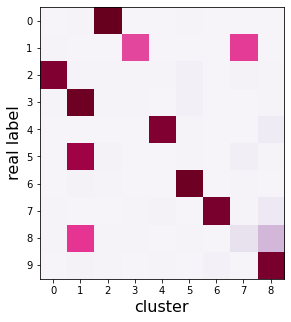

In [14]:
# #Data=60000, #pre-train epoch=100, #train epoch=50
fig = plt.Figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('cluster', fontsize=16)
ax.set_ylabel('real label', fontsize=16)
confusionmatrix = confusion_matrix(train_data.targets, Model.labels)
ax.set_xticks(range(confusionmatrix.shape[1]))
ax.set_yticks(range(confusionmatrix.shape[0]))
ax.imshow(confusionmatrix[:,:-1], cmap='PuRd')
fig

#### rearranged confusion_matrix

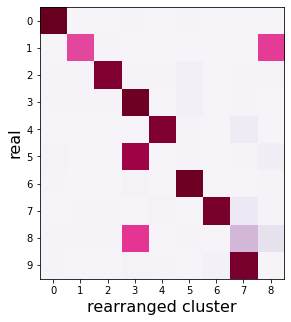

In [17]:
sorted_confusion_matrix = confusionmatrix[:,[2,3,0,1,4,5,6,8,7]]

fig = plt.Figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('rearranged cluster', fontsize=16)
ax.set_ylabel('real', fontsize=16)
ax.set_xticks(range(confusionmatrix.shape[1]))
ax.set_yticks(range(confusionmatrix.shape[0]))
ax.imshow(sorted_confusion_matrix, cmap='PuRd')
fig

#### NMI score

In [18]:
print(f'NMI={normalized_mutual_info_score(train_data.targets, Model.labels)}')

NMI=0.7435643101560503


#### Show the Origian, encoded and decoded train data

In [26]:
from ipywidgets import interact
import ipywidgets as widgets

label = 10

encoder = Model.enc.cpu()
decoder = Model.dec.cpu()

dat = train_data.data.view(-1,784)[Model.labels==label]
encoded_img = encoder(dat)
decoded_img = decoder(encoded_img)

encoded_img = encoded_img.detach().numpy()
decoded_img = decoded_img.detach().numpy()

def f(i):
    fig = plt.Figure(figsize=(10,10))
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)
    ax1.axis('off')
    # ax2.axis('off')
    ax3.axis('off')
    ax1.imshow(dat[i].reshape(28,28), cmap='gray')
    ax2.imshow(encoded_img[i].reshape(1,5), cmap='gray')
    print(encoded_img[i].reshape(1,5))
    ax3.imshow(decoded_img[i].reshape(28,28), cmap='gray')
    return fig
    
interact(f, i=widgets.IntSlider(min=0, max=dat.shape[0]-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=1308), Output()), _dom_classes=('widget-interact…

<function __main__.f(i)>

#### save DipDECK model

In [31]:
import pickle

with open('./saved_model/(new_k11) MNIST_kinit35_Pthreshold0.9_epoch50_024819_688495.pkl', 'wb') as outp:
    pickle.dump((enc, dec), outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(Model, outp, pickle.HIGHEST_PROTOCOL)